In [1]:
import pandas as pd
import numpy as np
import datetime
import string
import nltk
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import Counter
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
recall_score, precision_score, f1_score, roc_curve, roc_auc_score, auc
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import NearMiss
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier, plot_importance, plot_tree
from lightgbm import LGBMClassifier
from textblob import TextBlob
from sklearn.externals import joblib

starting_time = datetime.datetime.now()

/Users/nandar/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 1. Loading csv to dataframe and quick look into data

In [2]:
train_df = pd.read_csv('./datasets/train.csv')
test_df = pd.read_csv('./datasets/test.csv')
resources_df = pd.read_csv('./datasets/resources.csv')

In [3]:
train_df.head()

id                        teacher_id teacher_prefix school_state  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-11-18 14:45:59          Grades PreK-2   
1        2017-04-26 15:57:28             Grades 3-5   
2        2017-01-01 22:57:44             Grades 3-5   
3        2016-08-12 15:42:11             Grades 3-5   
4        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  My students are the greatest students but are ...   
4  My students are athletes and students who are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                            26                    1  
1                                             1                    0  
2                                             5                    1  
3                                            16                    0  
4                                            42                    1

In [4]:
test_df.head()

id                        teacher_id teacher_prefix school_state  \
0  p233245  5724a0c3ce11008366fff36dab4b943c            Ms.           CA   
1  p096795  445619941dc7cbe81c7be109dc61a56a           Mrs.           SC   
2  p236235  e92a4902b1611a189643d6f12c51e6a0           Mrs.           SC   
3  p233680  8e92622d2985d3faac1de71609c4be72           Mrs.           IA   
4  p171879  91a3c89981f626d9a0d067c65fb186ce            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-04-27 13:45:41          Grades PreK-2   
1        2016-04-28 12:43:56             Grades 3-5   
2        2016-04-29 21:16:05          Grades PreK-2   
3        2016-04-27 22:32:43          Grades PreK-2   
4        2016-04-27 18:59:15             Grades 6-8   

            project_subject_categories      project_subject_subcategories  \
0                     Music & The Arts                        Visual Arts   
1  Literacy & Language, Math & Science  Literature & Writing, Mathematics   
2                       Math & Science      Applied Sciences, Mathematics   
3                  Literacy & Language                           Literacy   
4      Music & The Arts, Special Needs     Performing Arts, Special Needs   

                         project_title  \
0             Art Will Make You Happy!   
1            Keeping up with the TIMEs   
2  Building Bridges to Problem Solving   
3                    Classroom Library   
4                 Reeds so we can Read   

                                     project_essay_1  \
0  My 2nd grade students are amazing!  They are v...   
1  Students within the classroom work in small gr...   
2  My students share  a love of learning. These s...   
3  Reading is the gateway to the soul.  Guiding c...   
4  \"Mr. Reyes!  I need another reed!\"  I hear t...   

                                     project_essay_2  \
0  My class is made up of 12 boys and 12 girls.  ...   
1  My students are all very talented young indivi...   
2  My class consists of 14 energetic learners.  O...   
3  First graders enter the classroom each day rea...   
4  We have a diverse population with almost entir...   

                                     project_essay_3  \
0  My second grade class will really benefit from...   
1  We do a lot of small group, where the student ...   
2  These Fairy Tale Problem Solving STEM kits wil...   
3  Book bins will help to organize our classroom ...   
4  Each day in my class students consume supplies...   

                                     project_essay_4  \
0  The genorous donations to my project will make...   
1  This project is very important to my classroom...   
2  These materials will be help my students with ...   
3  When students begin the first grade, many are ...   
4  My students come from very troubled homes and ...   

                            project_resource_summary  \
0  My students need a drying rack for their art p...   
1  My students need Time Magazines for next year ...   
2  My students need to be mentally stimulated to ...   
3   My students need an organized classroom library.   
4  My students need reeds to perform in class eac...   

   teacher_number_of_previously_posted_projects  
0                                             2  
1                                             1  
2                                             0  
3                                             0  
4                                             1

In [5]:
resources_df.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [6]:
print("train data shape",train_df.shape)
print("Total No of Projects in train.csv : ",len(train_df.id.unique()))
print("\ntest data shape",test_df.shape)
print("Total No of Projects in test.csv : ",len(test_df.id.unique()))
print("\nresources data shape",resources_df.shape)
print("Total No of Projects in resources.csv : ",len(resources_df.id.unique()))

train data shape (182080, 16)
Total No of Projects in train.csv :  182080

test data shape (78035, 15)
Total No of Projects in test.csv :  78035

resources data shape (1541272, 4)
Total No of Projects in resources.csv :  260115


In [7]:
# It found out that there are several projects under same project id.
# For train and test, there is no repetition or duplicated project.

resources_df[resources_df.id == 'p069063']

id                                        description  quantity  price
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3  14.95
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   8.45
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2  13.59
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3  24.95
5  p069063  Last to Finish: A Story About the Smartest Boy...         1  16.99
6  p069063  Mrs. Gorski, I Think I Have the Wiggle Fidgets...         1   9.95
7  p069063  See-N-Read 1503905CQ Reading Tool - Book Size,...         2  10.11

In [8]:
resources_df[resources_df.id == 'p256352']

id                                        description  quantity  \
30971  p256352  Apple - iPad� mini 2 with Wi-Fi - 16GB - Space...         2   
30972  p256352  Fintie Apple iPad mini / iPad mini 2 with Reti...         1   
30973  p256352  Fintie iPad mini 1/2/3 Kiddie Case - Light Wei...         2   
30974  p256352  Panasonic On-Ear Headphones RP-HT21 (Black & S...         4   

        price  
30971  299.99  
30972    7.99  
30973   17.99  
30974    5.95

In [9]:
resources_df[resources_df.id == 'p026602']

id                                        description  quantity  \
1399685  p026602  10 Plant Growing Trays (No Drain Holes) - 20" ...         1   
1399686  p026602              Brussel's CT9005CE Chinese Elm Bonsai         1   
1399687  p026602  Environmental Concepts 1662 Professional Soil ...         1   
1399688  p026602                     Kids Gardening Tool Set (blue)         2   
1399689  p026602                     Kids Gardening Tool Set (pink)         2   
1399690  p026602  Moleskine Passion Journal - Gardening, Large, ...         1   
1399691  p026602  Plant Large Walk in Greenhouse with Clear Cove...         1   
1399692  p026602  Plant Theatre Bonsai Trio Kit, 3 Distinctive B...         1   
1399693  p026602  Seedling Starter Trays, 144 Cells: (24 Trays; ...         1   

         price  
1399685  25.95  
1399686  36.02  
1399687  20.71  
1399688  11.88  
1399689  11.97  
1399690  14.99  
1399691  99.99  
1399692  18.99  
1399693   7.49

In [10]:
train_df.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

# 2. Aggregating Resource Data

In [11]:
resources_df['budget'] = resources_df.quantity * resources_df.price

In [12]:
resources_df.head(10)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   
5  p069063  Last to Finish: A Story About the Smartest Boy...         1   
6  p069063  Mrs. Gorski, I Think I Have the Wiggle Fidgets...         1   
7  p069063  See-N-Read 1503905CQ Reading Tool - Book Size,...         2   
8  p096795  Brewster WPD90218 Wall Pops Flirt Dot, Set of ...         2   
9  p096795  Brewster Wall Pops WPE99065 Peel & Stick Calyp...         2   

    price  budget  
0  149.00  149.00  
1   14.95   44.85  
2    8.45    8.45  
3   13.59   27.18  
4   24.95   74.85  
5   16.99   16.99  
6    9.95    9.95  
7   10.11   20.22  
8    9.95   19.90  
9    9.02   18.04

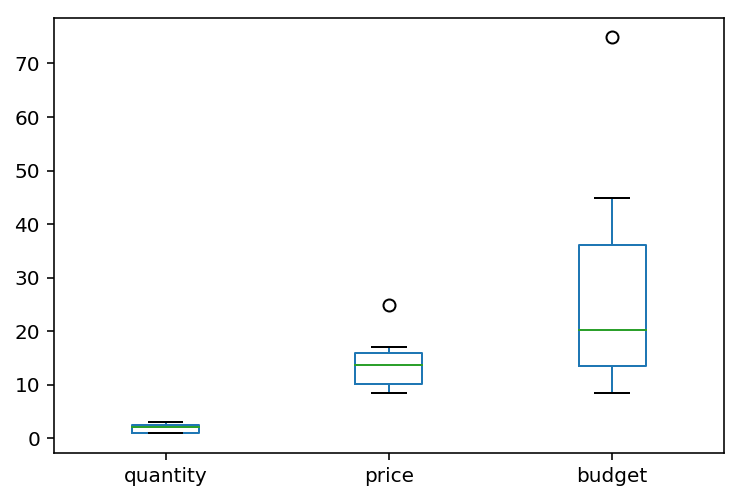

In [13]:
resources_df[resources_df.id == 'p069063'].plot(kind='box')


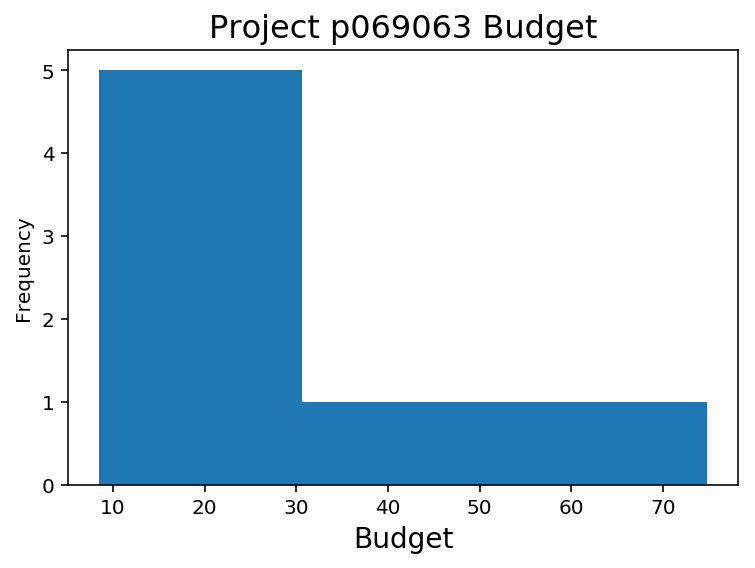

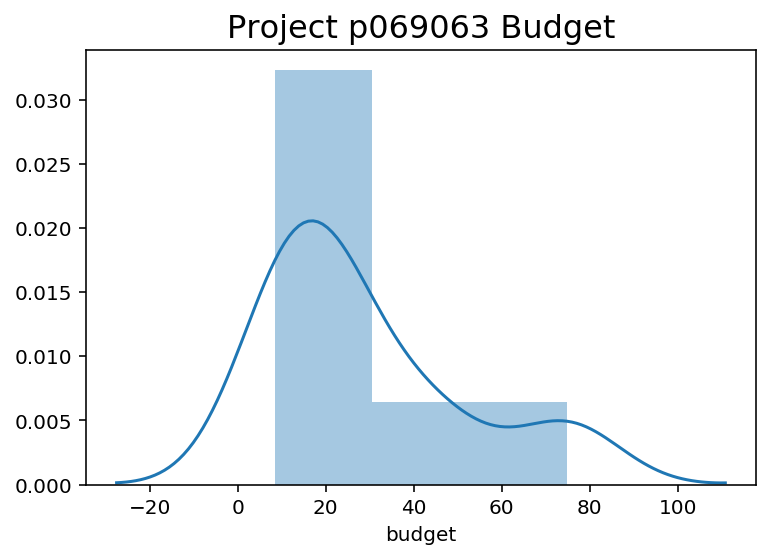

In [14]:
# Calculating bins "# of bins = square root of the # of data points"
bins = int(round(np.sqrt(len(resources_df[resources_df.id == 'p069063']))))

resources_df[resources_df.id == 'p069063']['budget'].plot(kind='hist', bins=bins)
plt.title('Project p069063 Budget', fontsize=16)
plt.xlabel('Budget', fontsize=14)
plt.show()
sns.distplot(resources_df[resources_df.id == 'p069063']['budget'])
plt.title('Project p069063 Budget', fontsize=16)
plt.show()

In [15]:
resource_budget = resources_df.groupby(['id'])['budget'].sum()
resource_budget = resource_budget.to_frame().reset_index()
resource_budget.head()

id   budget
0  p000001   833.63
1  p000002   630.28
2  p000003   298.97
3  p000004  1126.22
4  p000005   702.31

# 3. Combining train and test

In [16]:
whole_df = pd.concat([train_df,test_df], axis=0, ignore_index=True)
sequence = train_df.columns
whole_df = whole_df.reindex(columns=sequence)
whole_df.project_submitted_datetime = pd.to_datetime(whole_df.project_submitted_datetime)
whole_df.head()

id                        teacher_id teacher_prefix school_state  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-11-18 14:45:59          Grades PreK-2   
1        2017-04-26 15:57:28             Grades 3-5   
2        2017-01-01 22:57:44             Grades 3-5   
3        2016-08-12 15:42:11             Grades 3-5   
4        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  My students are the greatest students but are ...   
4  My students are athletes and students who are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                            26                  1.0  
1                                             1                  0.0  
2                                             5                  1.0  
3                                            16                  0.0  
4                                            42                  1.0

In [17]:
whole_df.tail()

id                        teacher_id teacher_prefix school_state  \
260110  p183993  be39c3d9b26cbb91f20435ba45e8451e           Mrs.           AL   
260111  p116343  90957869296e26198b1f162f169f8a55            Ms.           NM   
260112  p210728  692376a473aaf753890e329081b5787c           Mrs.           CA   
260113  p060531  0fcaec76e9ea1730e81f2ca8eae5891b           Mrs.           OR   
260114  p087783  d3fd1b7b0efff1eddbd3fbfe4c00711e           Mrs.           IN   

       project_submitted_datetime project_grade_category  \
260110        2017-04-07 07:48:40          Grades PreK-2   
260111        2017-04-25 17:46:26          Grades PreK-2   
260112        2017-04-17 17:53:12             Grades 6-8   
260113        2017-04-19 12:11:59             Grades 3-5   
260114        2017-04-27 19:50:35             Grades 3-5   

                   project_subject_categories  \
260110  Applied Learning, Literacy & Language   
260111                  Warmth, Care & Hunger   
260112                    Literacy & Language   
260113                  Warmth, Care & Hunger   
260114    Literacy & Language, Math & Science   

                  project_subject_subcategories  \
260110  Early Development, Literature & Writing   
260111                    Warmth, Care & Hunger   
260112           Literacy, Literature & Writing   
260113                    Warmth, Care & Hunger   
260114                    Literacy, Mathematics   

                                    project_title  \
260110                          iPad Intelligence   
260111  Clean Clothes Center- Finishing the Cycle   
260112                  Everyday Authors Among Us   
260113            Coat Lockers for Our Classroom!   
260114                    A Coffee Shop Classroom   

                                          project_essay_1  \
260110  I teach a diverse group of creative kindergart...   
260111  Many of our families do not have access to was...   
260112  My 6th grade students are a lively bunch of in...   
260113  In our classroom students celebrate their indi...   
260114  I am a teacher in a Title 1 K-5 elementary sch...   

                                          project_essay_2 project_essay_3  \
260110  My students will use the Apple iPad mini durin...             NaN   
260111  This clothes dryer will allow students that ha...             NaN   
260112  Every year, my 6th grade students write and pu...             NaN   
260113  At this time, my students place their personal...             NaN   
260114  I am gradually switching my classroom from tra...             NaN   

       project_essay_4                           project_resource_summary  \
260110             NaN  My students need one iPad mini to enhance thei...   
260111             NaN  My students need a clothes dryer to supplement...   
260112             NaN  My students need a variety of materials to use...   
260113             NaN  My students need coat lockers, so they have a ...   
260114             NaN  My students need flexible seating arrangements...   

        teacher_number_of_previously_posted_projects  project_is_approved  
260110                                            14                  NaN  
260111                                             1                  NaN  
260112                                             4                  NaN  
260113                                             9                  NaN  
260114                                             0                  NaN

In [18]:
whole_df = pd.merge(whole_df,resource_budget,on='id')
whole_df.head()

id                        teacher_id teacher_prefix school_state  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-11-18 14:45:59          Grades PreK-2   
1        2017-04-26 15:57:28             Grades 3-5   
2        2017-01-01 22:57:44             Grades 3-5   
3        2016-08-12 15:42:11             Grades 3-5   
4        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  My students are the greatest students but are ...   
4  My students are athletes and students who are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

   teacher_number_of_previously_posted_projects  project_is_approved  budget  
0                                            26                  1.0  899.94  
1                                             1                  0.0  400.00  
2                                             5                  1.0  469.99  
3                                            16                  0.0  684.47  
4                                            42                  1.0  711.00

# 4. Exploring Train Data

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [20]:
train_df.project_is_approved.value_counts()

1    154346
0     27734
Name: project_is_approved, dtype: int64

In [21]:
approve = train_df.project_is_approved.value_counts()[1] 
non_approve = train_df.project_is_approved.value_counts()[0]

frac = approve / non_approve
print("Approved project is {:.2f} times than not-approved project.".format(frac))

pct_of_approve = approve/(approve + non_approve)
print("percentage of approved project is", np.round(pct_of_approve*100), "%")
pct_of_non_approve = non_approve/(approve + non_approve)
print("percentage of not-approved project is", np.round(pct_of_non_approve*100), "%")

# Need to deal with imbalance class

Approved project is 5.57 times than not-approved project.
percentage of approved project is 85.0 %
percentage of not-approved project is 15.0 %


In [22]:
train_df[train_df.duplicated()]

# There is no duplicated row in train dataset.

Empty DataFrame
Columns: [id, teacher_id, teacher_prefix, school_state, project_submitted_datetime, project_grade_category, project_subject_categories, project_subject_subcategories, project_title, project_essay_1, project_essay_2, project_essay_3, project_essay_4, project_resource_summary, teacher_number_of_previously_posted_projects, project_is_approved]
Index: []

In [23]:
len(train_df.teacher_id.unique())

104414

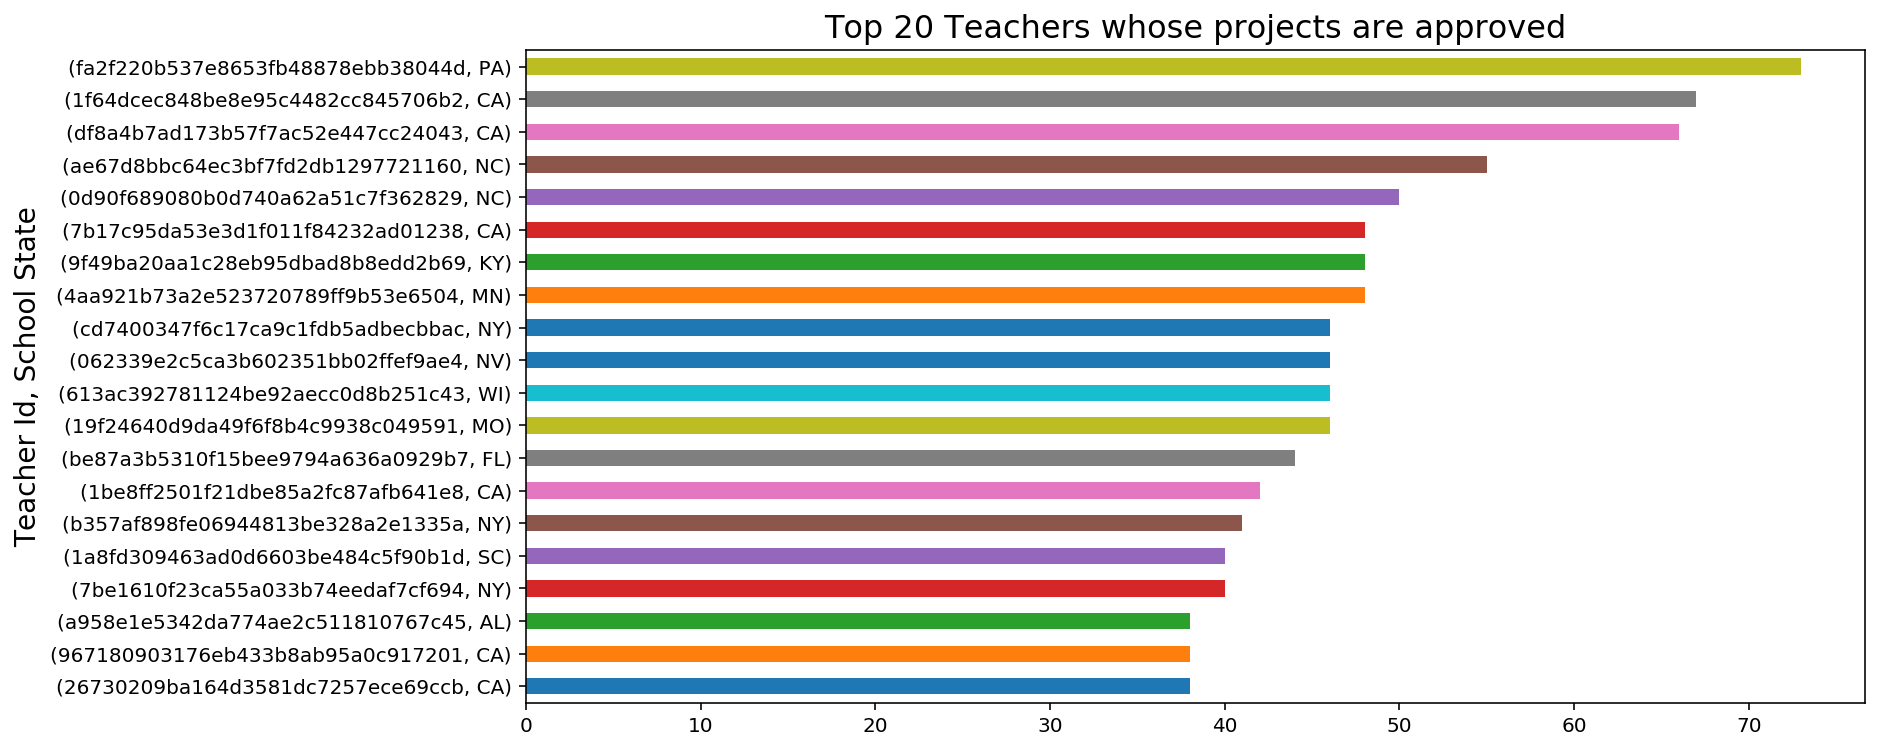

In [24]:
train_df.groupby(['teacher_id','school_state'])['project_is_approved'].sum() \
                    .sort_values(ascending=True).tail(20) \
                    .plot(kind='barh', figsize=(12,6), fontsize=10)
plt.title('Top 20 Teachers whose projects are approved', fontsize=16)
plt.ylabel('Teacher Id, School State', fontsize=14)
plt.show()

In [25]:
((train_df.groupby(['teacher_id'])['project_is_approved'].sum() / \
 train_df.groupby(['teacher_id'])['teacher_number_of_previously_posted_projects'].sum()
 ) * 100).dropna(inplace=False).head()

teacher_id
00000f7264c27ba6fea0c837ed6aa0aa     50.000000
00002d44003ed46b066607c5455a999a    100.000000
00006084c3d92d904a22e0a70f5c119a     66.666667
0000a9af8b6b9cc9e41f53322a8b8cf1     40.000000
0000d4777d14b33a1406dd6c9019fe89           inf
dtype: float64

In [26]:
len(train_df.teacher_id.unique())

104414

In [27]:
train_df.groupby('teacher_id')['id'].count().sort_values(ascending=False).head(10)

teacher_id
fa2f220b537e8653fb48878ebb38044d    74
df8a4b7ad173b57f7ac52e447cc24043    71
1f64dcec848be8e95c4482cc845706b2    70
ae67d8bbc64ec3bf7fd2db1297721160    58
0d90f689080b0d740a62a51c7f362829    51
062339e2c5ca3b602351bb02ffef9ae4    49
4aa921b73a2e523720789ff9b53e6504    48
7b17c95da53e3d1f011f84232ad01238    48
9f49ba20aa1c28eb95dbad8b8edd2b69    48
613ac392781124be92aecc0d8b251c43    47
Name: id, dtype: int64

In [28]:
train_df.groupby('teacher_id')['project_is_approved'].sum().sort_values(ascending=False).head(10)

teacher_id
fa2f220b537e8653fb48878ebb38044d    73
1f64dcec848be8e95c4482cc845706b2    67
df8a4b7ad173b57f7ac52e447cc24043    66
ae67d8bbc64ec3bf7fd2db1297721160    55
0d90f689080b0d740a62a51c7f362829    50
7b17c95da53e3d1f011f84232ad01238    48
4aa921b73a2e523720789ff9b53e6504    48
9f49ba20aa1c28eb95dbad8b8edd2b69    48
062339e2c5ca3b602351bb02ffef9ae4    46
cd7400347f6c17ca9c1fdb5adbecbbac    46
Name: project_is_approved, dtype: int64

In [29]:
# ((train_temp.groupby(['teacher_id'])['project_is_approved'].sum() / \
#  train_temp.teacher_idii.value_counts()
#  ) * 100).sort_values(ascending=False).plot(kind='bar', figsize=(12,6), fontsize=10)
# plt.title('Project Approving Percentage by teacher_id', fontsize=16)
# plt.xlabel('teacher_id', fontsize=14)
# plt.show()

# 5. Exploring Whole Dataset

In [30]:
whole_df[whole_df.duplicated()]

# There is no duplicated row in train dataset.

Empty DataFrame
Columns: [id, teacher_id, teacher_prefix, school_state, project_submitted_datetime, project_grade_category, project_subject_categories, project_subject_subcategories, project_title, project_essay_1, project_essay_2, project_essay_3, project_essay_4, project_resource_summary, teacher_number_of_previously_posted_projects, project_is_approved, budget]
Index: []

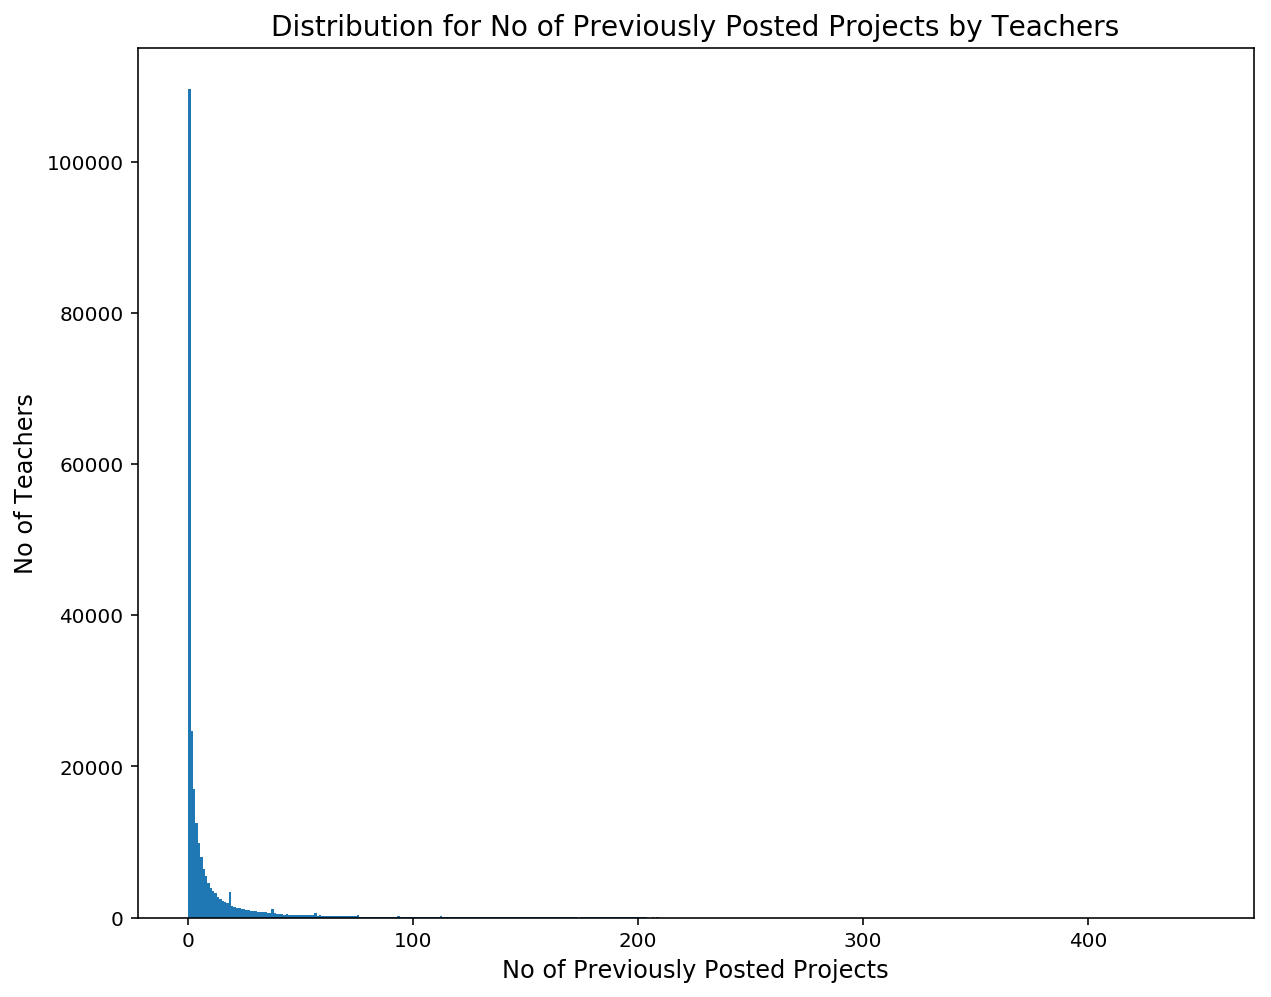

In [31]:
# Calculating bins "# of bins = square root of the # of data points"
bins = int(round(np.sqrt(len(train_df))))

whole_df.teacher_number_of_previously_posted_projects.plot(kind='hist', 
                                                           bins = bins,
                                                           figsize=(10,8))
plt.title('Distribution for No of Previously Posted Projects by Teachers', fontsize=14)
plt.xlabel('No of Previously Posted Projects', fontsize=12)
plt.ylabel('No of Teachers',fontsize=12)
plt.show()
plt.show()

### 5.1 Observing Gender to see if it should be included as features or not

In [32]:
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260115 entries, 0 to 260114
Data columns (total 17 columns):
id                                              260115 non-null object
teacher_id                                      260115 non-null object
teacher_prefix                                  260110 non-null object
school_state                                    260115 non-null object
project_submitted_datetime                      260115 non-null datetime64[ns]
project_grade_category                          260115 non-null object
project_subject_categories                      260115 non-null object
project_subject_subcategories                   260115 non-null object
project_title                                   260115 non-null object
project_essay_1                                 260115 non-null object
project_essay_2                                 260115 non-null object
project_essay_3                                 9078 non-null object
project_essay_4                

In [33]:
print(whole_df.teacher_prefix.unique())
whole_df.teacher_prefix.value_counts()

['Ms.' 'Mrs.' 'Mr.' 'Teacher' 'Dr.' nan]


Mrs.       136387
Ms.         92651
Mr.         25462
Teacher      5569
Dr.            41
Name: teacher_prefix, dtype: int64

In [34]:
def gender(x):
    if x == 'Ms.' or x == 'Mrs.':
        return 'female'
    elif x == 'Mr.':
        return 'male'
    elif x == 'Dr.' or x == 'Teacher':
        return 'neutral'
    else:
        return 'none'

In [35]:
whole_df.insert(loc=3, column='gender', value=list(whole_df.teacher_prefix.apply(gender)))
whole_df.head()

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.    male   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.    male   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   
3           NC        2016-08-12 15:42:11             Grades 3-5   
4           CA        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  My students are the greatest students but are ...   
4  My students are athletes and students who are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

   teacher_number_of_previously_posted_projects  project_is_approved  budget  
0                                            26                  1.0  899.94  
1                                             1                  0.0  400.00  
2                                             5                  1.0  469.99  
3                                            16                  0.0  684.47  
4                                            42                  1.0  711.00

In [36]:
whole_df[whole_df.teacher_prefix.isnull()]

# but it is taken care of by gender row. When i do dummy, it'll be dropped anyway.
# no need to drop or futher process.

id                        teacher_id teacher_prefix gender  \
17809   p180947  834f75f1b5e24bd10abe9c3dbf7ba12f            NaN   none   
22174   p002730  339bd5a9e445d68a74d65b99cd325397            NaN   none   
127966  p153408  339bd5a9e445d68a74d65b99cd325397            NaN   none   
158692  p197901  e4be6aaaa887d4202df2b647fbfc82bb            NaN   none   
185014  p252889  e629ce000cfa93c84659dfbcaf4f504f            NaN   none   

       school_state project_submitted_datetime project_grade_category  \
17809            CA        2016-11-04 00:15:45             Grades 3-5   
22174            SC        2016-05-09 09:38:40            Grades 9-12   
127966           SC        2016-05-10 15:18:23            Grades 9-12   
158692           PA        2016-06-03 10:15:05             Grades 3-5   
185014           CA        2016-05-21 13:05:33             Grades 6-8   

                 project_subject_categories  \
17809   Literacy & Language, Math & Science   
22174                   Literacy & Language   
127966                  Literacy & Language   
158692  Literacy & Language, Math & Science   
185014      Math & Science, Health & Sports   

            project_subject_subcategories  \
17809   Literature & Writing, Mathematics   
22174                Literature & Writing   
127966               Literature & Writing   
158692              Literacy, Mathematics   
185014           Mathematics, Team Sports   

                                           project_title  \
17809   1:7 Increasing Tech to Decrease Achievement Gaps   
22174                            iPads for STEM Stations   
127966                iPad for STEM and Literacy Station   
158692                                   Document Camera   
185014                A Smarter Way To Be A Hoop-er Star   

                                          project_essay_1  \
17809   The children at Anna Yates Elementary school a...   
22174   Within the next 20 years, every job will invol...   
127966  Within the next 20 years, every job will invol...   
158692  Students at Robertsdale Elementary live in a l...   
185014  The majority of our students are of Latino her...   

                                          project_essay_2  \
17809   My goal is to bring in 1 laptop for every 7 st...   
22174   The students in our school come from a wide va...   
127966  The students in our school come from a wide va...   
158692  This SMART Document Camera will improve my stu...   
185014  By helping our students get Wilson X connected...   

                                          project_essay_3  \
17809                                                 NaN   
22174   Students will use the iPad station for individ...   
127966  Students will use the iPad at the iPad station...   
158692                                                NaN   
185014                                                NaN   

                                          project_essay_4  \
17809                                                 NaN   
22174   Your generosity will allow my students to work...   
127966  Your generosity will allow my students to work...   
158692                                                NaN   
185014                                                NaN   

                                 project_resource_summary  \
17809   My students need a classroom laptop that is ju...   
22174         My students need 5 iPads for STEM stations.   
127966  My students need 5 iPads with protection plans...   
158692  My students need a Smart Document Camera to en...   
185014  My students need WIlson X Connected smart bask...   

        teacher_number_of_previously_posted_projects  project_is_approved  \
17809                                              1                  1.0   
22174                                              0                  1.0   
127966                                             1                  1.0   
158692                                             0             

In [37]:
train_temp = train_df.copy()
train_temp.insert(loc=3, column='gender', 
                  value=list(train_temp.teacher_prefix.apply(gender)))
train_temp.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title  \
0                                Literacy  Super Sight Word Centers   
1            Performing Arts, Team Sports    Keep Calm and Dance On   
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                            26                    1  
1                                             1                    0  
2                                             5                    1

In [38]:
train_temp_mf = train_temp[(train_temp.gender == 'female') | (train_temp.gender == 'male')]
train_temp_mf.sample(5)

id                        teacher_id teacher_prefix  gender  \
77108  p131778  ef399cd170c70ad0f45209a057f3066b            Ms.  female   
48999  p151333  141e1500a875c7e26d0ccdb16cc8f63b            Ms.  female   
81915  p132015  92c679bf3a5cecab6d16ee7bab9e4702           Mrs.  female   
50787  p073758  3c06d3a8453846890862b23355a890e1            Ms.  female   
84283  p248851  8392211eb17eb54a18a2bc085457bcc7            Ms.  female   

      school_state project_submitted_datetime project_grade_category  \
77108           FL        2016-10-24 20:18:41             Grades 3-5   
48999           MN        2016-06-27 10:28:52            Grades 9-12   
81915           CA        2017-02-01 12:12:01          Grades PreK-2   
50787           DC        2016-08-05 17:16:55             Grades 3-5   
84283           CT        2016-11-17 15:27:49             Grades 6-8   

      project_subject_categories  project_subject_subcategories  \
77108             Math & Science  Applied Sciences, Mathematics   
48999           Music & The Arts                    Visual Arts   
81915              Special Needs                  Special Needs   
50787        Literacy & Language           Literature & Writing   
84283           Music & The Arts                    Visual Arts   

                                           project_title  \
77108  The Future of Education Lies Within the Latest...   
48999                      Quality Potters Tools Needed!   
81915                              Tablets For Teaching!   
50787                Sharing Our Ideas and not Our Germs   
84283                        \"Put it All in One Place\"   

                                         project_essay_1  \
77108  I am a 3rd grade teacher at a Title I school w...   
48999  We are so lucky to have a beautiful school, an...   
81915  My students have autism and are fully included...   
50787  My students are a bright bunch that are hungry...   
84283  We are a school in an urban school district.  ...   

                                         project_essay_2 project_essay_3  \
77108  Many of my students lack exposure to the lates...             NaN   
48999  These tools are some of the work horses of a c...             NaN   
81915  My students are fully included in the general ...             NaN   
50787  The first aspect of this project will create a...             NaN   
84283  My students need these art portfolios in order...             NaN   

      project_essay_4                           project_resource_summary  \
77108             NaN  My students need tablets to access the latest ...   
48999             NaN  My students need quality tools to improve the ...   
81915             NaN  My students need ipads to deepen their underst...   
50787             NaN  My students need to share ideas not germs. I h...   
84283             NaN  My students need these art portfolios in order...   

       teacher_number_of_previously_posted_projects  project_is_approved  
77108                                             0                    0  
48999                                             0                    1  
81915                                             7                    1  
50787                                             4                    0  
84283                                             0                    1

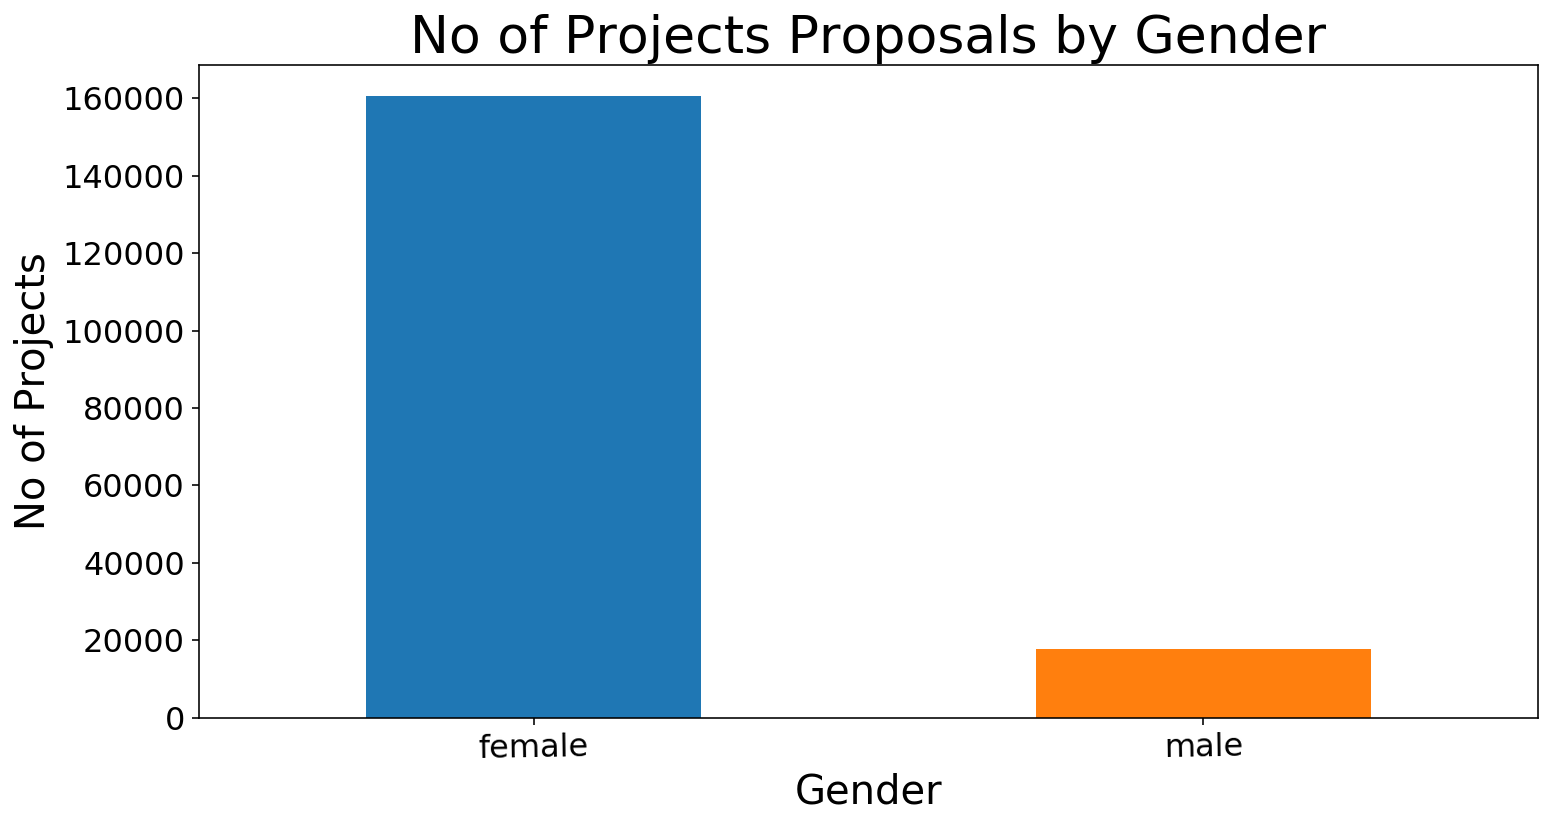

In [39]:
train_temp_mf.gender.value_counts().plot(kind='bar', rot = 1, fontsize=16, figsize = (12,6))
plt.title('No of Projects Proposals by Gender', fontsize=26)
plt.xlabel('Gender', fontsize=20)
plt.ylabel('No of Projects', fontsize=20)
plt.show()

In [40]:
((train_temp.groupby(['gender'])['project_is_approved'].sum() / \
 train_temp.gender.value_counts()
 ) * 100)

gender
female      84.961146
male        84.202185
neutral     79.431183
none       100.000000
dtype: float64

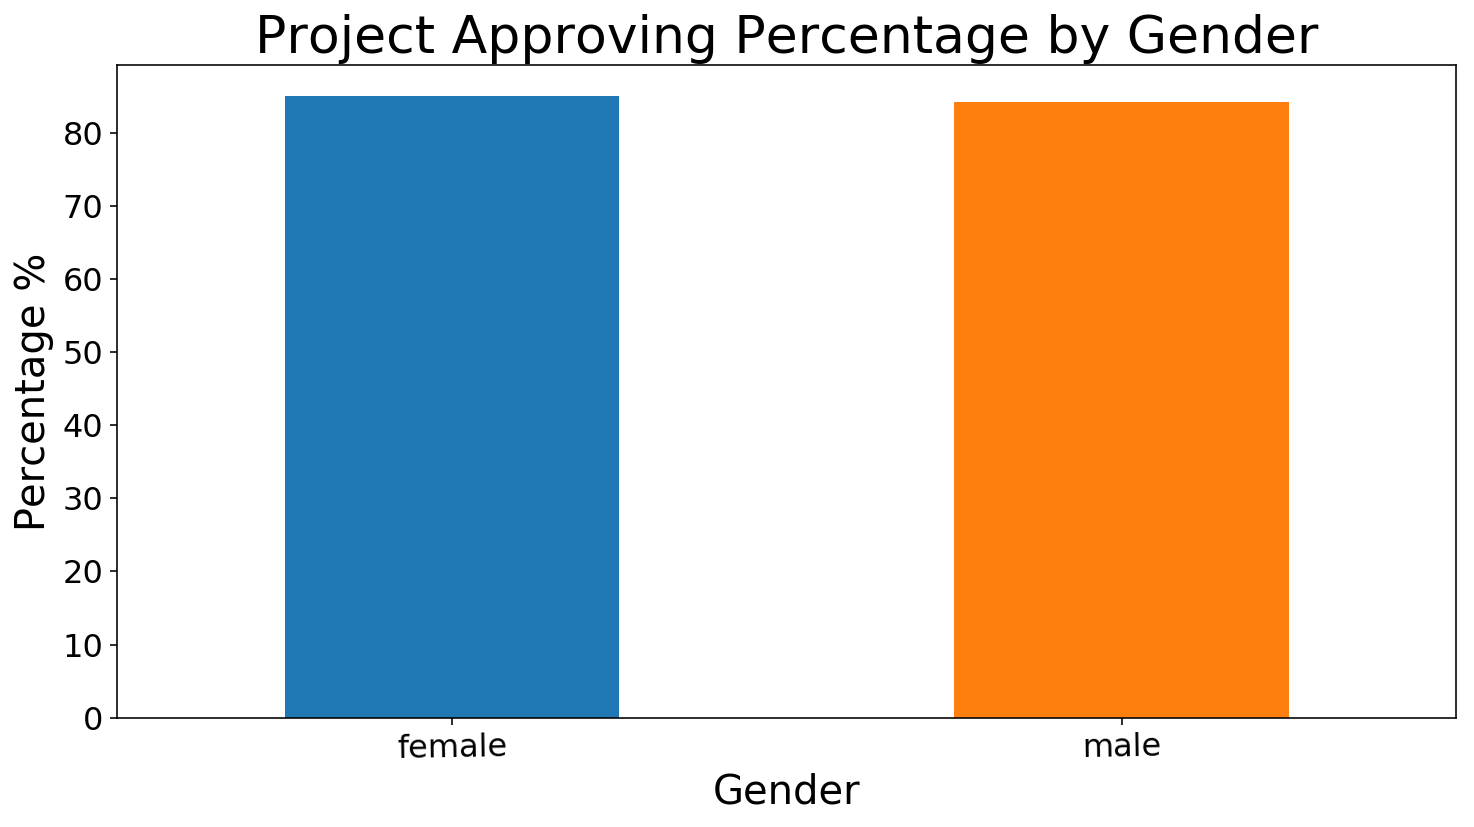

In [41]:
((train_temp_mf.groupby(['gender'])['project_is_approved'].sum() / \
 train_temp_mf.gender.value_counts()
 ) * 100).sort_values(ascending=False).plot(kind='bar', figsize=(12,6), fontsize=16, rot=1)
plt.title('Project Approving Percentage by Gender', fontsize=26)
plt.xlabel('Gender', fontsize=20)
plt.ylabel('Percentage %', fontsize=20)
plt.show()

In [42]:
# According to above finding, Gender is not the major factor in project proposal 
# approving since the approval % for each gender are about the same.

In [43]:
gender_features = pd.get_dummies(whole_df.gender, prefix = 'gender').iloc[:,:3]
# whole_df = pd.concat([whole_df,gender_dummy],axis=1)
# whole_df.head()

### 5.2 Adding Grade as features

In [44]:
whole_df.project_grade_category.isnull().unique()

array([False])

In [45]:
whole_df.project_grade_category.value_counts()

Grades PreK-2    105361
Grades 3-5        88327
Grades 6-8        40266
Grades 9-12       26161
Name: project_grade_category, dtype: int64

In [46]:
train_temp.project_grade_category.value_counts()

Grades PreK-2    73890
Grades 3-5       61682
Grades 6-8       28197
Grades 9-12      18311
Name: project_grade_category, dtype: int64

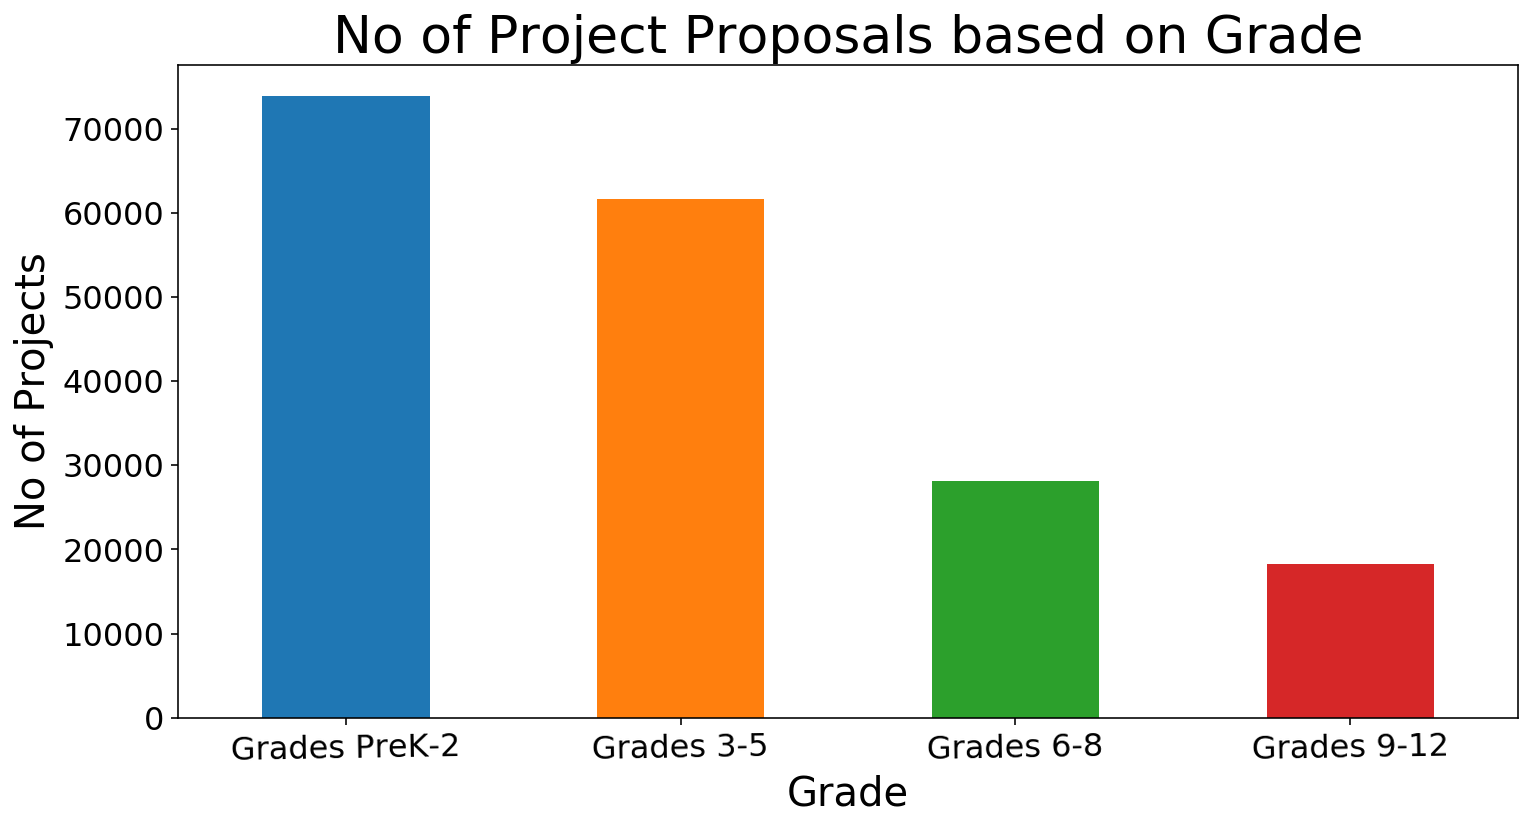

In [47]:
train_temp.project_grade_category.value_counts().plot(kind='bar',figsize=(12,6), fontsize=16, rot=1)
plt.title('No of Project Proposals based on Grade', fontsize=26)
plt.xlabel('Grade', fontsize=20)
plt.ylabel('No of Projects', fontsize=20)
plt.show()

In [48]:
((train_temp.groupby(['project_grade_category'])['project_is_approved'].sum() / \
 train_temp.project_grade_category.value_counts()
 ) * 100)

Grades 3-5       85.397685
Grades 6-8       84.345852
Grades 9-12      83.523565
Grades PreK-2    84.712410
dtype: float64

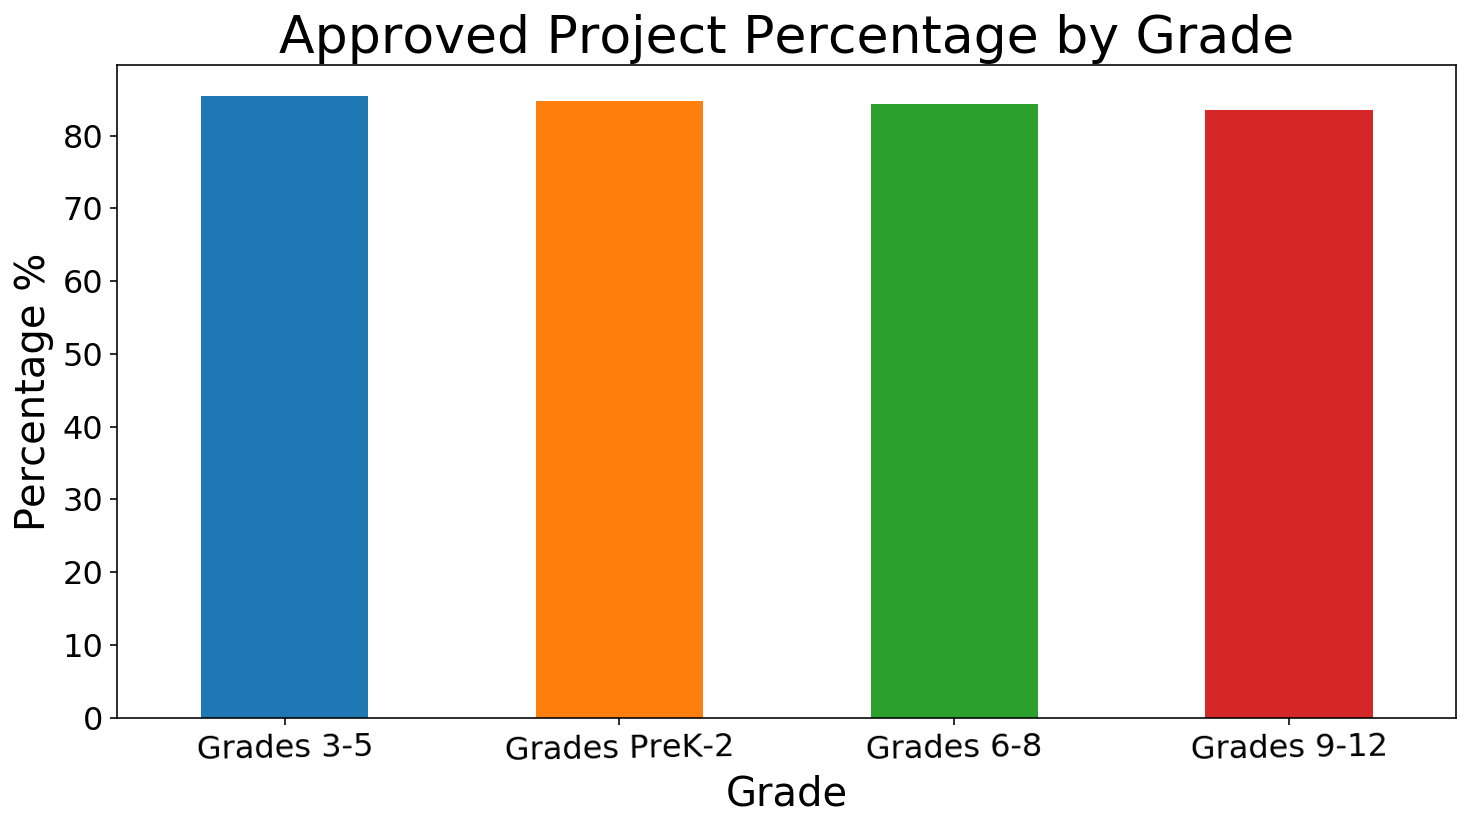

In [49]:
((train_temp.groupby(['project_grade_category'])['project_is_approved'].sum() / \
 train_temp.project_grade_category.value_counts()
 ) * 100).sort_values(ascending=False).plot(kind='bar', figsize=(12,6), fontsize=16, rot=1)
plt.title('Approved Project Percentage by Grade', fontsize=26)
plt.xlabel('Grade', fontsize=20)
plt.ylabel('Percentage %', fontsize=20)
plt.show()

In [50]:
grade_features = pd.get_dummies(whole_df.project_grade_category, prefix = 'grade')
grade_features.drop(['grade_Grades 9-12'], axis=1, inplace = True)
# whole_df = pd.concat([whole_df,grade_features],axis=1)
# whole_df.head()

### 5.3 Adding Subjects as features

In [51]:
print('Total Subject Categories :',len(whole_df.project_subject_categories.unique()))
whole_df.project_subject_categories.value_counts()

Total Subject Categories : 51


Literacy & Language                           56034
Math & Science                                40586
Literacy & Language, Math & Science           34947
Health & Sports                               24257
Music & The Arts                              12253
Special Needs                                 10199
Literacy & Language, Special Needs             9653
Applied Learning                               8972
Math & Science, Literacy & Language            5437
Applied Learning, Literacy & Language          5354
History & Civics                               4384
Math & Science, Special Needs                  4336
Literacy & Language, Music & The Arts          4130
Math & Science, Music & The Arts               3881
Applied Learning, Special Needs                3534
Health & Sports, Special Needs                 3388
History & Civics, Literacy & Language          3316
Warmth, Care & Hunger                          3178
Math & Science, Applied Learning               2989
Applied Lear

In [52]:
print('Total Subject Subcategories :',len(whole_df.project_subject_subcategories.unique()))
whole_df.project_subject_subcategories.value_counts()

Total Subject Subcategories : 416


Literacy                                        22634
Literacy, Mathematics                           19793
Literature & Writing, Mathematics               14224
Literacy, Literature & Writing                  13241
Mathematics                                     12913
Literature & Writing                            10629
Special Needs                                   10199
Health & Wellness                                8561
Applied Sciences, Mathematics                    8024
Literacy, Special Needs                          5905
Applied Sciences                                 5717
Gym & Fitness, Health & Wellness                 5454
Visual Arts                                      5277
ESL, Literacy                                    5089
Music                                            3453
Literature & Writing, Special Needs              3241
Warmth, Care & Hunger                            3178
Health & Wellness, Special Needs                 2916
Mathematics, Special Needs  

In [53]:
# Since subcategories is more specific and detail than categories by looking at their 
# total unique title, only subcategories shall be used as features.

In [54]:
print("No of Sub categories under category called Literacy & Language :", \
len(train_df[train_df.project_subject_categories == 'Literacy & Language']['project_subject_subcategories'].unique()))
train_df[train_df.project_subject_categories == 'Literacy & Language']\
                            ['project_subject_subcategories'].unique()


No of Sub categories under category called Literacy & Language : 10


array(['Literacy', 'Literature & Writing', 'ESL, Literacy',
       'Literacy, Literature & Writing', 'ESL, Literature & Writing',
       'Foreign Languages, Literacy', 'ESL', 'Foreign Languages',
       'Foreign Languages, Literature & Writing',
       'ESL, Foreign Languages'], dtype=object)

In [55]:
cat_features = pd.get_dummies(whole_df.project_subject_categories, prefix = 'cat')
cat_features.columns
#cat_features.drop(['cat_History & Civics, Warmth, Care & Hunger'], axis=1, inplace = True)

Index(['cat_Applied Learning', 'cat_Applied Learning, Health & Sports',
       'cat_Applied Learning, History & Civics',
       'cat_Applied Learning, Literacy & Language',
       'cat_Applied Learning, Math & Science',
       'cat_Applied Learning, Music & The Arts',
       'cat_Applied Learning, Special Needs',
       'cat_Applied Learning, Warmth, Care & Hunger', 'cat_Health & Sports',
       'cat_Health & Sports, Applied Learning',
       'cat_Health & Sports, History & Civics',
       'cat_Health & Sports, Literacy & Language',
       'cat_Health & Sports, Math & Science',
       'cat_Health & Sports, Music & The Arts',
       'cat_Health & Sports, Special Needs',
       'cat_Health & Sports, Warmth, Care & Hunger', 'cat_History & Civics',
       'cat_History & Civics, Applied Learning',
       'cat_History & Civics, Health & Sports',
       'cat_History & Civics, Literacy & Language',
       'cat_History & Civics, Math & Science',
       'cat_History & Civics, Music & The Arts',


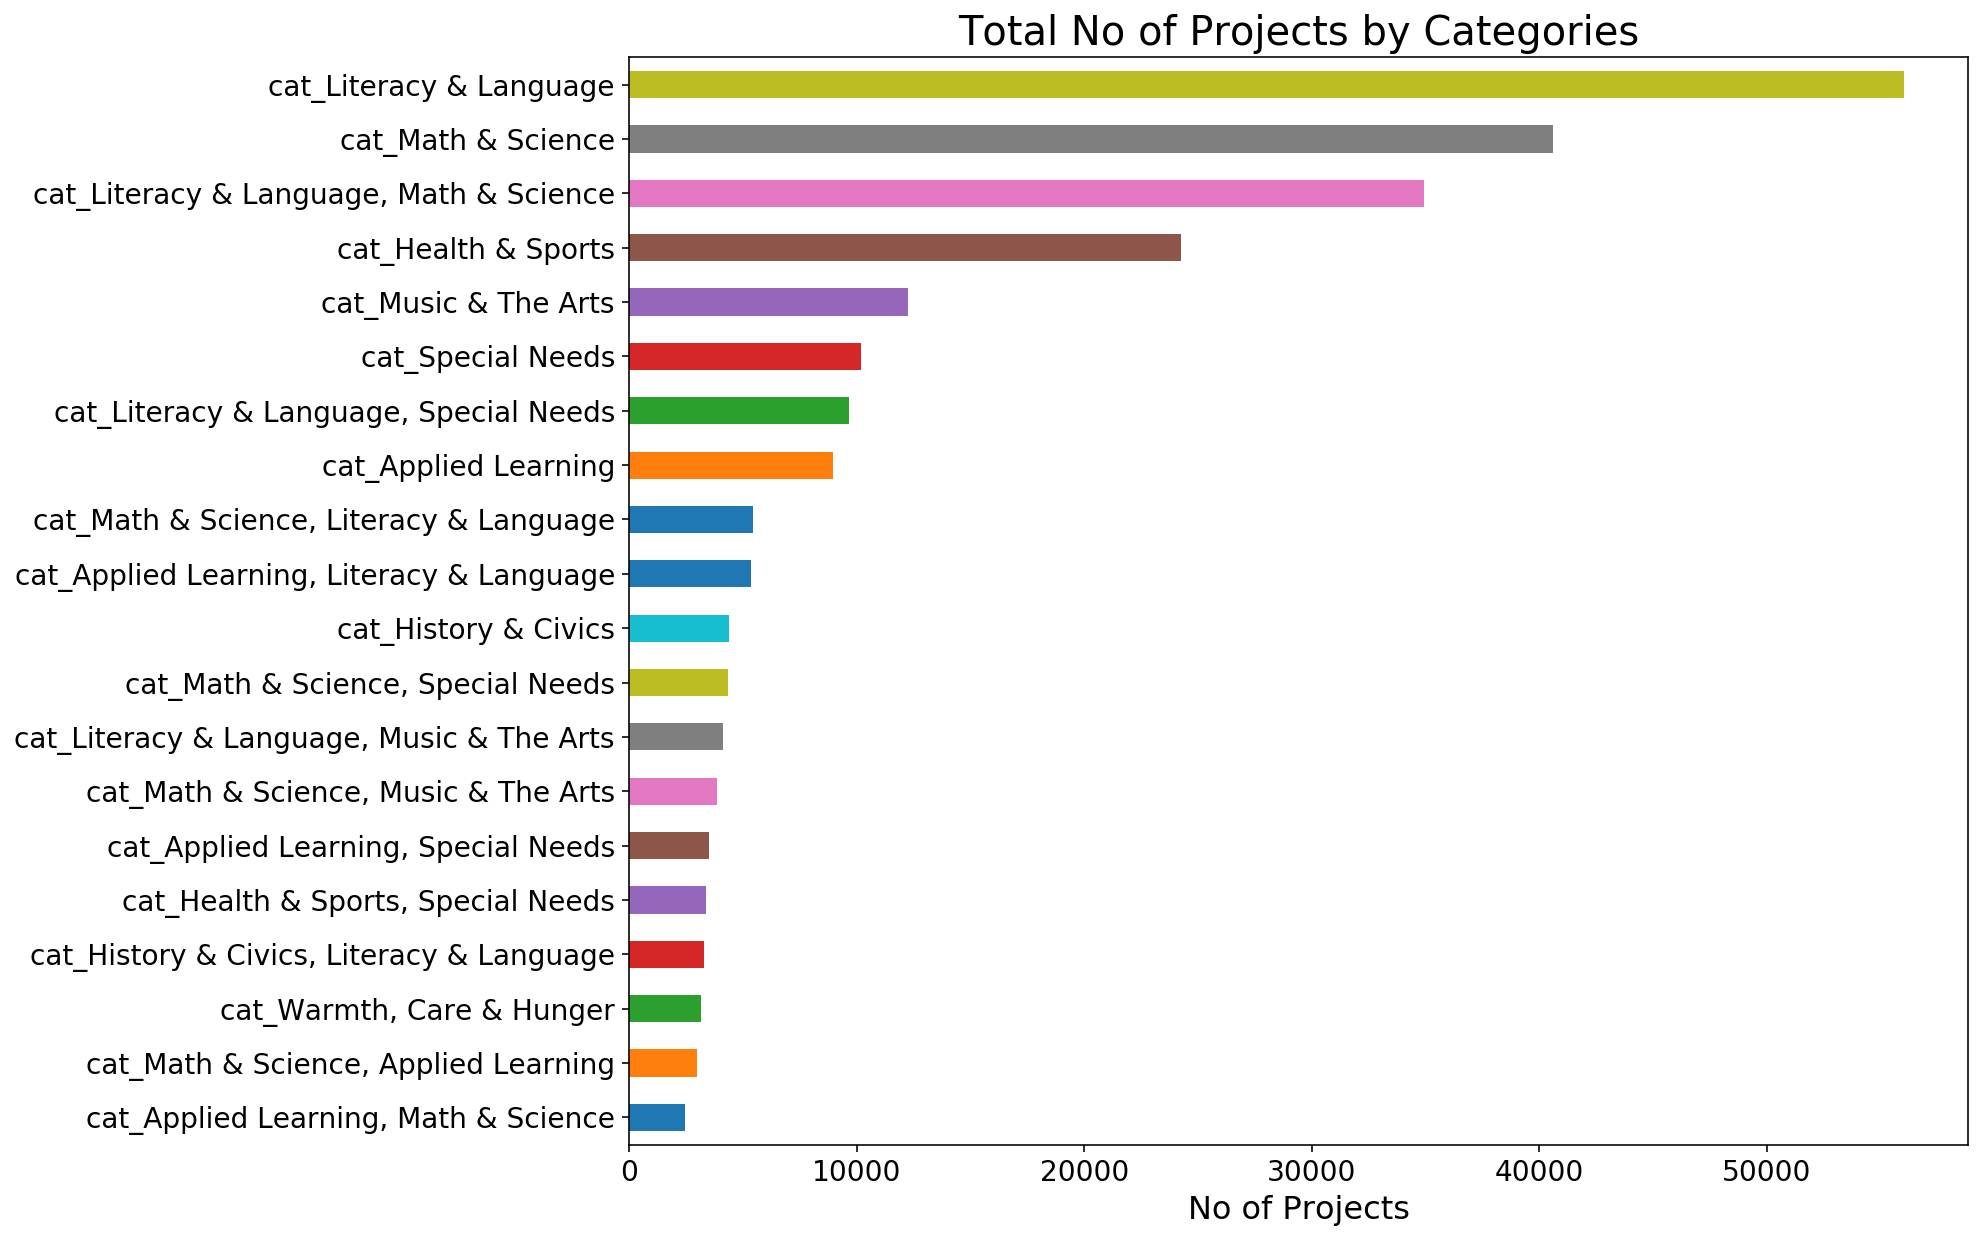

In [56]:
cat_features.sum().sort_values(ascending=False).head(20) \
                     .sort_values(ascending=True) \
                     .plot(kind='barh', figsize=(12,10), fontsize=14)
plt.title('Total No of Projects by Categories', fontsize=20)
plt.xlabel('No of Projects', fontsize=16)
plt.show()

In [57]:
cat_checking = train_df.groupby('project_subject_categories')['project_is_approved'].count()
cat_checking.to_frame().reset_index().sort_values(by='project_subject_categories', ascending=True)

project_subject_categories  project_is_approved
0                             Applied Learning                 6310
1            Applied Learning, Health & Sports                 1018
2           Applied Learning, History & Civics                  303
3        Applied Learning, Literacy & Language                 3725
4             Applied Learning, Math & Science                 1711
5           Applied Learning, Music & The Arts                 1241
6              Applied Learning, Special Needs                 2481
7      Applied Learning, Warmth, Care & Hunger                   22
8                              Health & Sports                16951
9            Health & Sports, Applied Learning                  297
10           Health & Sports, History & Civics                   67
11        Health & Sports, Literacy & Language                 1308
12             Health & Sports, Math & Science                  470
13           Health & Sports, Music & The Arts                  262
14              Health & Sports, Special Needs                 2368
15      Health & Sports, Warmth, Care & Hunger                   31
16                            History & Civics                 3065
17          History & Civics, Applied Learning                   65
18           History & Civics, Health & Sports                   20
19       History & Civics, Literacy & Language                 2288
20            History & Civics, Math & Science                  525
21          History & Civics, Music & The Arts                  544
22             History & Civics, Special Needs                  417
23     History & Civics, Warmth, Care & Hunger                    1
24                         Literacy & Language                39257
25       Literacy & Language, Applied Learning                 1038
26        Literacy & Language, Health & Sports                  127
27       Literacy & Language, History & Civics                 1315
28         Literacy & Language, Math & Science                24499
29       Literacy & Language, Music & The Arts                 2878
30          Literacy & Language, Special Needs                 6685
31  Literacy & Language, Warmth, Care & Hunger                   25
32                              Math & Science                28555
33            Math & Science, Applied Learning                 2071
34             Math & Science, Health & Sports                  697
35            Math & Science, History & Civics                 1087
36         Math & Science, Literacy & Language                 3843
37            Math & Science, Music & The Arts                 2761
38               Math & Science, Special Needs                 3010
39       Math & Science, Warmth, Care & Hunger                   19
40                            Music & The Arts                 8527
41          Music & The Arts, Applied Learning                   21
42           Music & The Arts, Health & Sports                   32
43          Music & The Arts, History & Civics                   29
44             Music & The Arts, Special Needs                  235
45     Music & The Arts, Warmth, Care & Hunger                    3
46                               Special Needs                 7065
47              Special Needs, Health & Sports                   64
48             Special Needs, Music & The Arts                  521
49        Special Needs, Warmth, Care & Hunger                   35
50                       Warmth, Care & Hunger                 2191

In [58]:
train_df.project_subject_categories.unique()

array(['Literacy & Language', 'Music & The Arts, Health & Sports',
       'Math & Science, Literacy & Language', 'Health & Sports',
       'Applied Learning, Literacy & Language', 'Math & Science',
       'Literacy & Language, Math & Science', 'Special Needs',
       'Applied Learning, Special Needs',
       'Applied Learning, Music & The Arts',
       'Math & Science, Special Needs', 'Health & Sports, Special Needs',
       'Literacy & Language, History & Civics',
       'Health & Sports, Literacy & Language', 'Music & The Arts',
       'Literacy & Language, Special Needs',
       'Special Needs, Music & The Arts', 'History & Civics',
       'Health & Sports, Applied Learning', 'Applied Learning',
       'Math & Science, Applied Learning',
       'Literacy & Language, Music & The Arts',
       'Math & Science, Music & The Arts',
       'History & Civics, Special Needs',
       'History & Civics, Literacy & Language', 'Warmth, Care & Hunger',
       'Math & Science, History & Civics',


In [59]:
subcat_features = pd.get_dummies(whole_df.project_subject_subcategories, prefix = 'subcat')
subcat_features.drop(['subcat_Economics, Other'], axis=1, inplace = True)
subcat_features.shape
# whole_df = pd.concat([whole_df,subcat_features],axis=1)
# whole_df.head()

(260115, 415)

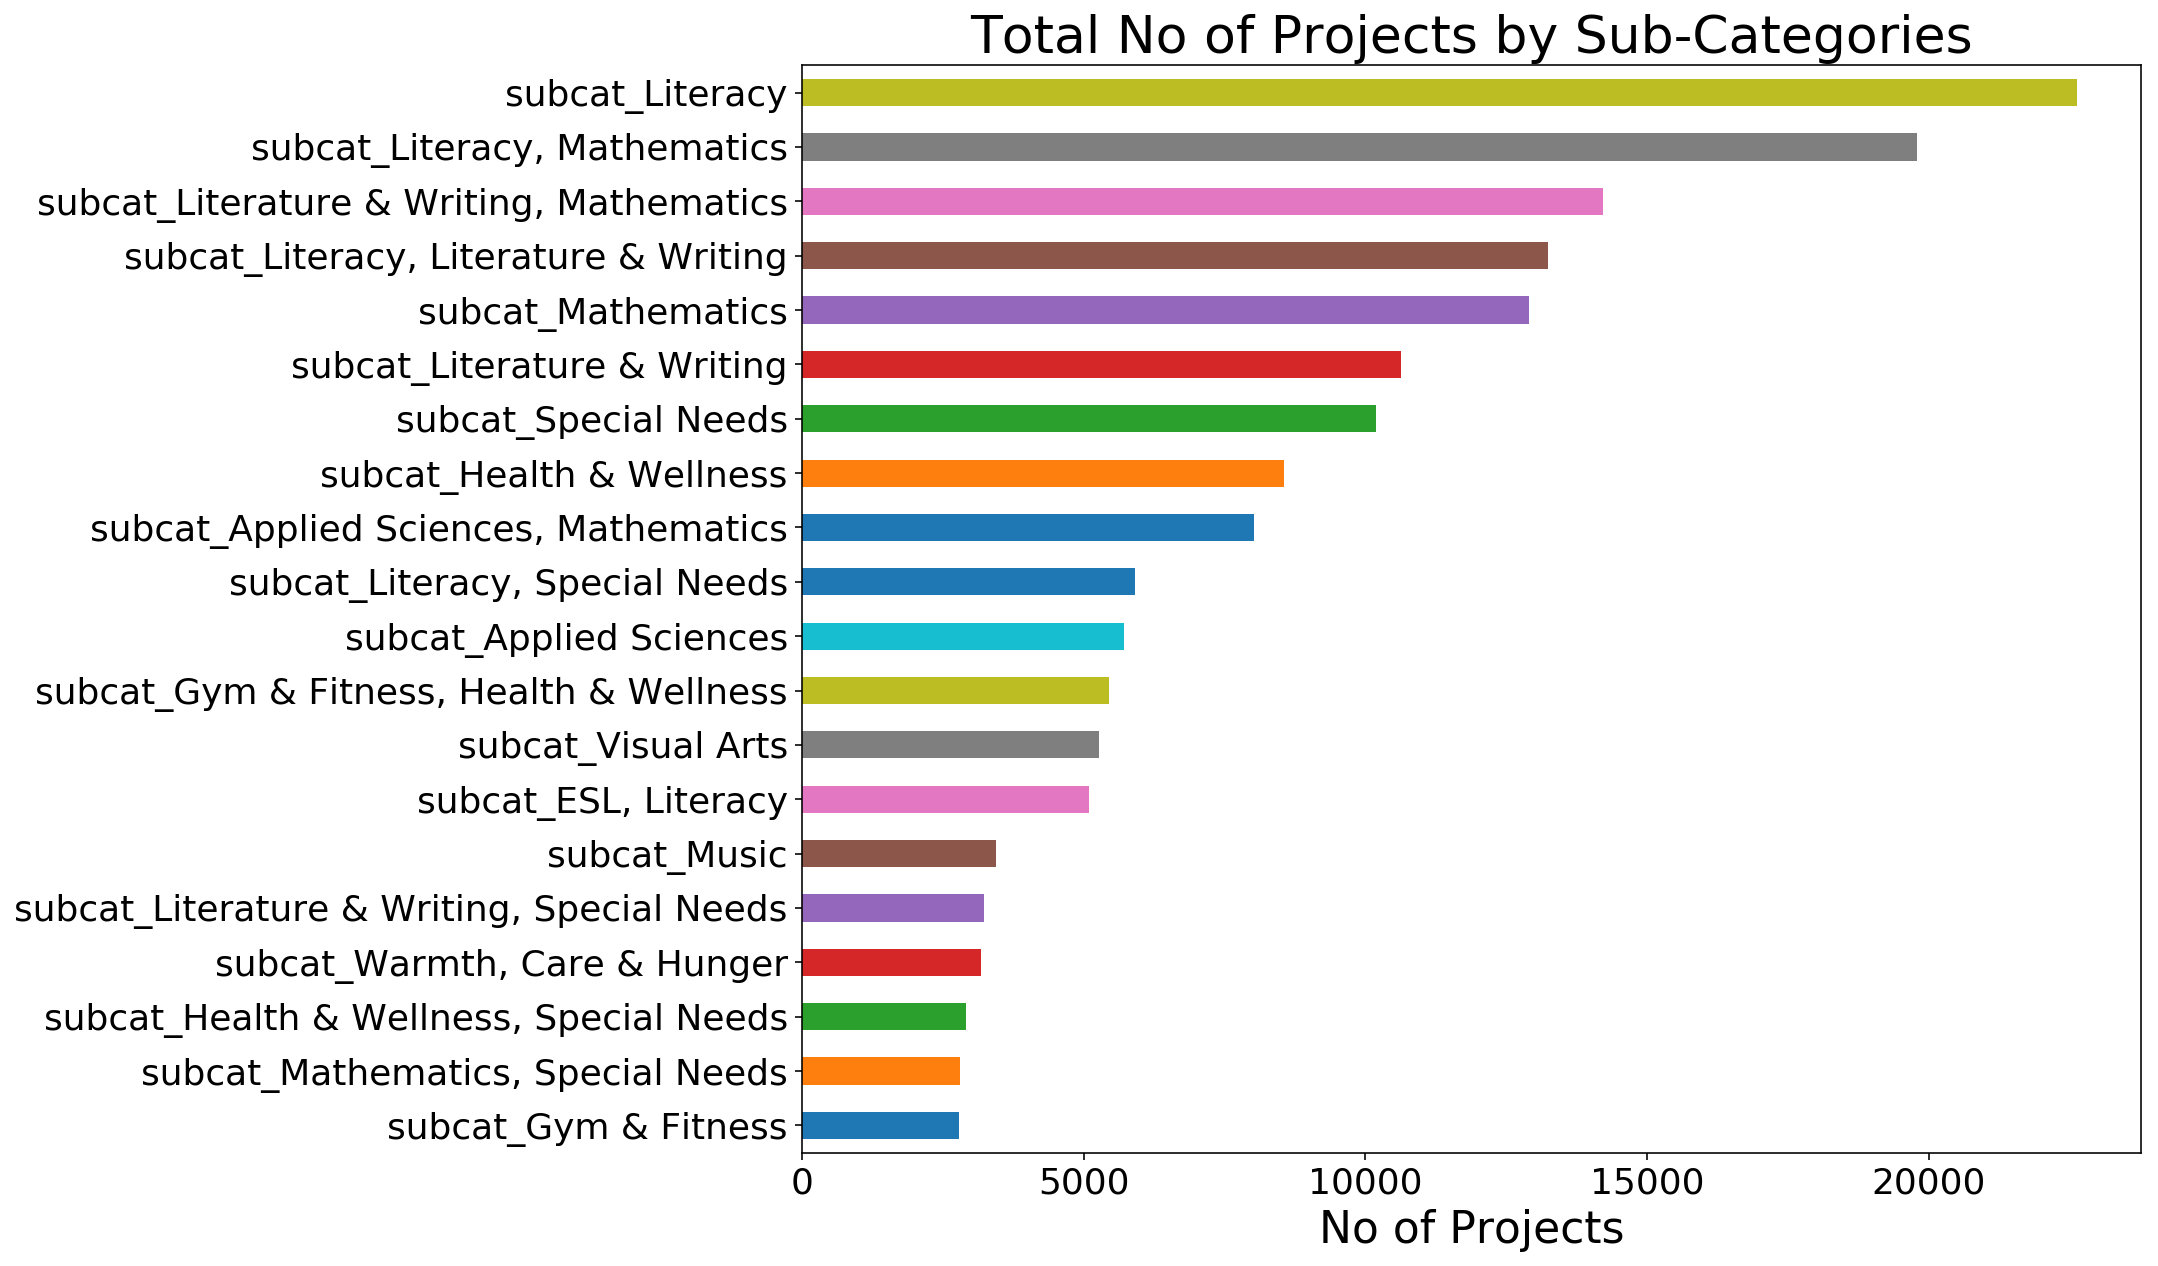

In [60]:
subcat_features.sum().sort_values(ascending=False).head(20) \
                     .sort_values(ascending=True) \
                     .plot(kind='barh', figsize=(12,10), fontsize=18)
plt.title('Total No of Projects by Sub-Categories', fontsize=26)
plt.xlabel('No of Projects', fontsize=22)
plt.show()

In [61]:
subcat_temp = whole_df[~whole_df.project_is_approved.isnull()]

col = subcat_features.columns + ',' + train_df.columns[-1]

In [62]:
whole_df.groupby('project_subject_categories')['project_subject_subcategories'].unique()[0]

array(['Early Development, Extracurricular', 'Extracurricular',
       'Early Development', 'Other', 'College & Career Prep, Other',
       'Parent Involvement', 'Community Service', 'College & Career Prep',
       'College & Career Prep, Parent Involvement', 'Character Education',
       'Early Development, Other', 'Character Education, Extracurricular',
       'Character Education, Early Development',
       'Community Service, Parent Involvement',
       'College & Career Prep, Extracurricular',
       'Character Education, Other',
       'Character Education, College & Career Prep',
       'Community Service, Extracurricular',
       'Character Education, Community Service', 'Extracurricular, Other',
       'Community Service, Early Development',
       'Other, Parent Involvement',
       'College & Career Prep, Community Service',
       'College & Career Prep, Early Development',
       'Early Development, Parent Involvement',
       'Character Education, Parent Involvement',
   

### 5.4 Oberving if School state should be added as features

In [63]:
whole_df.school_state.value_counts().head(10)

CA    36418
TX    17648
NY    17308
FL    14788
NC    12087
IL    10509
GA     9558
SC     9082
MI     7641
PA     7386
Name: school_state, dtype: int64

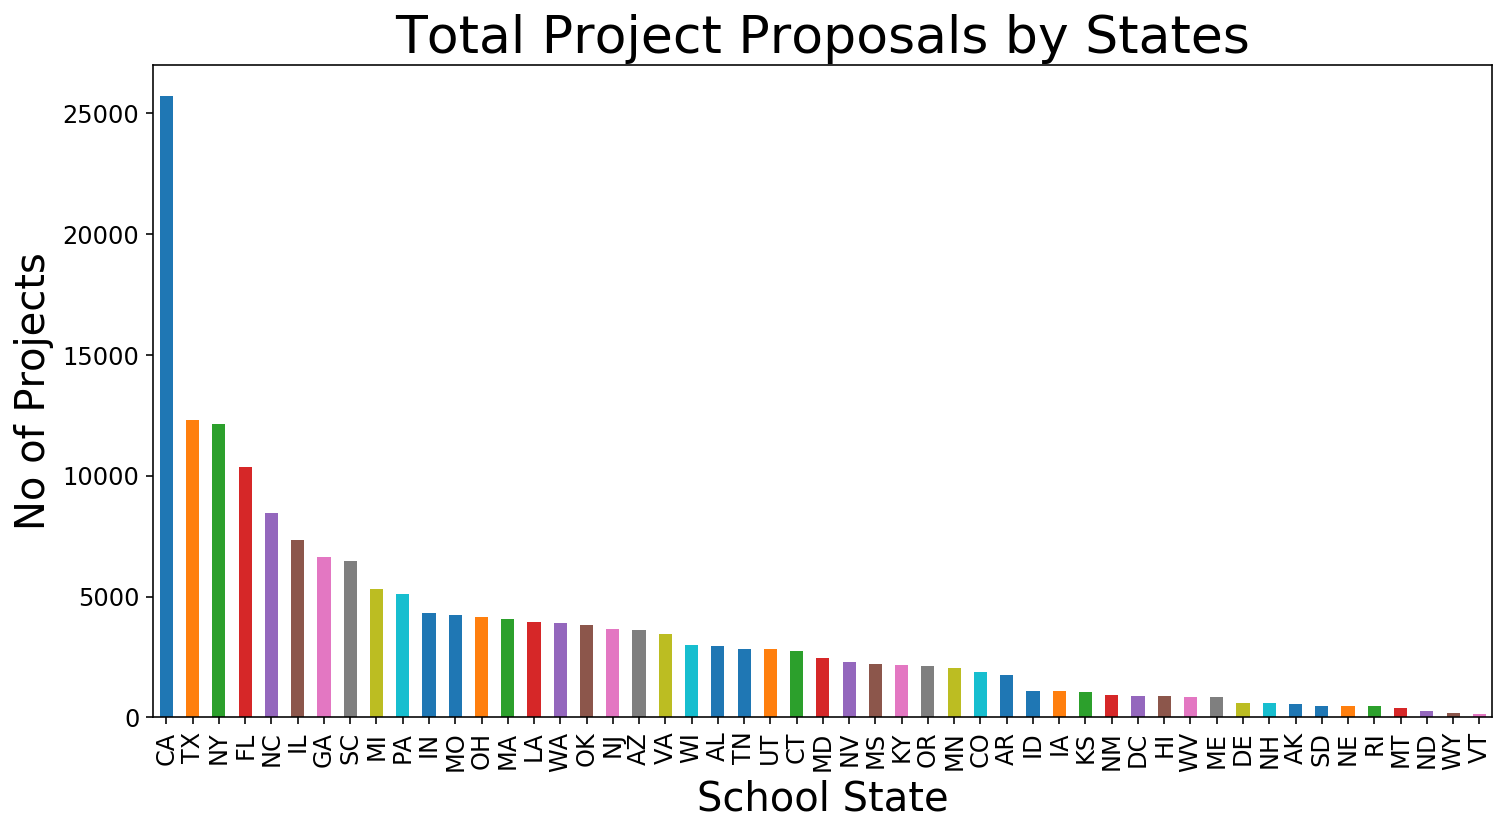

In [64]:
train_df.school_state.value_counts().plot(kind="bar", figsize=(12,6), fontsize=12)
plt.title('Total Project Proposals by States', fontsize=26)
plt.xlabel('School State', fontsize=20)
plt.ylabel('No of Projects', fontsize=20)
plt.show()

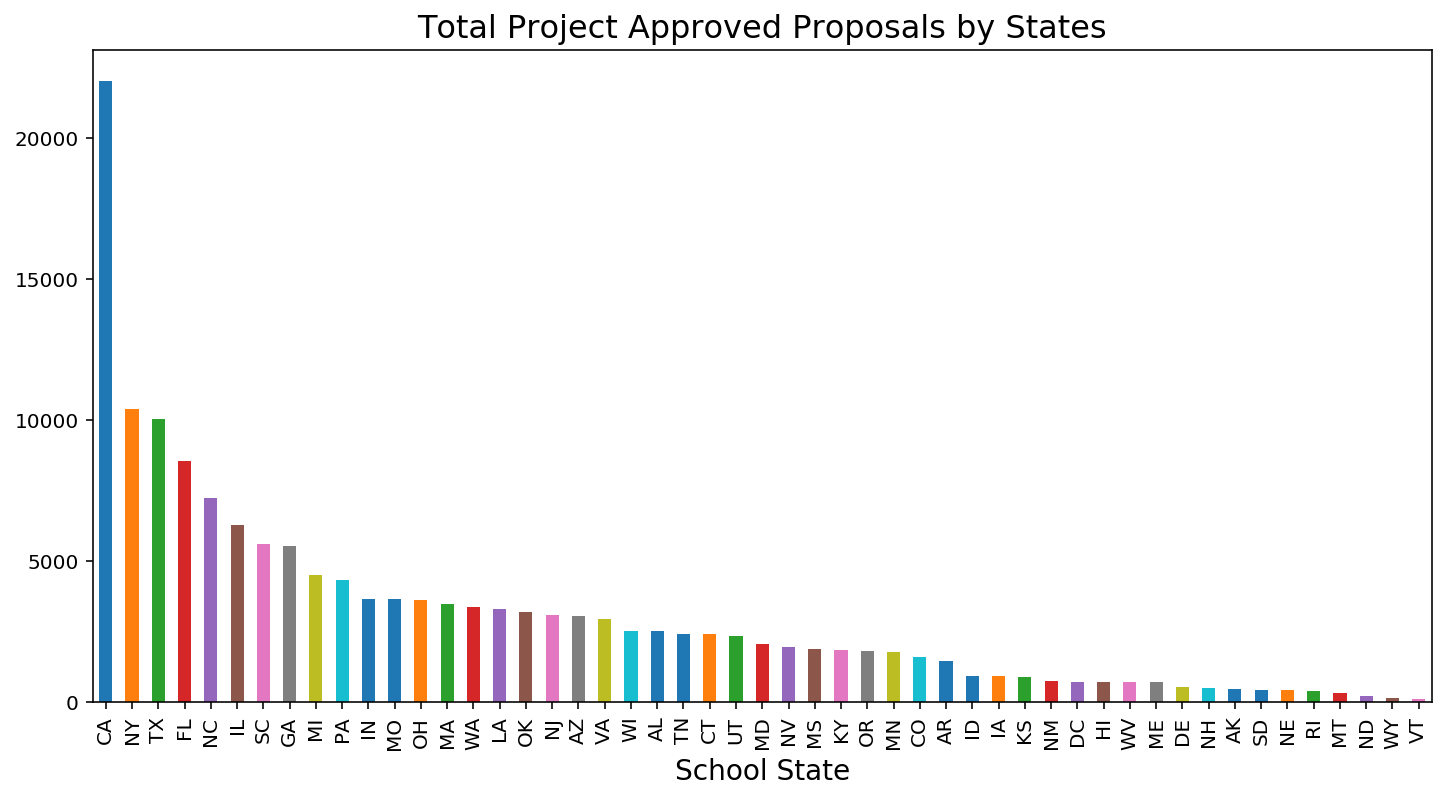

In [65]:
train_df.groupby(['school_state'])['project_is_approved'].sum() \
                                                         .sort_values(ascending=False) \
                                                         .plot(kind="bar", 
                                                                     figsize=(12,6), 
                                                                     fontsize=10)
plt.title('Total Project Approved Proposals by States', fontsize=16)
plt.xlabel('School State', fontsize=14)
plt.show()

In [66]:
sch_state_percentage = ((train_df.groupby(['school_state'])['project_is_approved'].sum() / \
 train_df.school_state.value_counts()) * 100)
print(sch_state_percentage.max())
print(sch_state_percentage.min())
print(sch_state_percentage.mean())

89.13412563667232
81.26385809312639
84.97125461994654


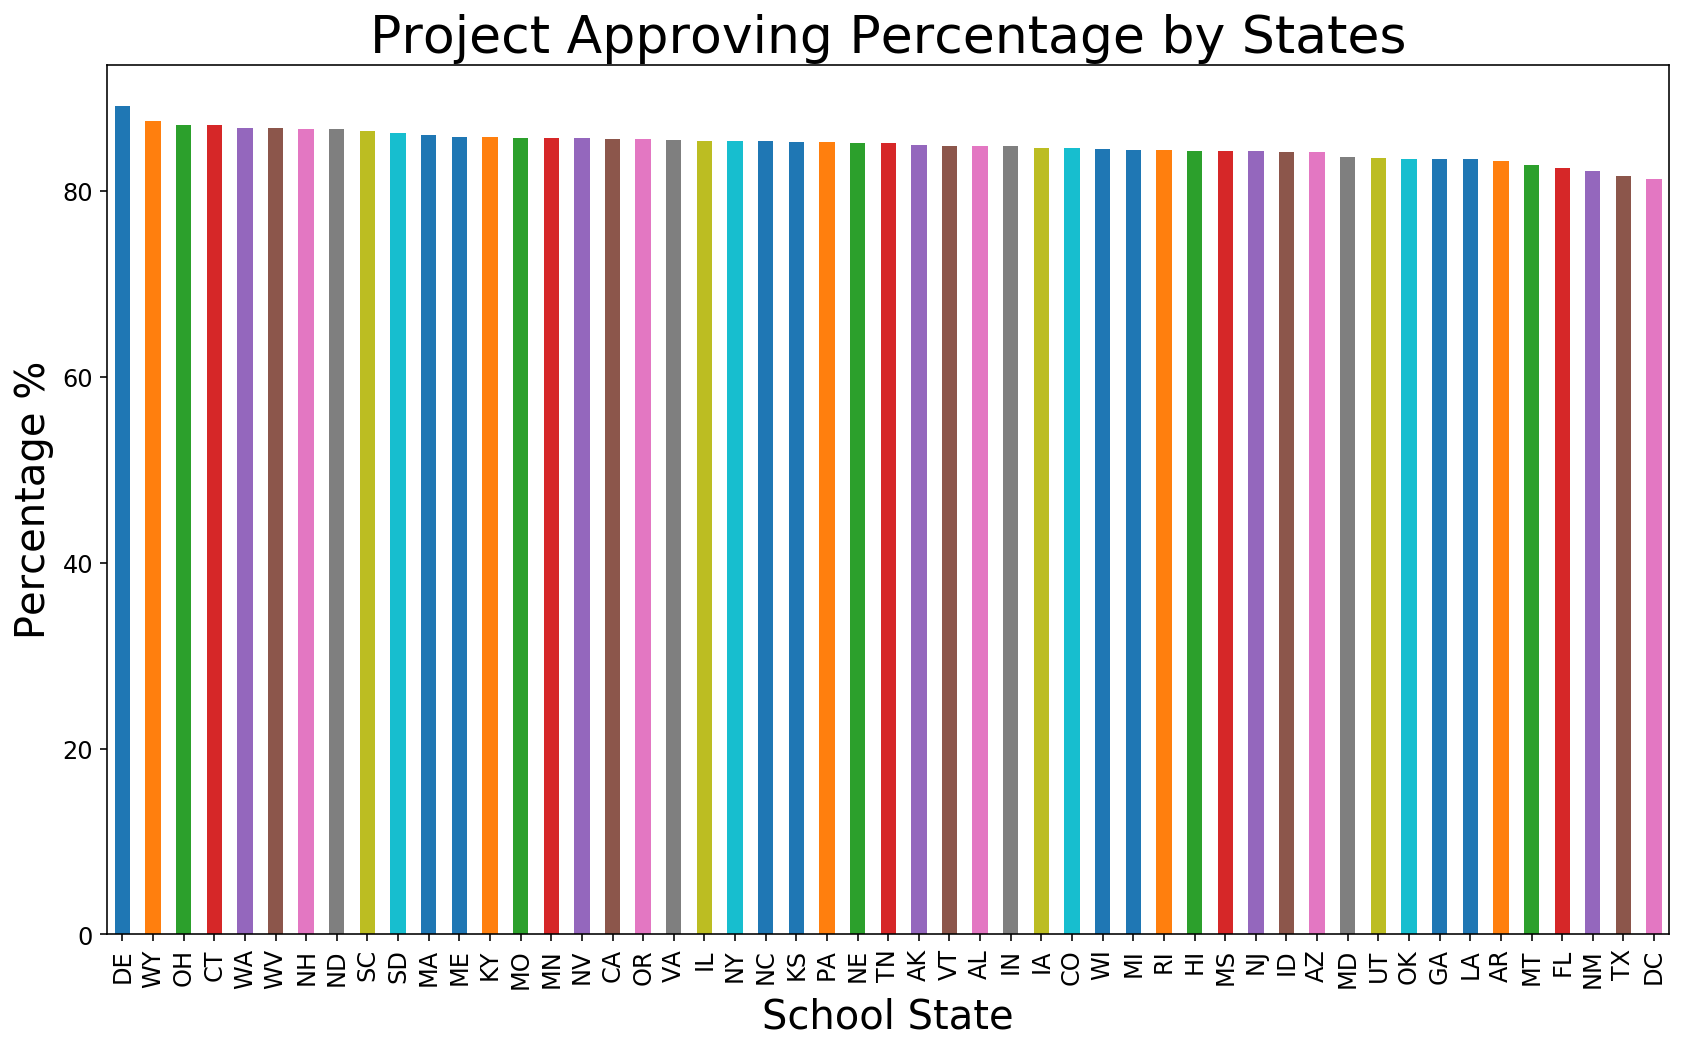

In [67]:
((train_df.groupby(['school_state'])['project_is_approved'].sum() / \
 train_df.school_state.value_counts()) * 100).sort_values(ascending=False) \
.plot(kind='bar', figsize=(14,8), fontsize=12)
plt.title('Project Approving Percentage by States', fontsize=26)
plt.xlabel('School State', fontsize=20)
plt.ylabel('Percentage %', fontsize=20)
plt.show()

In [68]:
# According to above finding, School State doesn't have effects on project proposal 
# approving since the approval % for each states are nearly the same.

In [69]:
sch_state_features = pd.get_dummies(whole_df.school_state, prefix = 'sch_state')
sch_state_features.drop(['sch_state_VT'], axis=1, inplace = True)
# whole_df = pd.concat([whole_df,sch_state_dummy],axis=1)
# whole_df.head()

### 5.5 Observing the proposal date and time

In [70]:
train_temp.project_submitted_datetime = pd.to_datetime(train_temp.project_submitted_datetime)
train_temp.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title  \
0                                Literacy  Super Sight Word Centers   
1            Performing Arts, Team Sports    Keep Calm and Dance On   
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                            26                    1  
1                                             1                    0  
2                                             5                    1

In [71]:
train_temp['date'] = train_temp.project_submitted_datetime.dt.date
train_temp['year'] = train_temp.project_submitted_datetime.dt.year
train_temp['month'] = train_temp.project_submitted_datetime.dt.month
train_temp['day'] = train_temp.project_submitted_datetime.dt.day
train_temp['time'] = train_temp.project_submitted_datetime.dt.time

In [72]:
train_temp.head()

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.    male   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.    male   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   
3           NC        2016-08-12 15:42:11             Grades 3-5   
4           CA        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title    ...     \
0                           Super Sight Word Centers    ...      
1                             Keep Calm and Dance On    ...      
2                              Lets 3Doodle to Learn    ...      
3  \"Kid Inspired\" Equipment to Increase Activit...    ...      
4   We need clean water for our culinary arts class!    ...      

  project_essay_3 project_essay_4  \
0             NaN             NaN   
1             NaN             NaN   
2             NaN             NaN   
3             NaN             NaN   
4             NaN             NaN   

                            project_resource_summary  \
0  My students need 6 Ipod Nano's to create and d...   
1  My students need matching shirts to wear for d...   
2  My students need the 3doodler. We are an SEM s...   
3  My students need balls and other activity equi...   
4  My students need a water filtration system for...   

  teacher_number_of_previously_posted_projects project_is_approved  \
0                                           26                   1   
1                                            1                   0   
2                                            5                   1   
3                                           16                   0   
4                                           42                   1   

         date  year month  day      time  
0  2016-11-18  2016    11   18  14:45:59  
1  2017-04-26  2017     4   26  15:57:28  
2  2017-01-01  2017     1    1  22:57:44  
3  2016-08-12  2016     8   12  15:42:11  
4  2016-08-06  2016     8    6  09:09:11  

[5 rows x 22 columns]

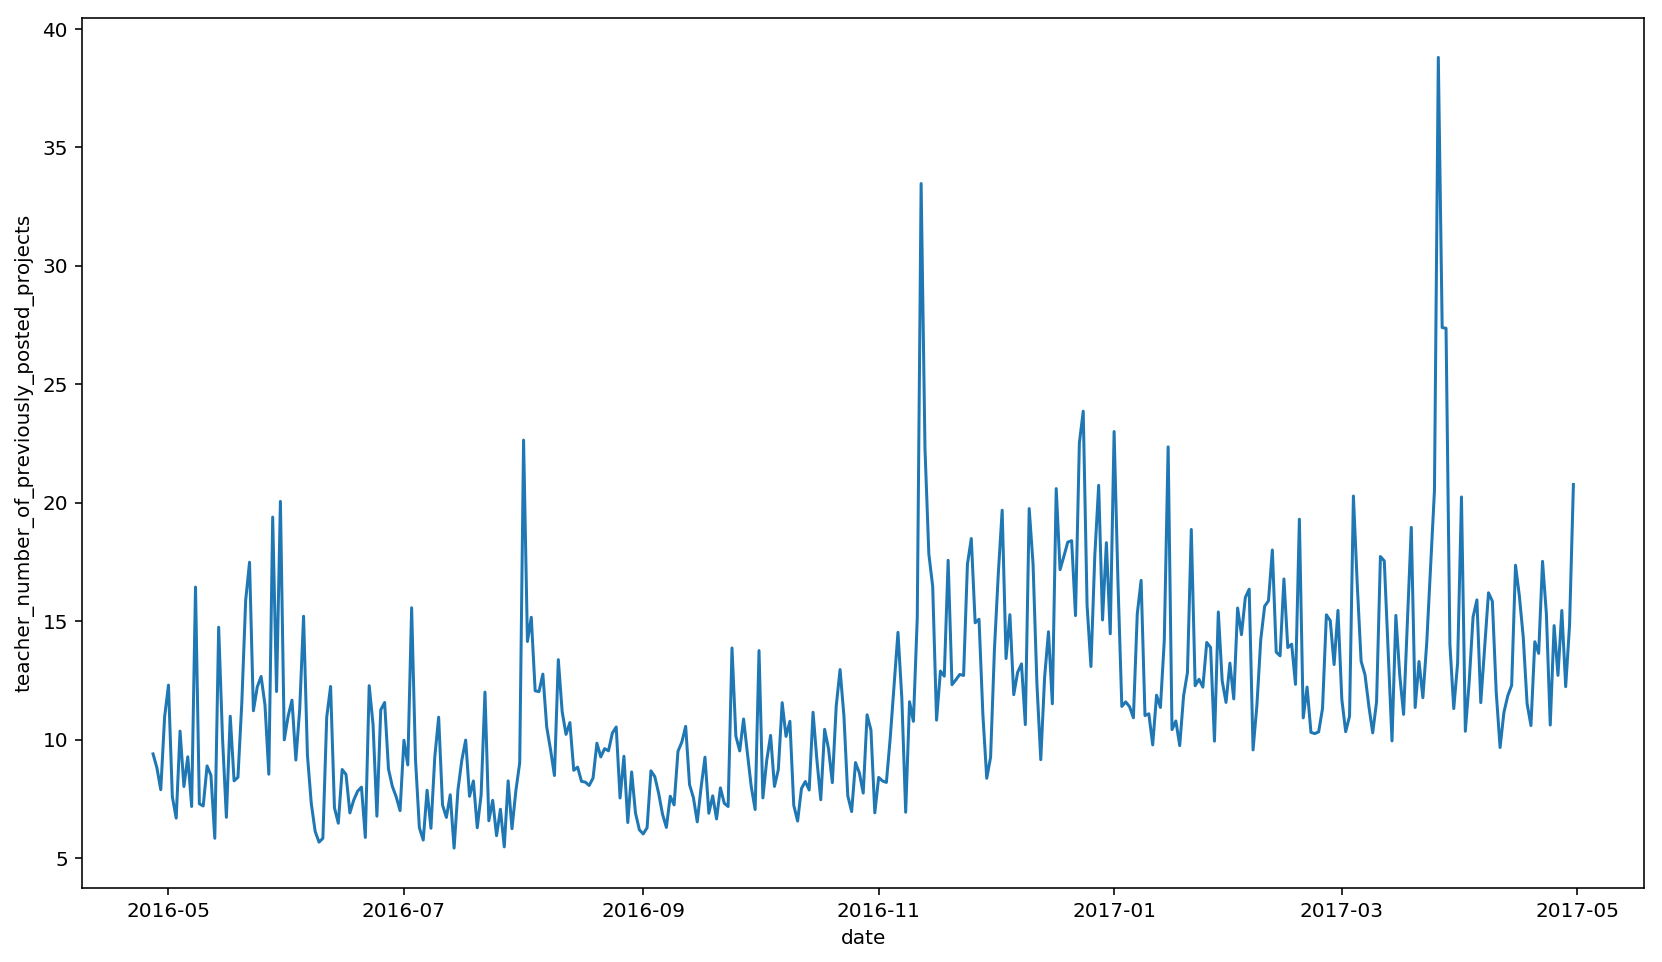

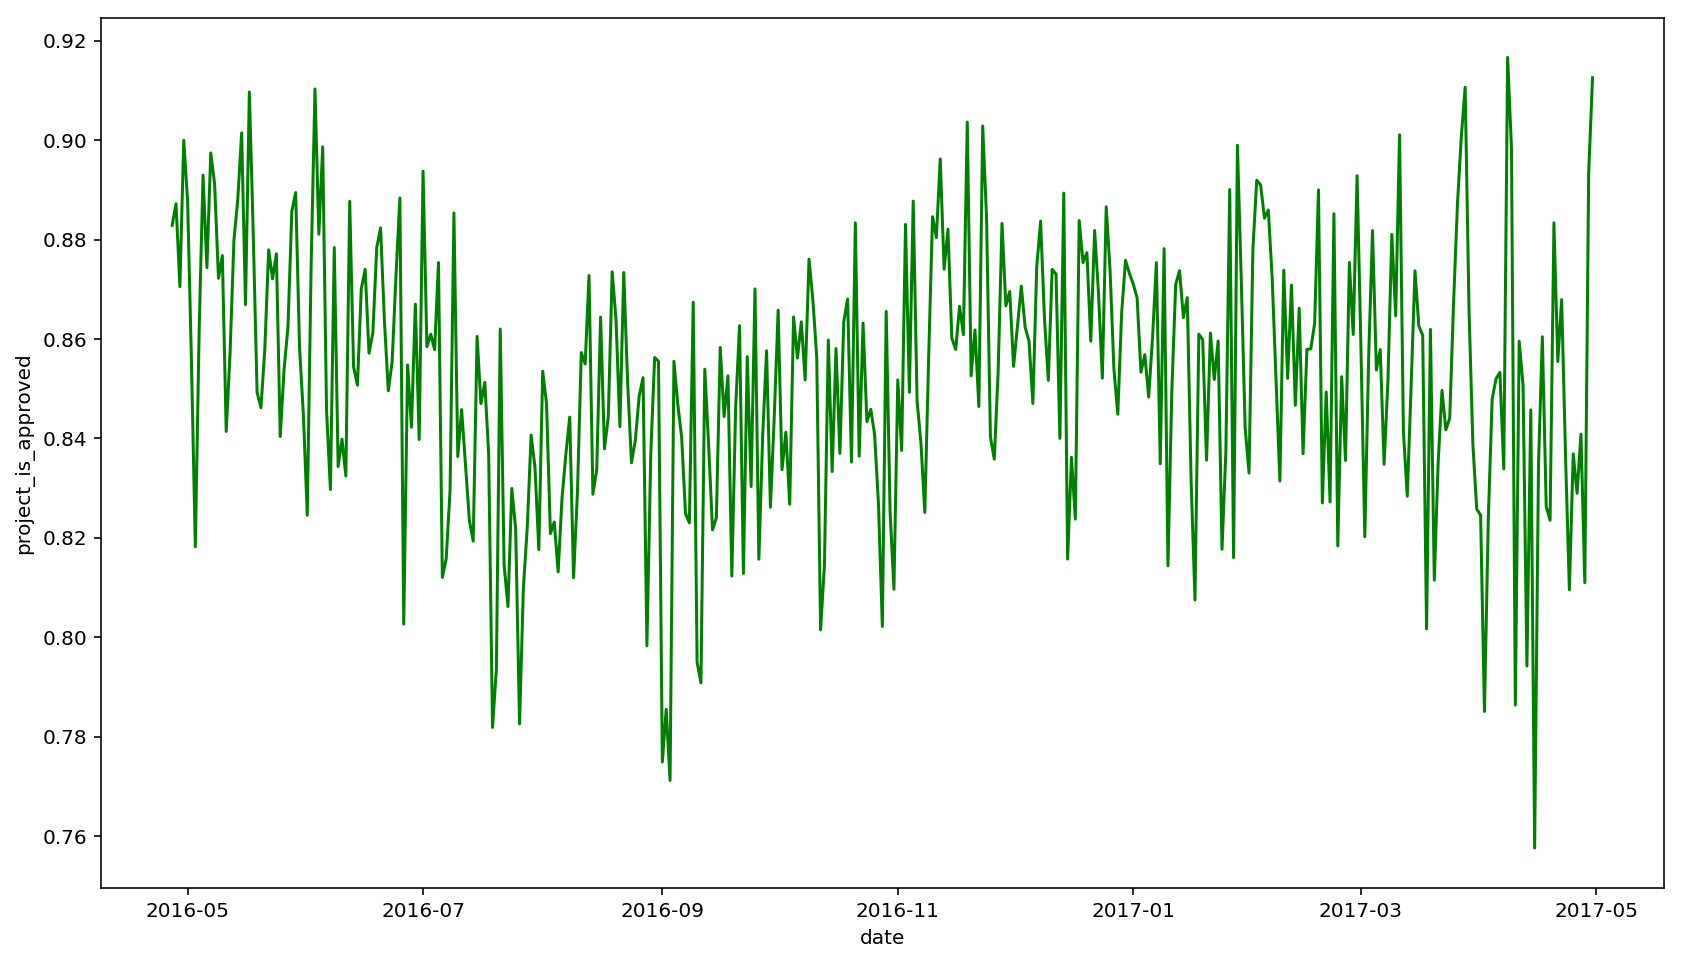

In [73]:
plt.figure(figsize = (14,8))
ax = sns.lineplot(x=train_temp.date, y=train_temp.teacher_number_of_previously_posted_projects, 
                  err_style=None)
plt.show()

plt.figure(figsize = (14,8))
ax = sns.lineplot(x=train_temp.date, y=train_temp.project_is_approved, 
                 color='Green', err_style=None)
plt.show()

In [74]:
def checking_feature(feature):
    train_temp[feature].value_counts().sort_index(ascending=True).plot(kind="bar", figsize=(12,6), fontsize=18, rot=1)
    plt.title('Total Project Proposals by {}'.format(feature), fontsize=22)
    plt.xlabel('{}'.format(feature), fontsize=20)
    plt.show()

    train_temp.groupby([feature])['project_is_approved'].sum() \
                                                     .plot(kind="bar", figsize=(12,6), 
                                                        fontsize=18, rot = 1)
    plt.title('Total Approved Project Proposals by {}'.format(feature), fontsize=22)
    plt.xticks()
    plt.xlabel('{}'.format(feature), fontsize=20)
    plt.show()

    ((train_temp.groupby([feature])['project_is_approved'].sum() / \
     train_temp[feature].value_counts()) * 100) \
    .plot(kind='bar', figsize=(12,6), fontsize=18, rot = 1)
    plt.title('Project Approving Percentage by {}'.format(feature), fontsize=22)
    plt.xlabel('{}'.format(feature), fontsize=20)
    plt.show()

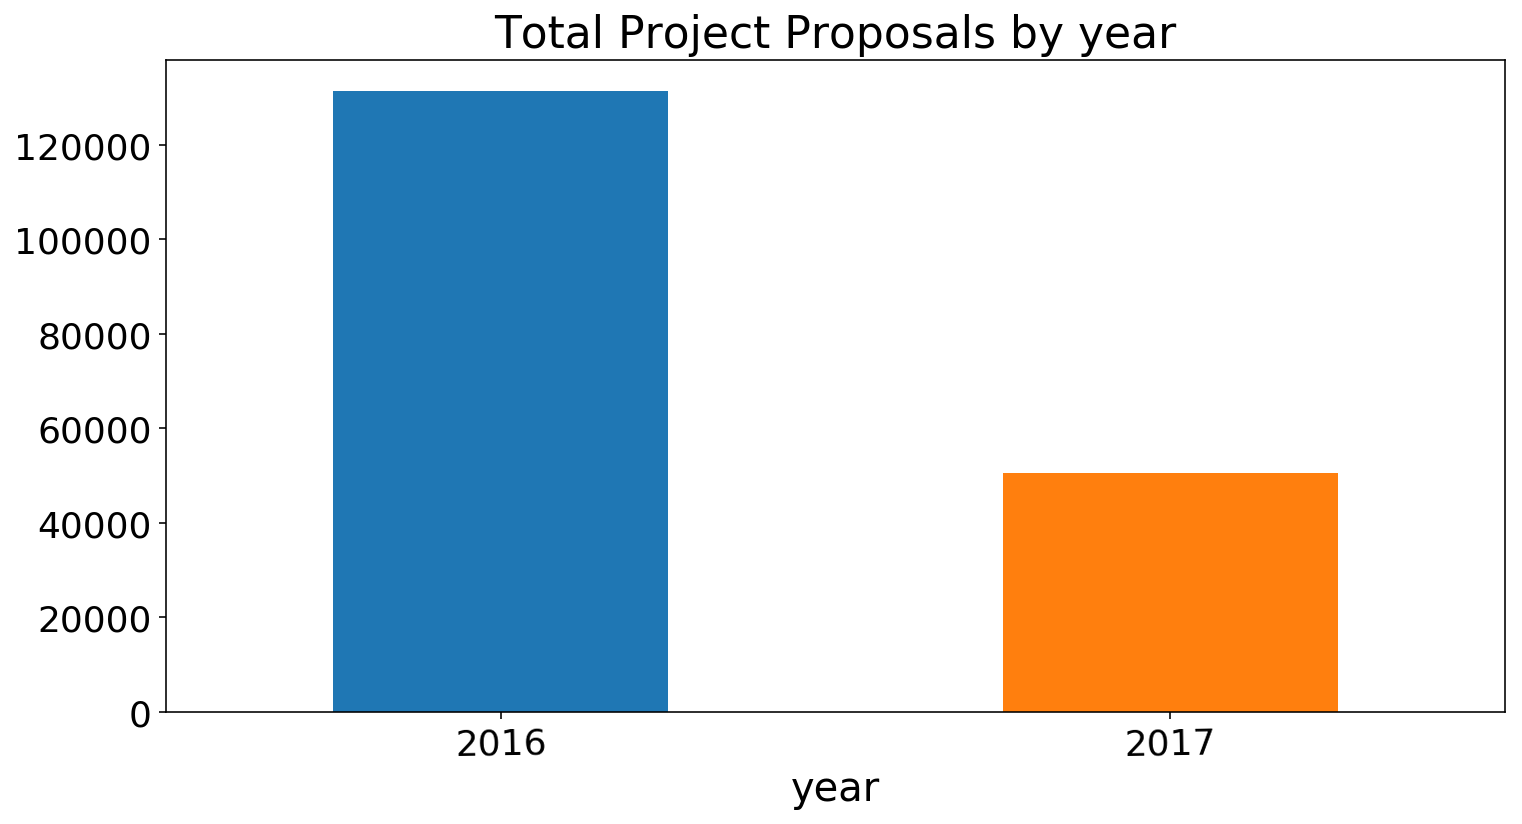

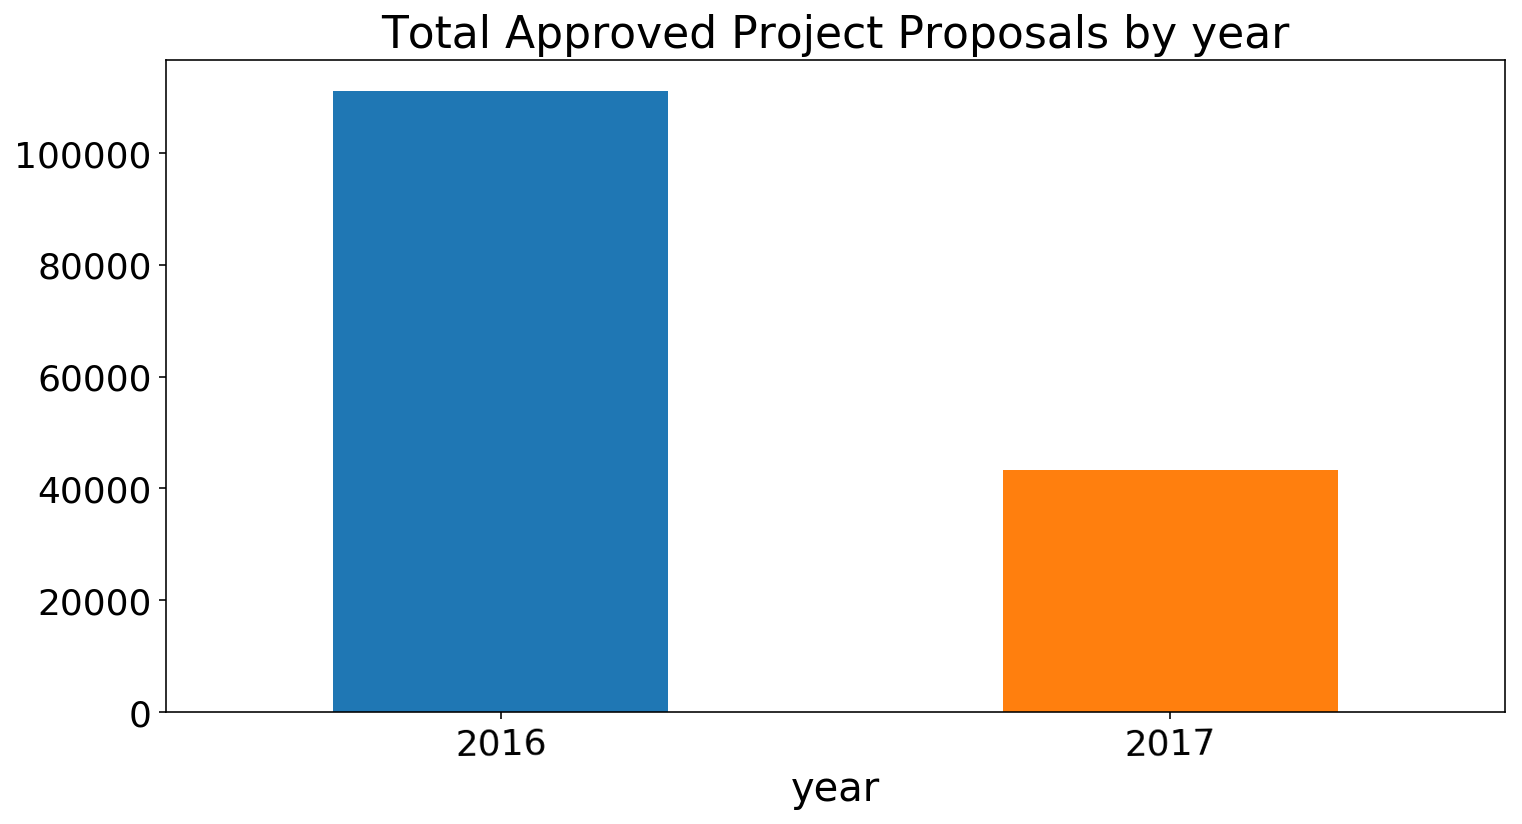

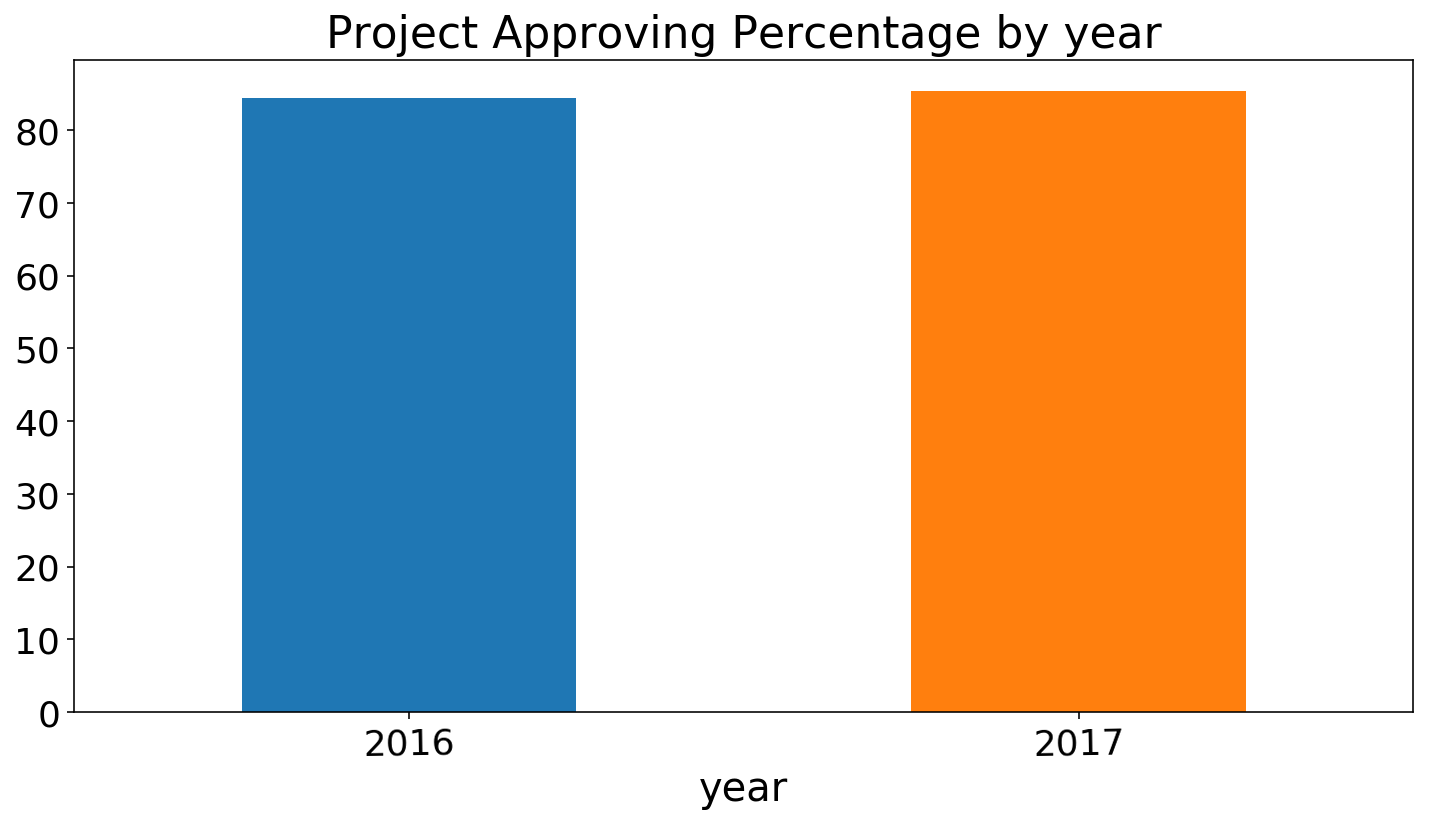

In [75]:
checking_feature('year')

In [76]:
((train_temp.groupby(['month'])['project_is_approved'].sum() / \
     train_temp['month'].value_counts()) * 100)

1     85.186409
2     86.156528
3     86.022727
4     84.613955
5     86.620962
6     85.868965
7     82.816448
8     84.247109
9     82.242431
10    84.633786
11    86.422281
12    86.314929
dtype: float64

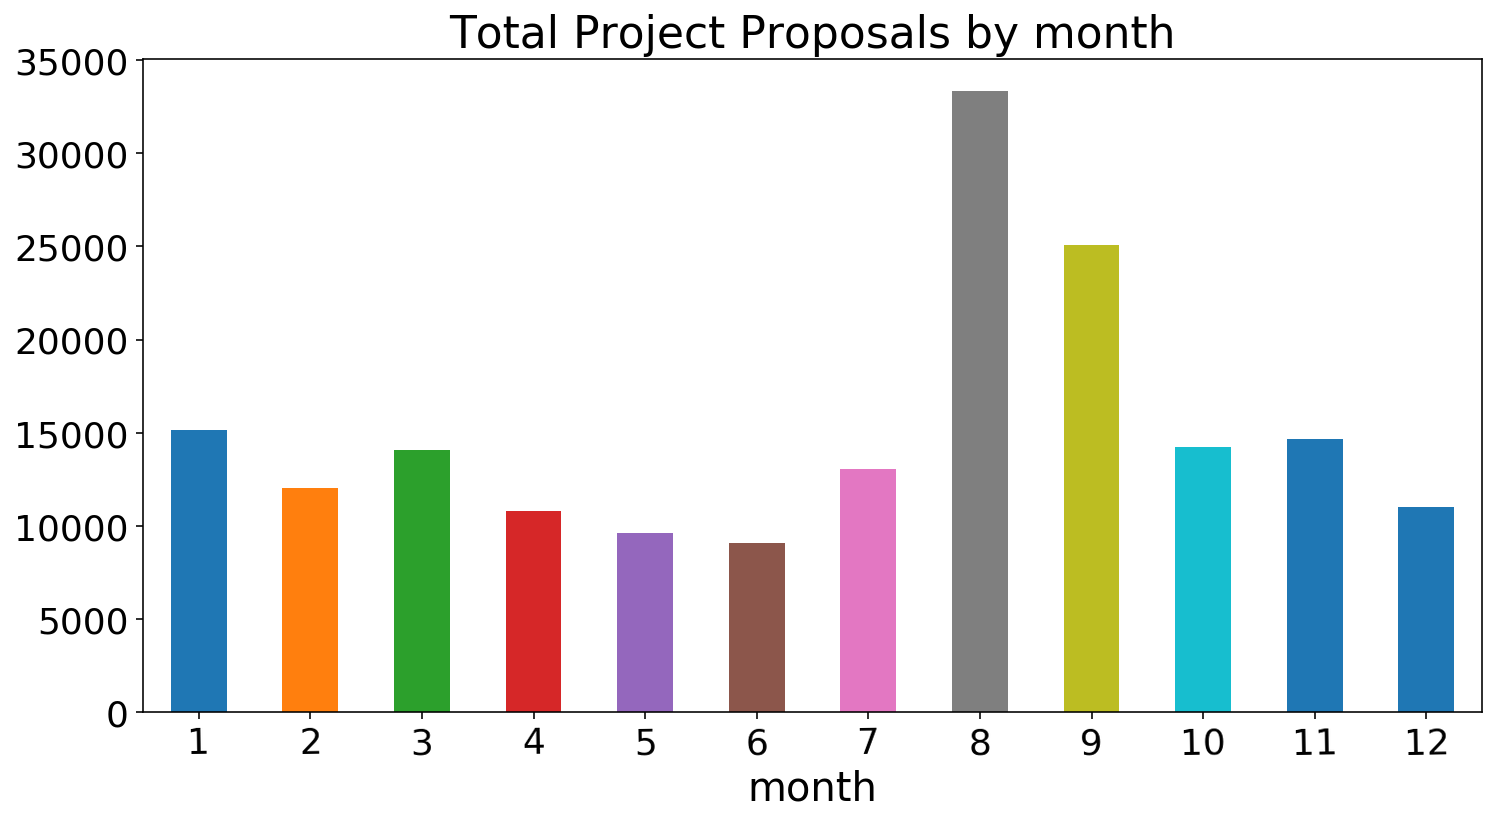

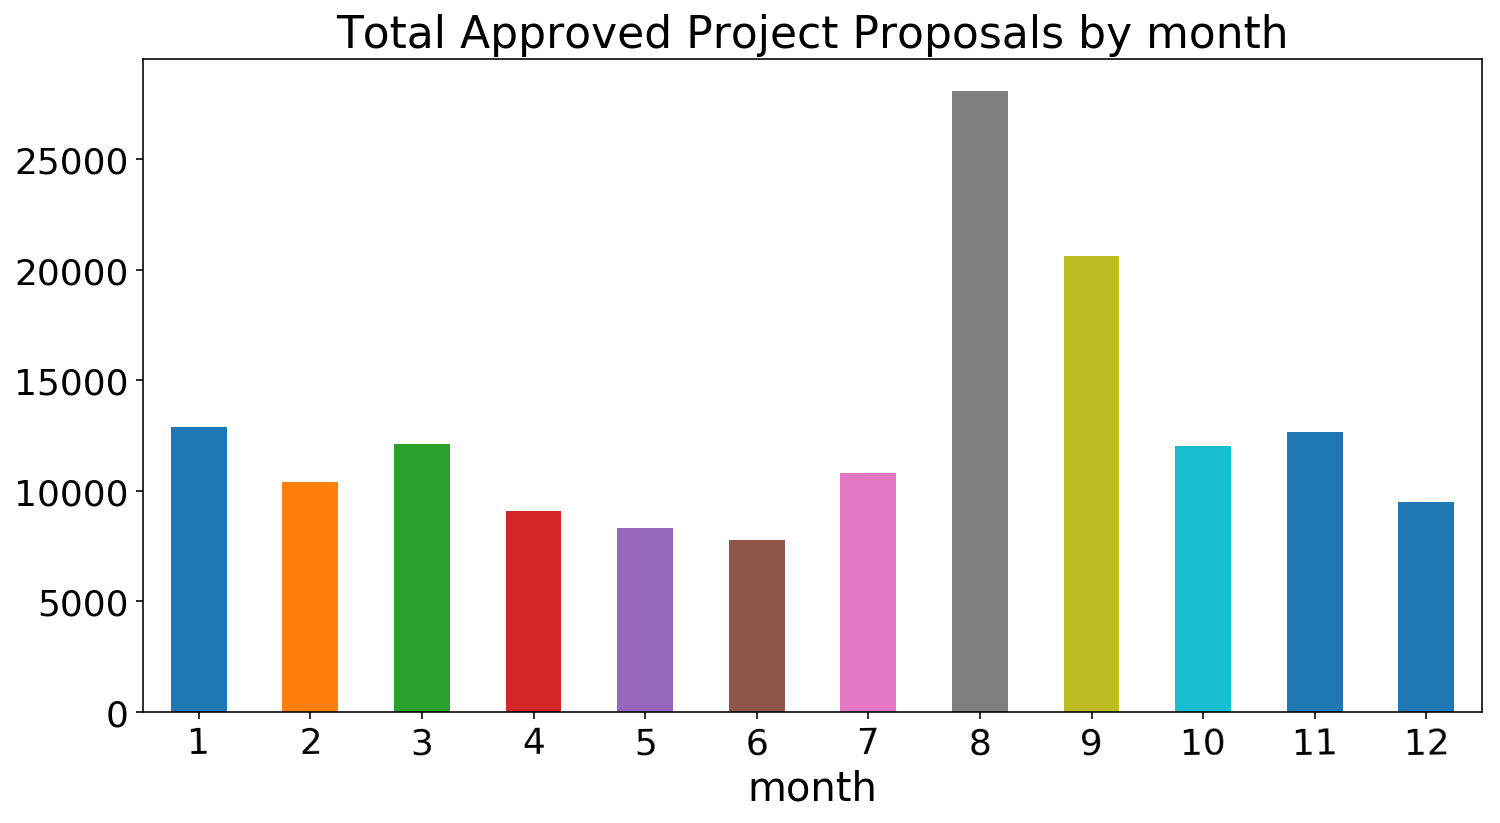

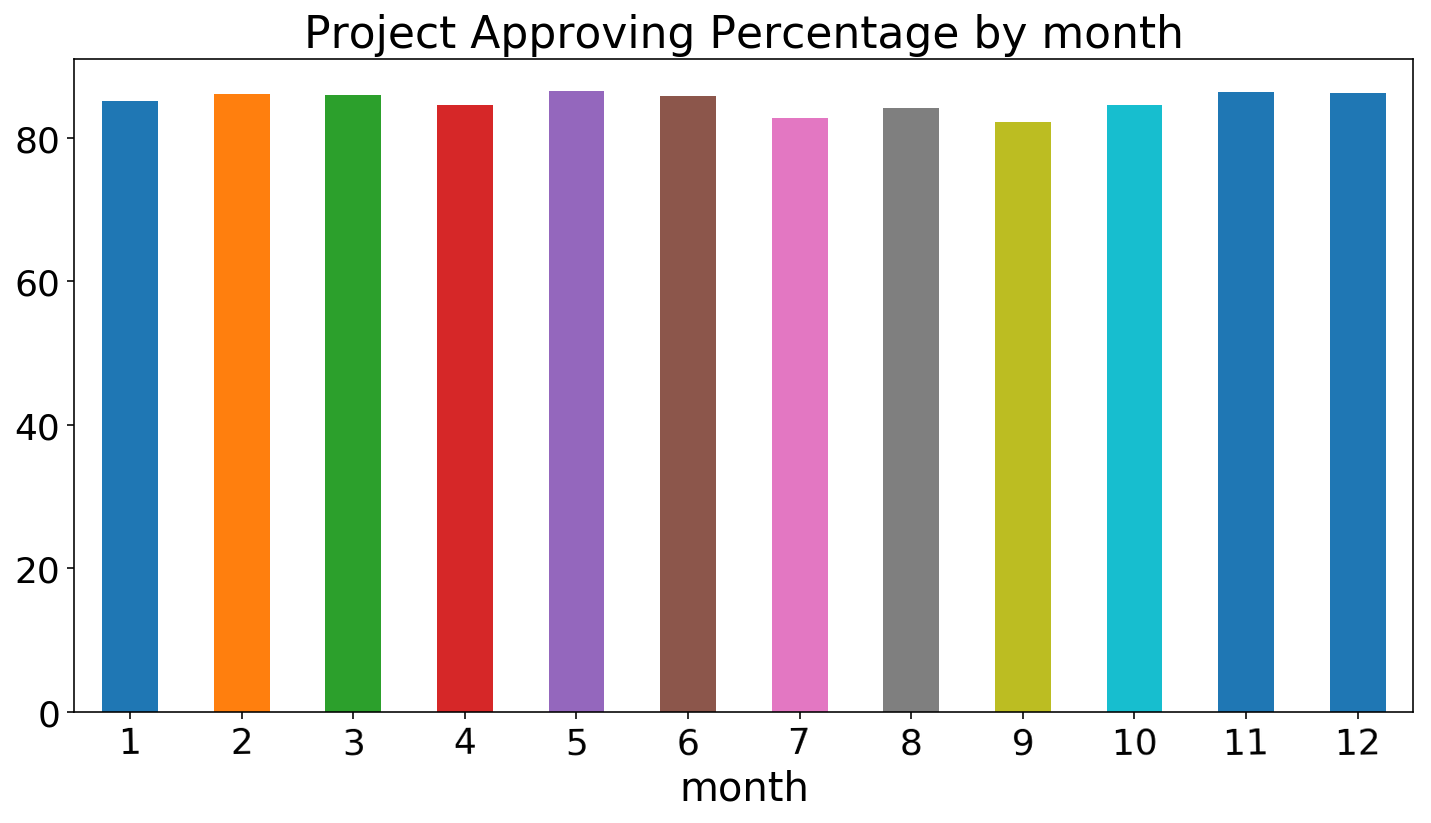

In [77]:
checking_feature('month')

In [78]:
((train_temp.groupby(['day'])['project_is_approved'].sum() / \
     train_temp['day'].value_counts()) * 100)

1     82.364532
2     83.839260
3     83.868905
4     84.875000
5     85.329997
6     84.688555
7     84.390410
8     84.657635
9     86.124567
10    83.745214
11    85.010823
12    85.350434
13    84.797768
14    84.802933
15    84.844010
16    85.694588
17    84.828179
18    85.435861
19    84.728882
20    84.761905
21    85.512935
22    85.329513
23    85.339623
24    84.111583
25    84.437733
26    84.202321
27    84.831639
28    86.225026
29    85.746827
30    85.338346
31    83.895662
dtype: float64

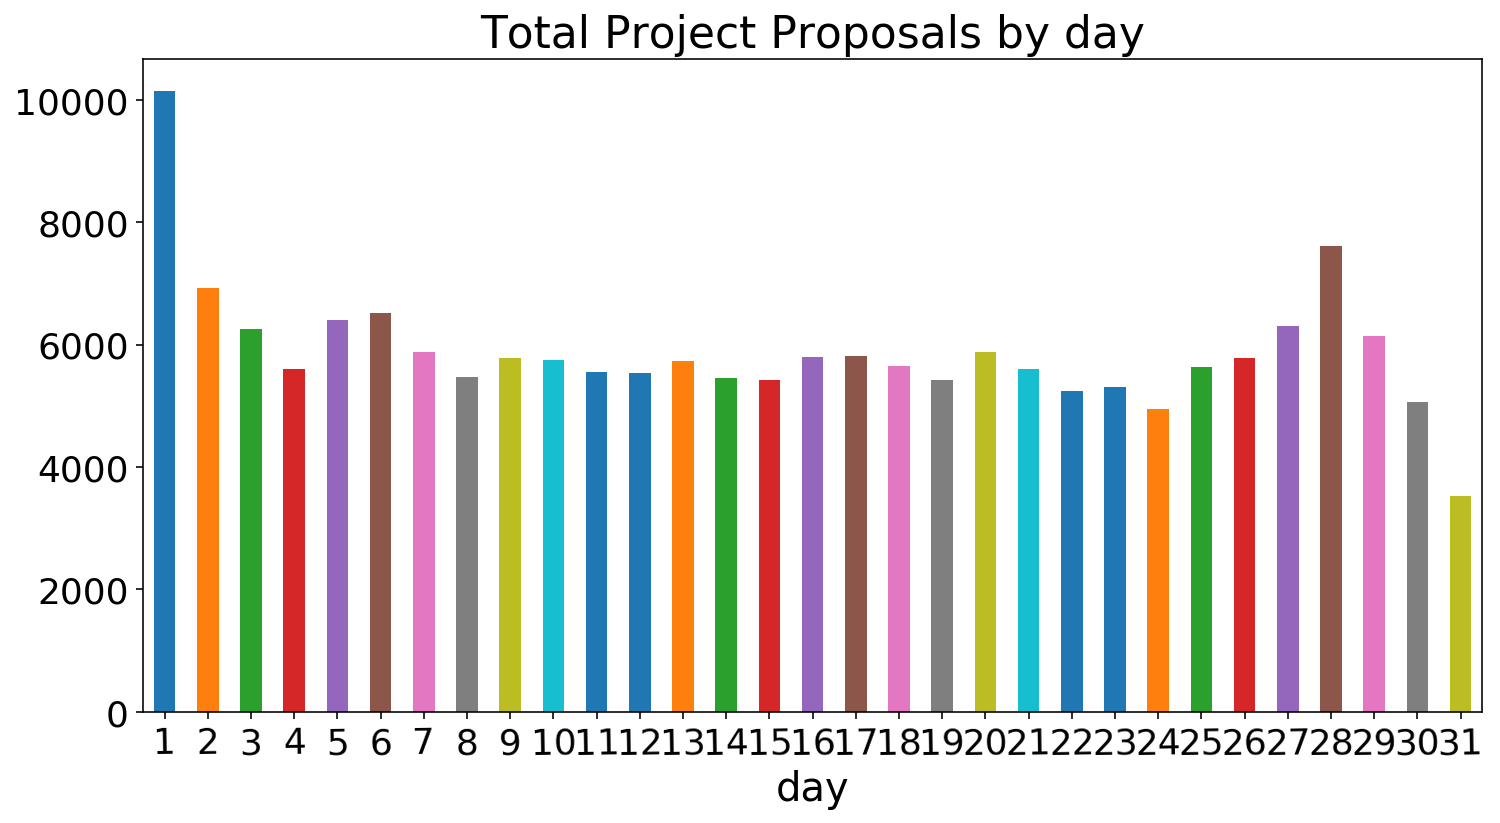

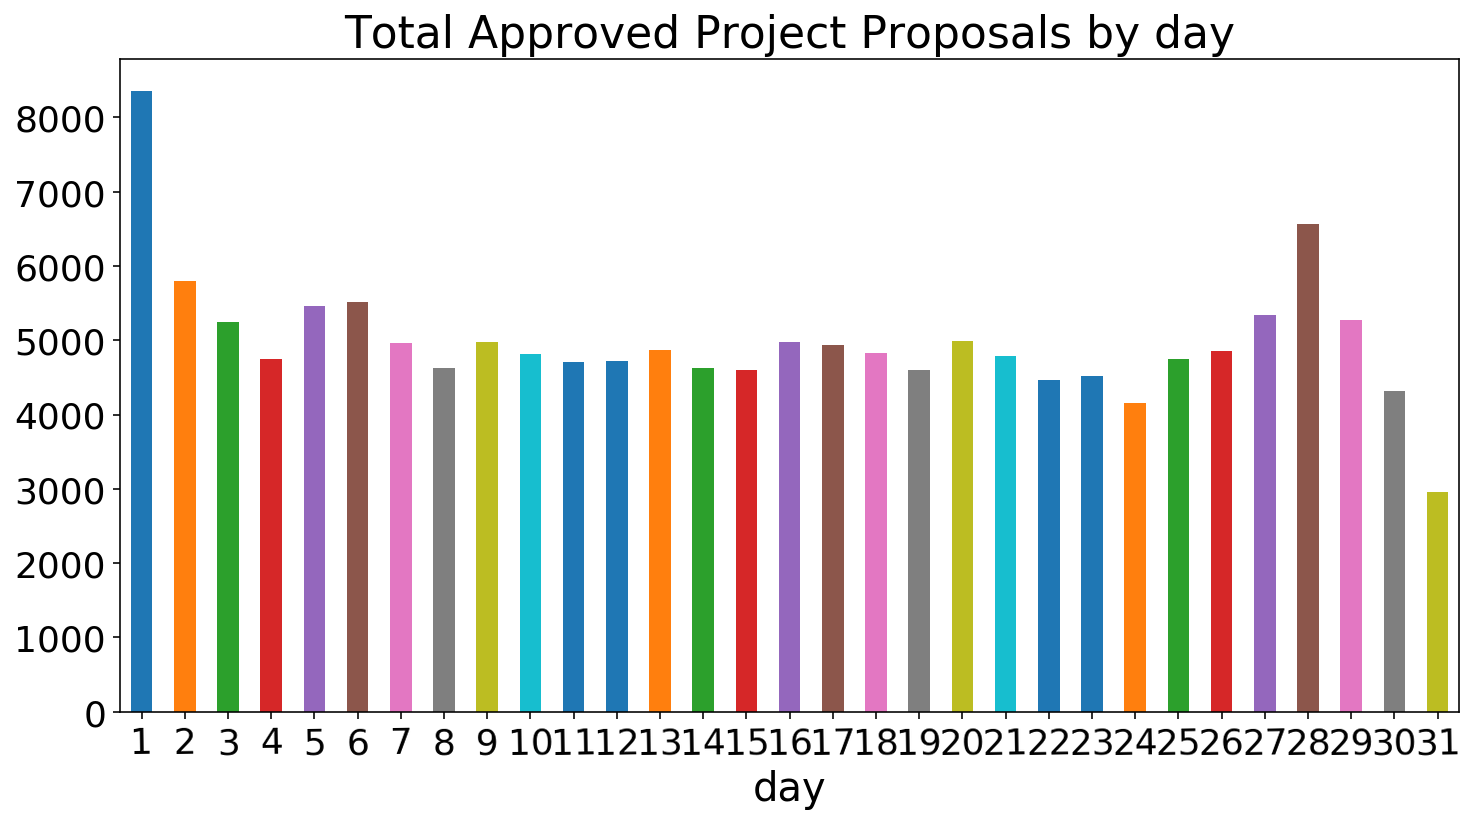

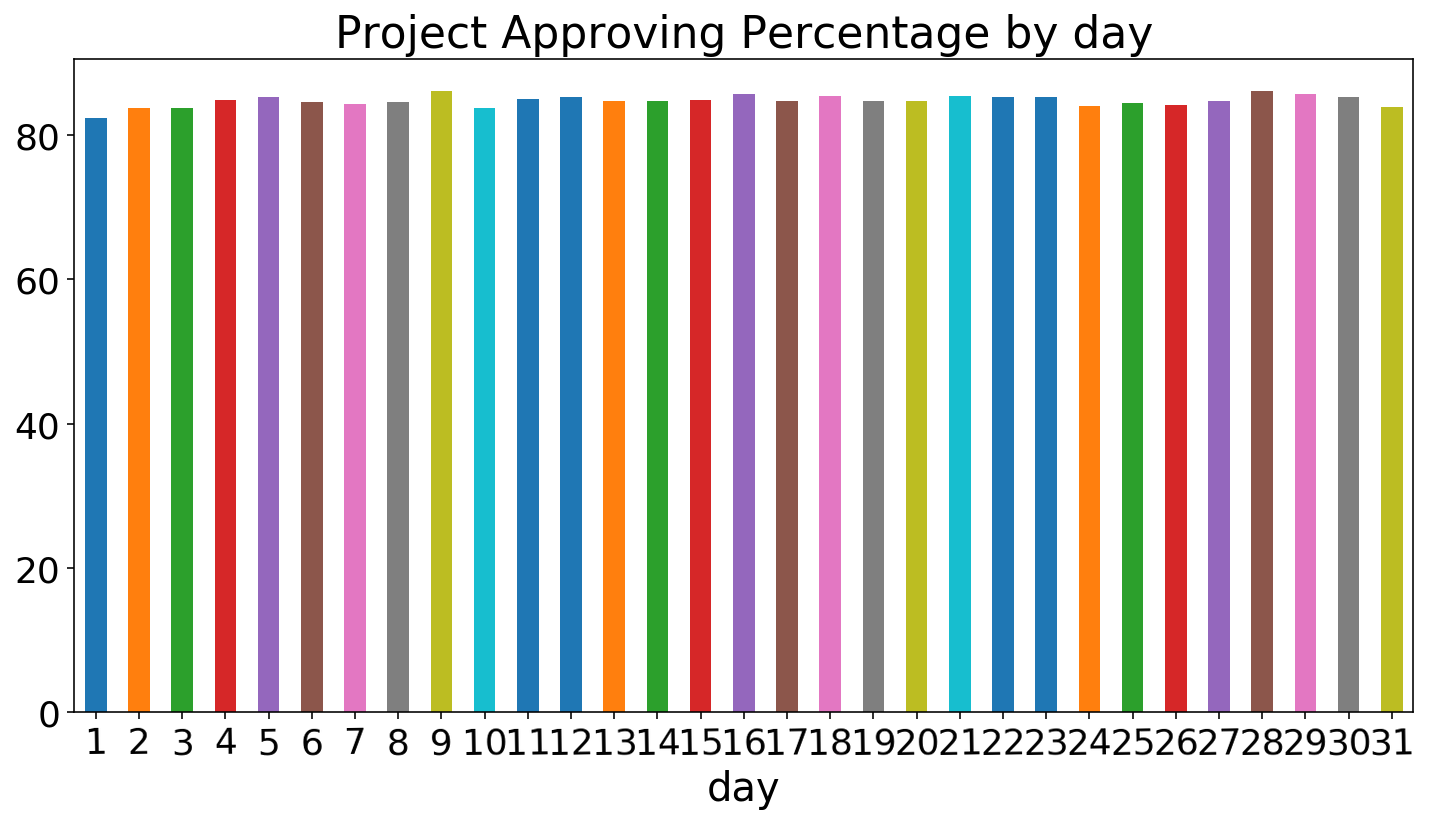

In [79]:
checking_feature('day')

In [80]:
whole_df['month'] = whole_df.project_submitted_datetime.dt.month
whole_df['day'] = whole_df.project_submitted_datetime.dt.day
whole_df.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title  \
0                                Literacy  Super Sight Word Centers   
1            Performing Arts, Team Sports    Keep Calm and Dance On   
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   

   teacher_number_of_previously_posted_projects  project_is_approved  budget  \
0                                            26                  1.0  899.94   
1                                             1                  0.0  400.00   
2                                             5                  1.0  469.99   

   month  day  
0     11   18  
1      4   26  
2      1    1

In [81]:
month_features = pd.get_dummies(whole_df.month, prefix = 'month')
month_features.drop(['month_6'], axis=1, inplace = True)
month_features.head()

month_1  month_2  month_3  month_4  month_5  month_7  month_8  month_9  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        1        0        0        0        0   
2        1        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        1        0   
4        0        0        0        0        0        0        1        0   

   month_10  month_11  month_12  
0         0         1         0  
1         0         0         0  
2         0         0         0  
3         0         0         0  
4         0         0         0

In [82]:
day_features = pd.get_dummies(whole_df.day, prefix = 'day')
day_features.drop(['day_31'], axis=1, inplace = True)
day_features.head()

day_1  day_2  day_3  day_4  day_5  day_6  day_7  day_8  day_9  day_10  \
0      0      0      0      0      0      0      0      0      0       0   
1      0      0      0      0      0      0      0      0      0       0   
2      1      0      0      0      0      0      0      0      0       0   
3      0      0      0      0      0      0      0      0      0       0   
4      0      0      0      0      0      1      0      0      0       0   

    ...    day_21  day_22  day_23  day_24  day_25  day_26  day_27  day_28  \
0   ...         0       0       0       0       0       0       0       0   
1   ...         0       0       0       0       0       1       0       0   
2   ...         0       0       0       0       0       0       0       0   
3   ...         0       0       0       0       0       0       0       0   
4   ...         0       0       0       0       0       0       0       0   

   day_29  day_30  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0  

[5 rows x 30 columns]

### 5.6 Adding Project Essay as features

In [83]:
train_temp.project_essay_1.isnull().value_counts()

False    182080
Name: project_essay_1, dtype: int64

In [84]:
train_temp.project_essay_2.isnull().value_counts()

False    182080
Name: project_essay_2, dtype: int64

In [85]:
# No null value in Project essay 1 and Project essay 2 since it's compulsary to write.

In [86]:
train_temp.project_essay_3.isnull().value_counts()

True     175706
False      6374
Name: project_essay_3, dtype: int64

In [87]:
train_temp.project_essay_4.isnull().value_counts()

True     175706
False      6374
Name: project_essay_4, dtype: int64

In [88]:
sum(train_temp[train_temp.project_essay_3.isnull() == True].index == train_temp[train_temp.project_essay_4.isnull() == True].index)

175706

In [89]:
# Since all the indexes of project_essay_3 and project_essay_4 are same, they are not
# required or necessary to fill up together at some point.
# Besides, I can focus on working either project_essay_3 or 4 to investigate now.

In [90]:
train_temp[train_temp.project_essay_3.isnull()].date.min()

datetime.date(2016, 5, 17)

In [91]:
start_date = datetime.date(2016, 5, 17)
train_temp[train_temp.date > start_date].head(5)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.    male   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.    male   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   
3           NC        2016-08-12 15:42:11             Grades 3-5   
4           CA        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title    ...     \
0                           Super Sight Word Centers    ...      
1                             Keep Calm and Dance On    ...      
2                              Lets 3Doodle to Learn    ...      
3  \"Kid Inspired\" Equipment to Increase Activit...    ...      
4   We need clean water for our culinary arts class!    ...      

  project_essay_3 project_essay_4  \
0             NaN             NaN   
1             NaN             NaN   
2             NaN             NaN   
3             NaN             NaN   
4             NaN             NaN   

                            project_resource_summary  \
0  My students need 6 Ipod Nano's to create and d...   
1  My students need matching shirts to wear for d...   
2  My students need the 3doodler. We are an SEM s...   
3  My students need balls and other activity equi...   
4  My students need a water filtration system for...   

  teacher_number_of_previously_posted_projects project_is_approved  \
0                                           26                   1   
1                                            1                   0   
2                                            5                   1   
3                                           16                   0   
4                                           42                   1   

         date  year month  day      time  
0  2016-11-18  2016    11   18  14:45:59  
1  2017-04-26  2017     4   26  15:57:28  
2  2017-01-01  2017     1    1  22:57:44  
3  2016-08-12  2016     8   12  15:42:11  
4  2016-08-06  2016     8    6  09:09:11  

[5 rows x 22 columns]

In [92]:
# Look like after 17.05.2016, the project proposal format is changed.

In [93]:
whole_df['date'] = whole_df.project_submitted_datetime.dt.date
whole_df.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title  \
0                                Literacy  Super Sight Word Centers   
1            Performing Arts, Team Sports    Keep Calm and Dance On   
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   

      ...                                        project_essay_2  \
0     ...      I currently have a differentiated sight word c...   
1     ...      We strive to provide our diverse population of...   
2     ...      We are looking to add some 3Doodler to our cla...   

  project_essay_3 project_essay_4  \
0             NaN             NaN   
1             NaN             NaN   
2             NaN             NaN   

                            project_resource_summary  \
0  My students need 6 Ipod Nano's to create and d...   
1  My students need matching shirts to wear for d...   
2  My students need the 3doodler. We are an SEM s...   

  teacher_number_of_previously_posted_projects  project_is_approved  budget  \
0                                           26                  1.0  899.94   
1                                            1                  0.0  400.00   
2                                            5                  1.0  469.99   

   month  day        date  
0     11   18  2016-11-18  
1      4   26  2017-04-26  
2      1    1  2017-01-01  

[3 rows x 21 columns]

In [94]:
start_date = datetime.date(2016, 5, 17)

In [95]:
def text_feature_extraction(column,ngram=(1,1),minimun_df=1,maximum_df=1.0,maximum_features=None):
    cvec = CountVectorizer(stop_words='english',ngram_range=ngram,
                           min_df=minimun_df,max_df=maximum_df,max_features=maximum_features,
                           strip_accents='ascii')

    cvec.fit(whole_df[column])
    
    cvec_pkl = 'cvec_' + column + '.pkl'
    joblib.dump(cvec, cvec_pkl)
    
    print("# of features : {}".format(len(cvec.get_feature_names())))

    column_df = pd.DataFrame(cvec.transform(whole_df[column]).todense(),
                                  columns=cvec.get_feature_names())
    
    return column_df

In [96]:
def text_sentiment(text):
    sent = TextBlob(text).sentiment
    return (sent.polarity, sent.subjectivity)

In [97]:
def combine_essay_1_2(col):
    if col[0] < start_date:
        return (col[1] + col[2])
    else:
        return col[1]

In [98]:
def combine_essay_3_4(col):
    if col[0] < start_date:
        return (col[1] + col[2])
    else:
        return col[3]

In [99]:
whole_df['project_essay_1_2'] = whole_df[['date',
                                          'project_essay_1',
                                          'project_essay_2']].apply(combine_essay_1_2,axis=1)
whole_df['project_essay_3_4'] = whole_df[['date',
                                          'project_essay_3',
                                          'project_essay_4',
                                          'project_essay_2']].apply(combine_essay_3_4,axis=1)


In [100]:
whole_df.head()


id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.    male   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.    male   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   
3           NC        2016-08-12 15:42:11             Grades 3-5   
4           CA        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                         ...                         project_essay_4  \
0                        ...                                     NaN   
1                        ...                                     NaN   
2                        ...                                     NaN   
3                        ...                                     NaN   
4                        ...                                     NaN   

                            project_resource_summary  \
0  My students need 6 Ipod Nano's to create and d...   
1  My students need matching shirts to wear for d...   
2  My students need the 3doodler. We are an SEM s...   
3  My students need balls and other activity equi...   
4  My students need a water filtration system for...   

  teacher_number_of_previously_posted_projects project_is_approved  budget  \
0                                           26                 1.0  899.94   
1                                            1                 0.0  400.00   
2                                            5                 1.0  469.99   
3                                           16                 0.0  684.47   
4                                           42                 1.0  711.00   

   month  day        date                                  project_essay_1_2  \
0     11   18  2016-11-18  Most of my kindergarten students come from low...   
1      4   26  2017-04-26  Our elementary school is a culturally rich sch...   
2      1    1  2017-01-01  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3      8   12  2016-08-12  My students are the greatest students but are ...   
4      8    6  2016-08-06  My students are athletes and students who are ...   

                                   project_essay_3_4  
0  I currently have a differentiated sight word c...  
1  We strive to provide our diverse population of...  
2  We are looking to add some 3Doodler to our cla...  
3  The student's project which is totally \"kid-i...  
4  For some reason in our kitchen the water comes...  

[5 rows x 23 columns]

In [101]:
print(whole_df.project_essay_1_2.isnull().value_counts())
print(whole_df.project_essay_3_4.isnull().value_counts())

False    260115
Name: project_essay_1_2, dtype: int64
False    260115
Name: project_essay_3_4, dtype: int64


In [102]:
whole_df.project_essay_1_2[0]


'Most of my kindergarten students come from low-income households and are considered \\"at-risk\\". These kids walk to school alongside their parents and most have never been further than walking distance from their house. For 80% of my students, English is not their first language or the language spoken at home. \\r\\n\\r\\nWhile my kindergarten kids have many obstacles in front of them, they come to school each day excited and ready to learn. Most students started the year out never being in a school setting. At the start of the year many had never been exposed to letters. Each day they soak up more knowledge and try their hardest to succeed. They are highly motivated to learn new things every day. We are halfway through the year and they are starting to take off. They know know all letters, some sight words, numbers to 20, and a majority of their letter sounds because of their hard work and determination. I am excited to see the places we will go from here!'

In [103]:
whole_df.project_essay_1_2[182197]


'\\"Nobody is bored when he is trying to make something beautiful, or to discover something that is true.\\"  \\r\\nWilliam Ralph Inge \\r\\n\\r\\nWriting is the foundation of a Language Arts/Social Justice Magnet School.  We need to publish our written work to share our ideas with the world.  Bright tomorrows beckon!My students are young agents of change with much to say about changing our world for the better.  They have a strong desire to reach out with the printed word to explore their social ideals, creativity, and opinions about many issues facing the world today.  They have a strong connection to the written word and the desire to share their thoughts with the larger community.  Their ability to print and publish their work is presently limited by a lack of resources.'

In [104]:
str_to_remove = string.punctuation
print(str_to_remove)
str_to_remove = str_to_remove.replace("%","").replace("-","")
#str_to_remove += '•' + '✔' + '\n' + '\r' + '\xa0'
print(str_to_remove)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$&'()*+,./:;<=>?@[\]^_`{|}~


In [105]:
def cleaning_text(string):
    
    string = string.replace('\\r','').replace('\\n','').replace('\r','') \
                   .replace('\n','')
#     string = string.replace('\\r\\n\\r\\n','').replace('\\r\\n','') \
#                    .replace('\r\n\r\n','') \
#                    .replace('\r\n','').replace('\r','').replace('\n','')
    clean_string = "".join([char for char in string if char not in str_to_remove])
                        
    return clean_string

In [106]:
whole_df.project_essay_1_2 = whole_df.project_essay_1_2.apply(cleaning_text)
whole_df.project_essay_3_4 = whole_df.project_essay_3_4.apply(cleaning_text)

In [107]:
whole_df.project_essay_1_2[0]


'Most of my kindergarten students come from low-income households and are considered at-risk These kids walk to school alongside their parents and most have never been further than walking distance from their house For 80% of my students English is not their first language or the language spoken at home While my kindergarten kids have many obstacles in front of them they come to school each day excited and ready to learn Most students started the year out never being in a school setting At the start of the year many had never been exposed to letters Each day they soak up more knowledge and try their hardest to succeed They are highly motivated to learn new things every day We are halfway through the year and they are starting to take off They know know all letters some sight words numbers to 20 and a majority of their letter sounds because of their hard work and determination I am excited to see the places we will go from here'

In [108]:
whole_df.project_essay_1_2[182197]


'Nobody is bored when he is trying to make something beautiful or to discover something that is true  William Ralph Inge Writing is the foundation of a Language ArtsSocial Justice Magnet School  We need to publish our written work to share our ideas with the world  Bright tomorrows beckonMy students are young agents of change with much to say about changing our world for the better  They have a strong desire to reach out with the printed word to explore their social ideals creativity and opinions about many issues facing the world today  They have a strong connection to the written word and the desire to share their thoughts with the larger community  Their ability to print and publish their work is presently limited by a lack of resources'

In [109]:
project_essay_1_2_features = text_feature_extraction("project_essay_1_2",
                                                            (2,2),0.005,0.95)
project_essay_1_2_features.columns = ['project_essay_1_2_'+ x for x in project_essay_1_2_features.columns]


# of features : 815


In [110]:
project_essay_1_2_features.head()

project_essay_1_2_100 free  project_essay_1_2_100 percent  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   project_essay_1_2_100 students  project_essay_1_2_1st grade  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            0   

   project_essay_1_2_21st century  project_essay_1_2_2nd grade  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            0   

   project_essay_1_2_2nd graders  project_essay_1_2_3rd grade  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            0   

   project_essay_1_2_3rd graders  project_essay_1_2_4th grade  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            0   

                ...                project_essay_1_2_writing math  \
0               ...                                             0   
1               ...                                             0   
2               ...                                             0   
3               ...                                             0   
4               ...                                             0   

   project_essay_1_2_year old  project_essay_1_2_year olds  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   project_essay_1_2_year school  project_essay_1_2_year students  \
0                              1                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   project_essay_1_2_year teacher  project_essay_1_2_year teaching  \
0                               0                                0   
1                               0                                0   
2                               0                                0   
3                               0                                0   
4                               0                                0   

   project_essay_1_2_years old  project_essay_1_2_young age  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   project_essay_1_2_young people  
0  

In [111]:
project_essay_1_2_features.sum().sort_values(ascending=False).head(20)

project_essay_1_2_students come        66491
project_essay_1_2_title school         40648
project_essay_1_2_free reduced         36615
project_essay_1_2_come school          33904
project_essay_1_2_low income           33534
project_essay_1_2_eager learn          32929
project_essay_1_2_school students      27514
project_essay_1_2_receive free         26961
project_essay_1_2_students receive     21610
project_essay_1_2_students love        21162
project_essay_1_2_reduced lunch        20555
project_essay_1_2_english language     20518
project_essay_1_2_high poverty         19238
project_essay_1_2_students school      19212
project_essay_1_2_grade students       18720
project_essay_1_2_work hard            18361
project_essay_1_2_school day           17188
project_essay_1_2_language learners    17119
project_essay_1_2_high school          16546
project_essay_1_2_ready learn          16124
dtype: int64

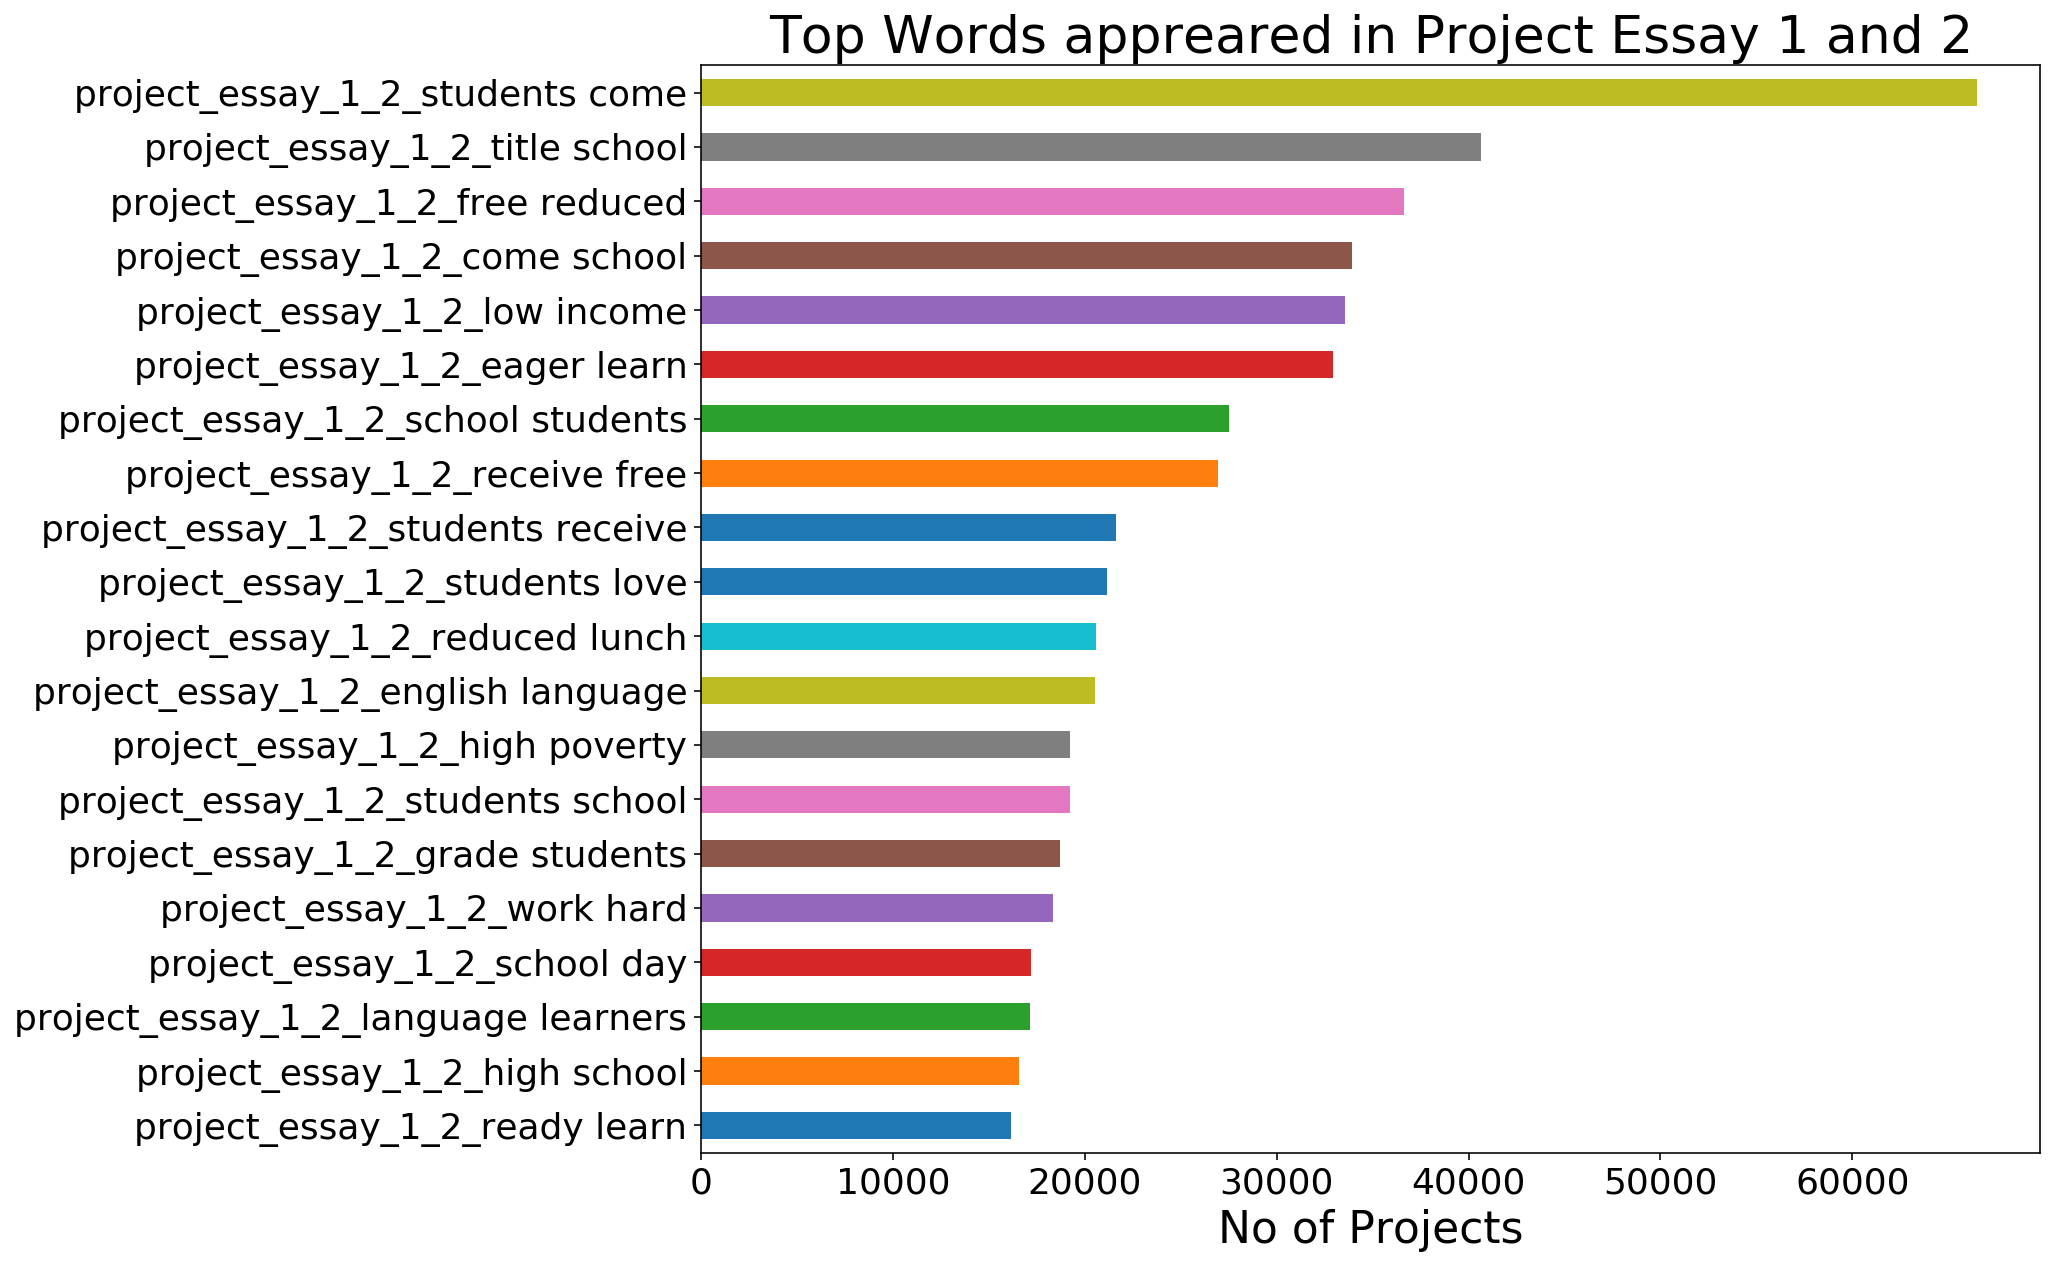

In [112]:
project_essay_1_2_features.sum().sort_values(ascending=False) \
                                       .head(20).sort_values(ascending=True) \
                                       .plot(kind='barh', figsize=(12,10), fontsize=18)
plt.title('Top Words appreared in Project Essay 1 and 2', fontsize=26)
plt.xlabel('No of Projects', fontsize=22)
plt.show()

([], <a list of 0 Text yticklabel objects>)

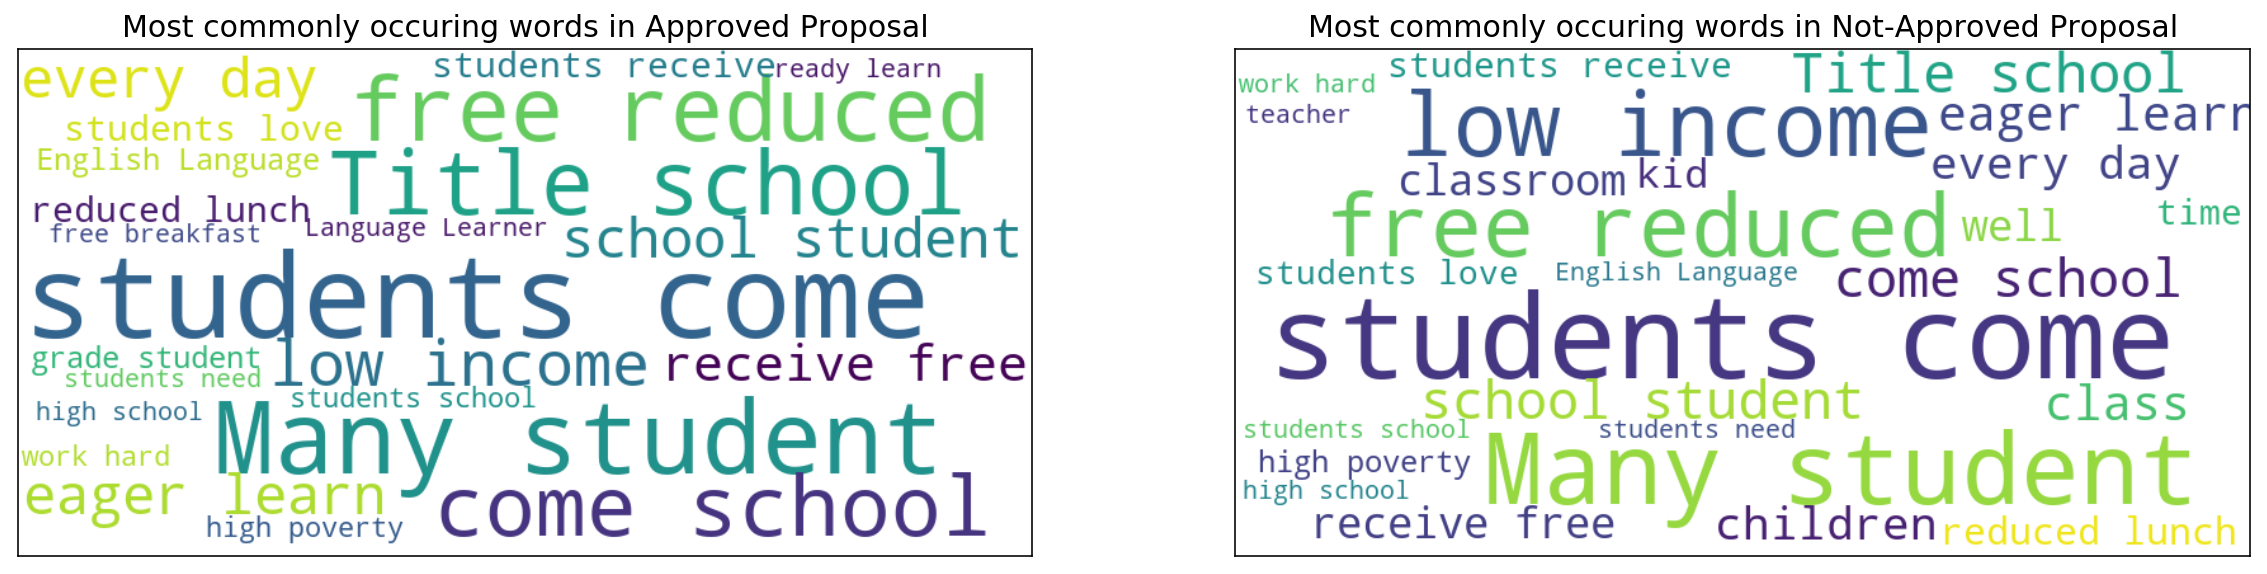

In [113]:
#Take a look at the most commonly occuring words in the Project Essay 1 and 2

#Separate the text for approval and not approval
texthigh = ''.join(words for words in whole_df[whole_df['project_is_approved']==1.0]['project_essay_1_2'])
textlow = ''.join(words for words in whole_df[whole_df['project_is_approved']==0.0]['project_essay_1_2'])

#Generate the words clouds for higher and lower paying jobs
wordcloudhigh=WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(texthigh)
wordcloudlow= WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(textlow)

#Plot the wordclouds
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloudhigh,interpolation='bilinear')
plt.title('Most commonly occuring words in Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wordcloudlow,interpolation='bilinear')
plt.title('Most commonly occuring words in Not-Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

In [114]:
test_sent = whole_df.project_essay_1_2.apply(text_sentiment)
project_essay_1_2_sentiment_features = pd.DataFrame(list(test_sent.values))
project_essay_1_2_sentiment_features.columns = ['project_essay_1_2_polarity','project_essay_1_2_subjectivity']
project_essay_1_2_sentiment_features.head()

project_essay_1_2_polarity  project_essay_1_2_subjectivity
0                    0.244394                        0.439385
1                    0.263750                        0.717500
2                    0.345739                        0.487879
3                    0.162302                        0.391270
4                    0.407143                        0.606122

### Checking Project Essay 1 and 2's Word counts effect in prediction

In [115]:
whole_df.project_essay_1_2.describe()

count                                                260115
unique                                               195341
top       As a teacher in a low-incomehigh poverty schoo...
freq                                                    106
Name: project_essay_1_2, dtype: object

In [116]:
whole_df.groupby('project_is_approved')['project_essay_1_2'].describe()

count  unique  \
project_is_approved                   
0.0                   27734   26645   
1.0                  154346  124015   

                                                                   top freq  
project_is_approved                                                          
0.0                  As a teacher in a low-incomehigh poverty schoo...   10  
1.0                  As a teacher in a low-incomehigh poverty schoo...   58

In [117]:
whole_df['project_essay_1_2_len'] = whole_df.project_essay_1_2.apply(len)

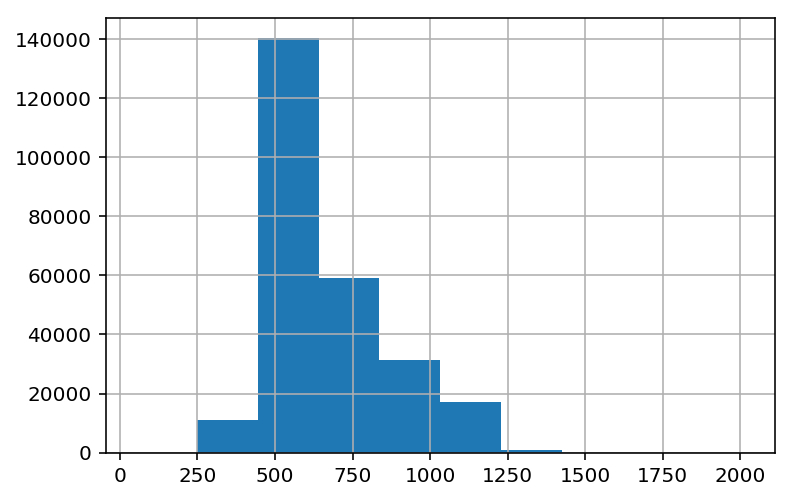

In [118]:
whole_df.project_essay_1_2_len.hist()

In [119]:
whole_df.project_essay_1_2_len.describe()

count    260115.000000
mean        659.405351
std         195.810589
min          52.000000
25%         506.000000
50%         596.000000
75%         770.000000
max        2014.000000
Name: project_essay_1_2_len, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c544e85f8>,
      dtype=object)

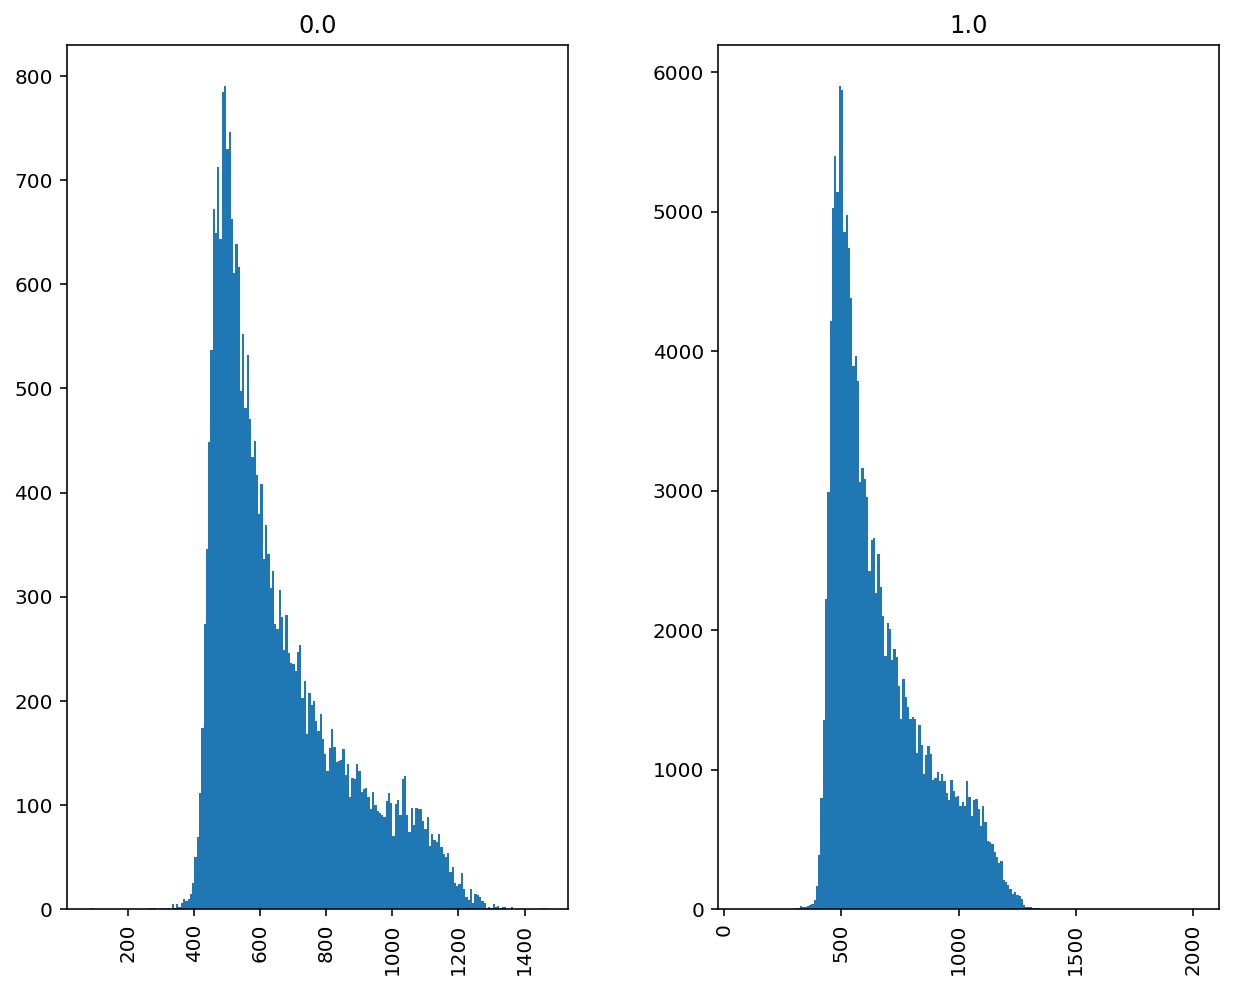

In [120]:
whole_df.hist(column='project_essay_1_2_len', by='project_is_approved', bins=200, figsize=(10,8))

### Since Word Counts can't differentiate in between 0 and 1 as in above histogram for Project essay 1 and 2, it will be included as features.

In [121]:
project_essay_3_4_features = text_feature_extraction("project_essay_3_4",
                                                            (2,2),0.005,0.95)
project_essay_3_4_features.columns = [ 'project_essay_3_4_'+ x for x in project_essay_3_4_features.columns]

# of features : 713


In [122]:
project_essay_3_4_features.head()

project_essay_3_4_21st century  project_essay_3_4_2nd grade  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            0   

   project_essay_3_4_3rd grade  project_essay_3_4_4th grade  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   project_essay_3_4_5th grade  project_essay_3_4_60 minutes  \
0                            0                             0   
1                            0                             0   
2                            0                             0   
3                            0                             2   
4                            0                             0   

   project_essay_3_4_6th grade  project_essay_3_4_able access  \
0                            0                              0   
1                            0                              0   
2                            0                              0   
3                            0                              0   
4                            0                              0   

   project_essay_3_4_able choose  project_essay_3_4_able complete  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

                 ...                 project_essay_3_4_year olds  \
0                ...                                           0   
1                ...                                           0   
2                ...                                           0   
3                ...                                           0   
4                ...                                           0   

   project_essay_3_4_year students  project_essay_3_4_year year  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   

   project_essay_3_4_years come  project_essay_3_4_years old  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   project_essay_3_4_yoga balls  project_essay_3_4_young age  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   project_essay_3_4_young children  project_essay_3_4_young learners  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   project_essa

In [123]:
project_essay_3_4_features.sum().sort_values(ascending=False).head(20)

project_essay_3_4_help students           53143
project_essay_3_4_students able           51563
project_essay_3_4_allow students          48333
project_essay_3_4_students need           43605
project_essay_3_4_students use            34433
project_essay_3_4_students learn          28622
project_essay_3_4_students love           20079
project_essay_3_4_flexible seating        19036
project_essay_3_4_classroom students      17764
project_essay_3_4_students opportunity    17736
project_essay_3_4_provide students        15679
project_essay_3_4_students work           15413
project_essay_3_4_small group             15364
project_essay_3_4_students access         15066
project_essay_3_4_students learning       13554
project_essay_3_4_able use                13449
project_essay_3_4_school year             13103
project_essay_3_4_want students           11756
project_essay_3_4_seating options         11130
project_essay_3_4_small groups            10626
dtype: int64

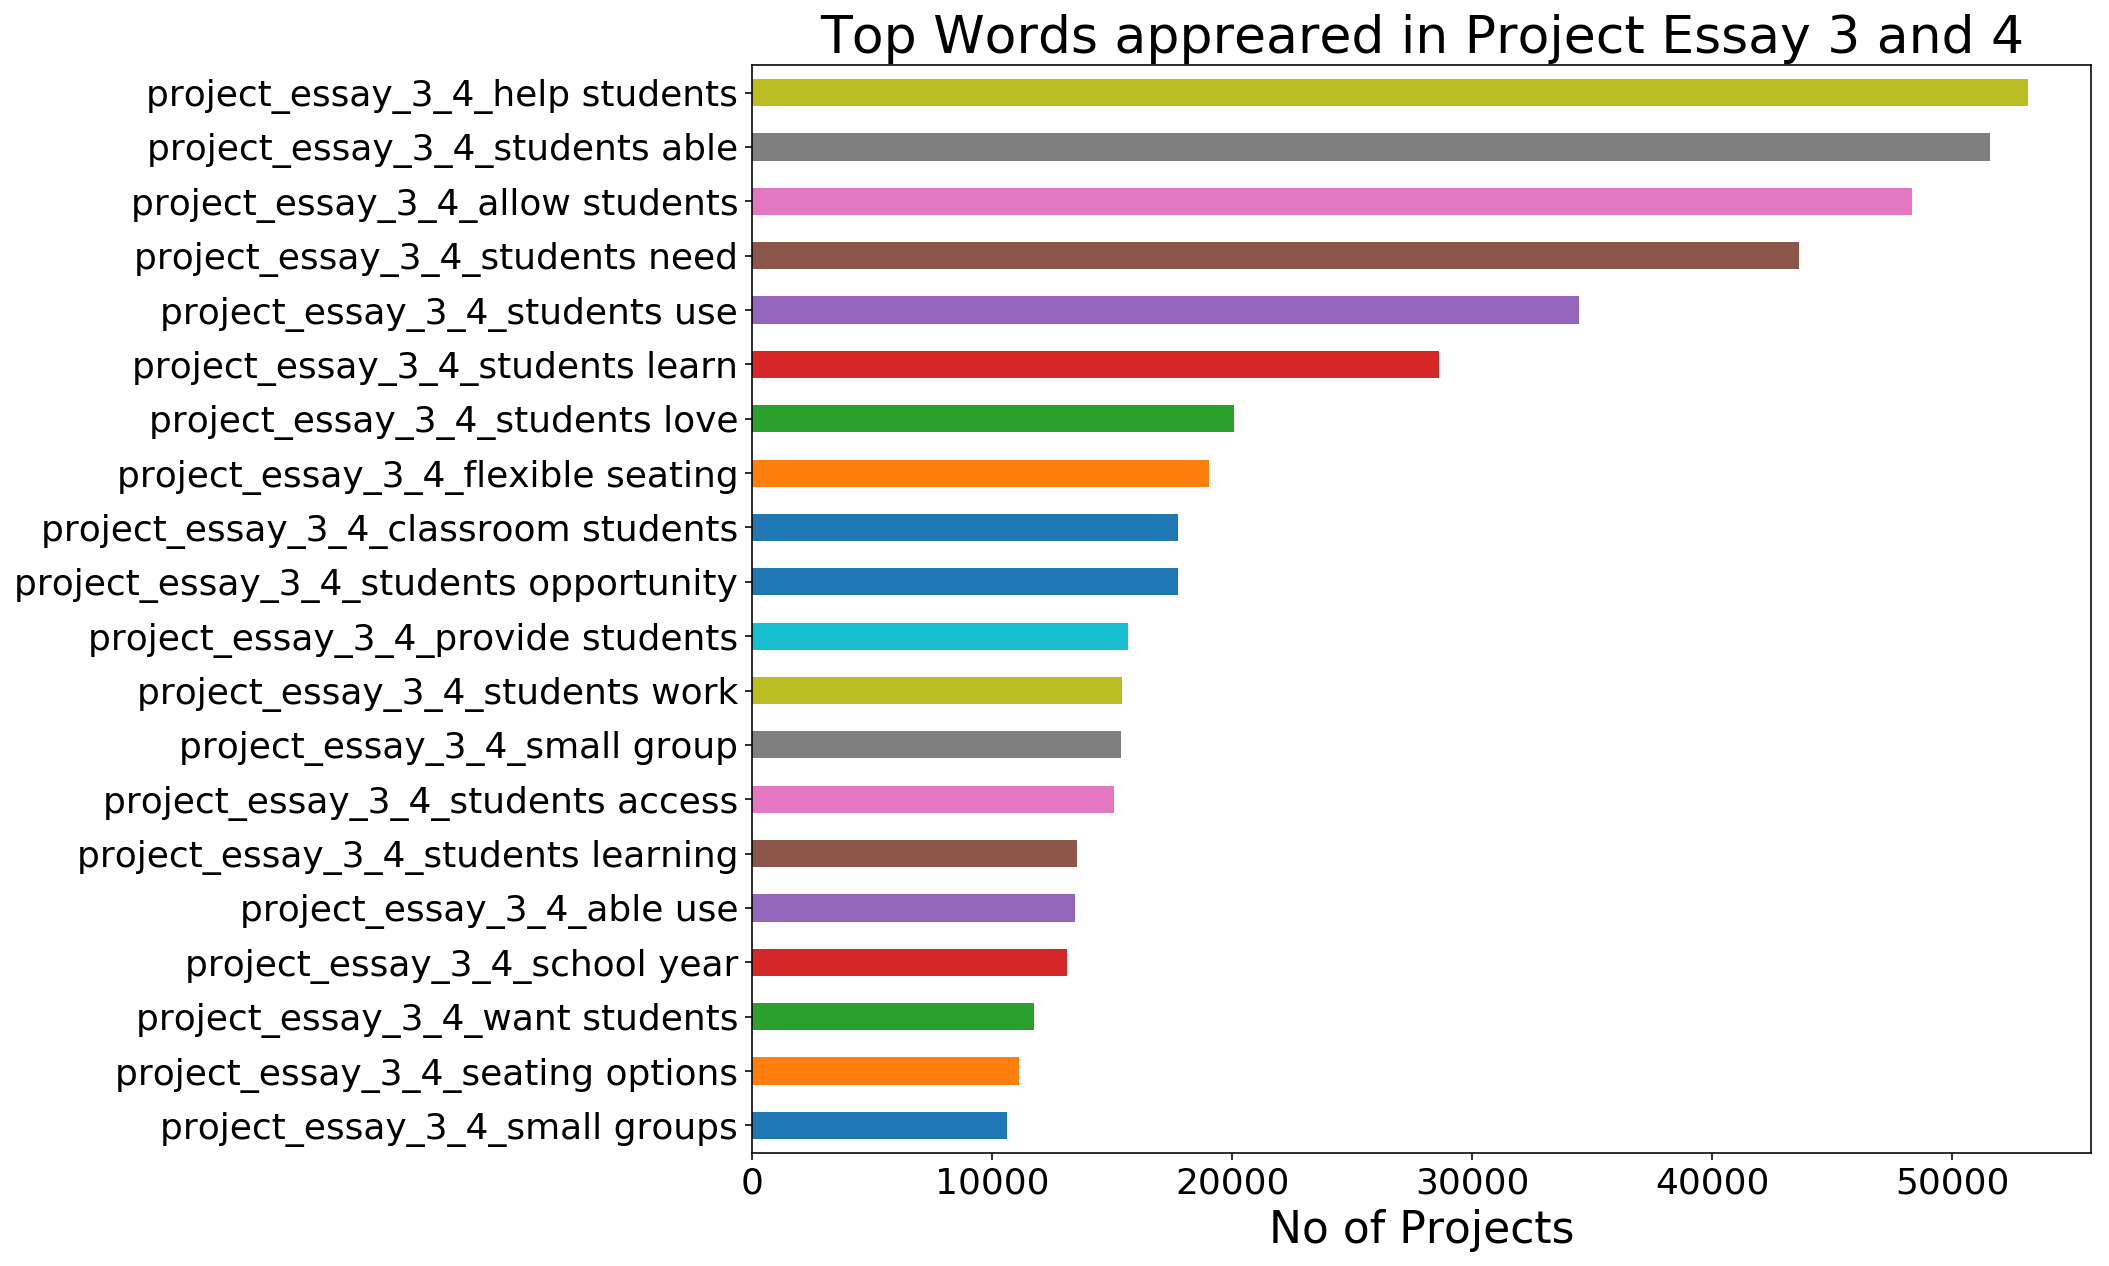

In [124]:
project_essay_3_4_features.sum().sort_values(ascending=False) \
                                       .head(20).sort_values(ascending=True) \
                                       .plot(kind='barh', figsize=(12,10), fontsize=18)
plt.title('Top Words appreared in Project Essay 3 and 4', fontsize=26)
plt.xlabel('No of Projects', fontsize=22)
plt.show()

([], <a list of 0 Text yticklabel objects>)

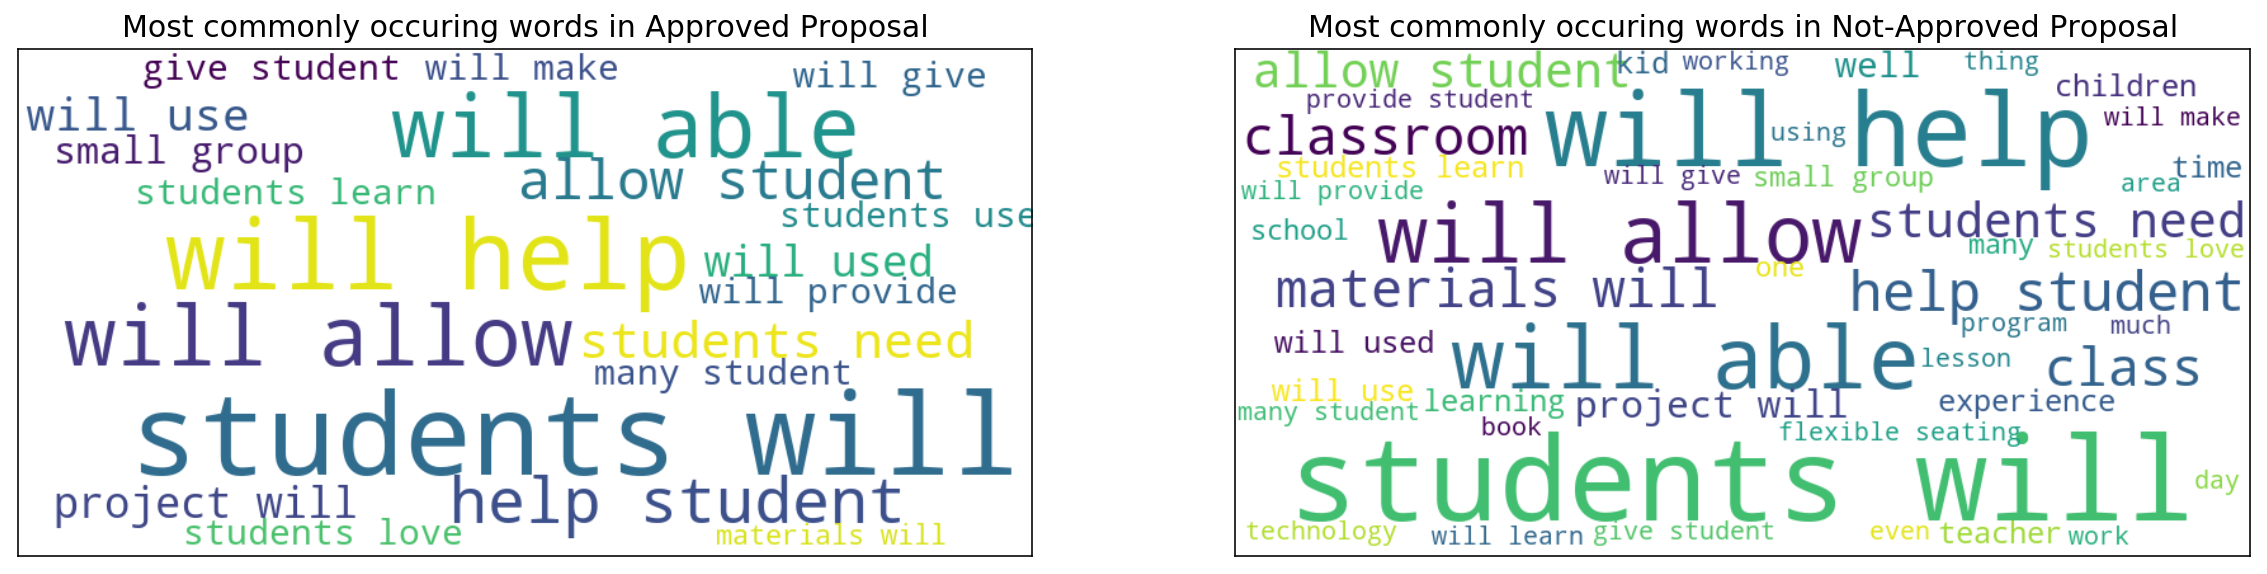

In [125]:
#Take a look at the most commonly occuring words in the Project Essay 3 and 4

#Separate the text for approval and not approval
texthigh = ''.join(words for words in whole_df[whole_df['project_is_approved']==1.0]['project_essay_3_4'])
textlow = ''.join(words for words in whole_df[whole_df['project_is_approved']==0.0]['project_essay_3_4'])

#Generate the words clouds for higher and lower paying jobs
wordcloudhigh=WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(texthigh)
wordcloudlow= WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(textlow)

#Plot the wordclouds
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloudhigh,interpolation='bilinear')
plt.title('Most commonly occuring words in Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wordcloudlow,interpolation='bilinear')
plt.title('Most commonly occuring words in Not-Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

In [126]:
test_sent = whole_df.project_essay_3_4.apply(text_sentiment)
project_essay_3_4_sentiment_features = pd.DataFrame(list(test_sent.values))
project_essay_3_4_sentiment_features.columns = ['project_essay_3_4_polarity','project_essay_3_4_subjectivity']

In [127]:
project_essay_3_4_sentiment_features.head()

project_essay_3_4_polarity  project_essay_3_4_subjectivity
0                    0.144444                        0.300000
1                    0.111905                        0.459524
2                    0.367857                        0.614286
3                    0.193033                        0.447744
4                    0.190741                        0.519136

### Checking Project Essay 3 and 4's Word counts effect in prediction

In [128]:
whole_df.project_essay_3_4.describe()

count                                                260115
unique                                               257459
top       Students will be using Chromebooks to increase...
freq                                                     37
Name: project_essay_3_4, dtype: object

In [129]:
whole_df.groupby('project_is_approved')['project_essay_3_4'].describe()

count  unique  \
project_is_approved                   
0.0                   27734   27701   
1.0                  154346  153065   

                                                                   top freq  
project_is_approved                                                          
0.0                  When students are asked what their favorite pa...    3  
1.0                  Students will be using Chromebooks to increase...   24

In [130]:
whole_df['project_essay_3_4_len'] = whole_df.project_essay_3_4.apply(len)

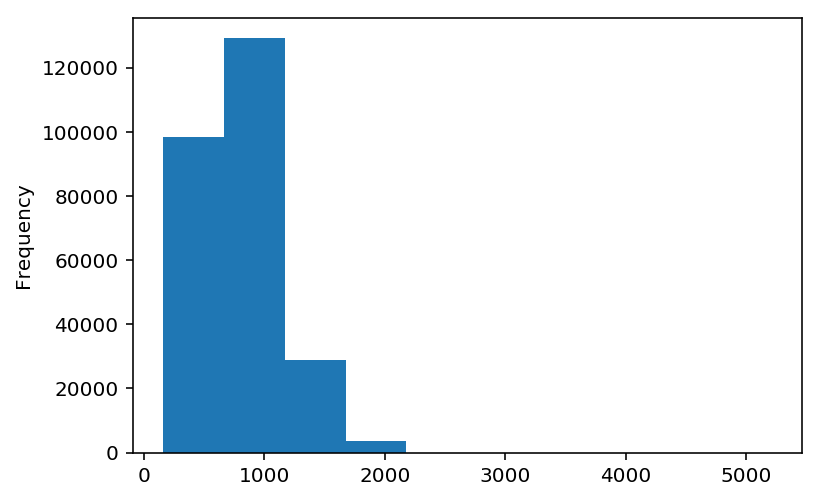

In [131]:
whole_df.project_essay_3_4_len.plot.hist()

In [132]:
whole_df.project_essay_3_4_len.describe()

count    260115.000000
mean        822.570878
std         277.089927
min         160.000000
25%         624.000000
50%         719.000000
75%         938.000000
max        5209.000000
Name: project_essay_3_4_len, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c39afc9e8>,
      dtype=object)

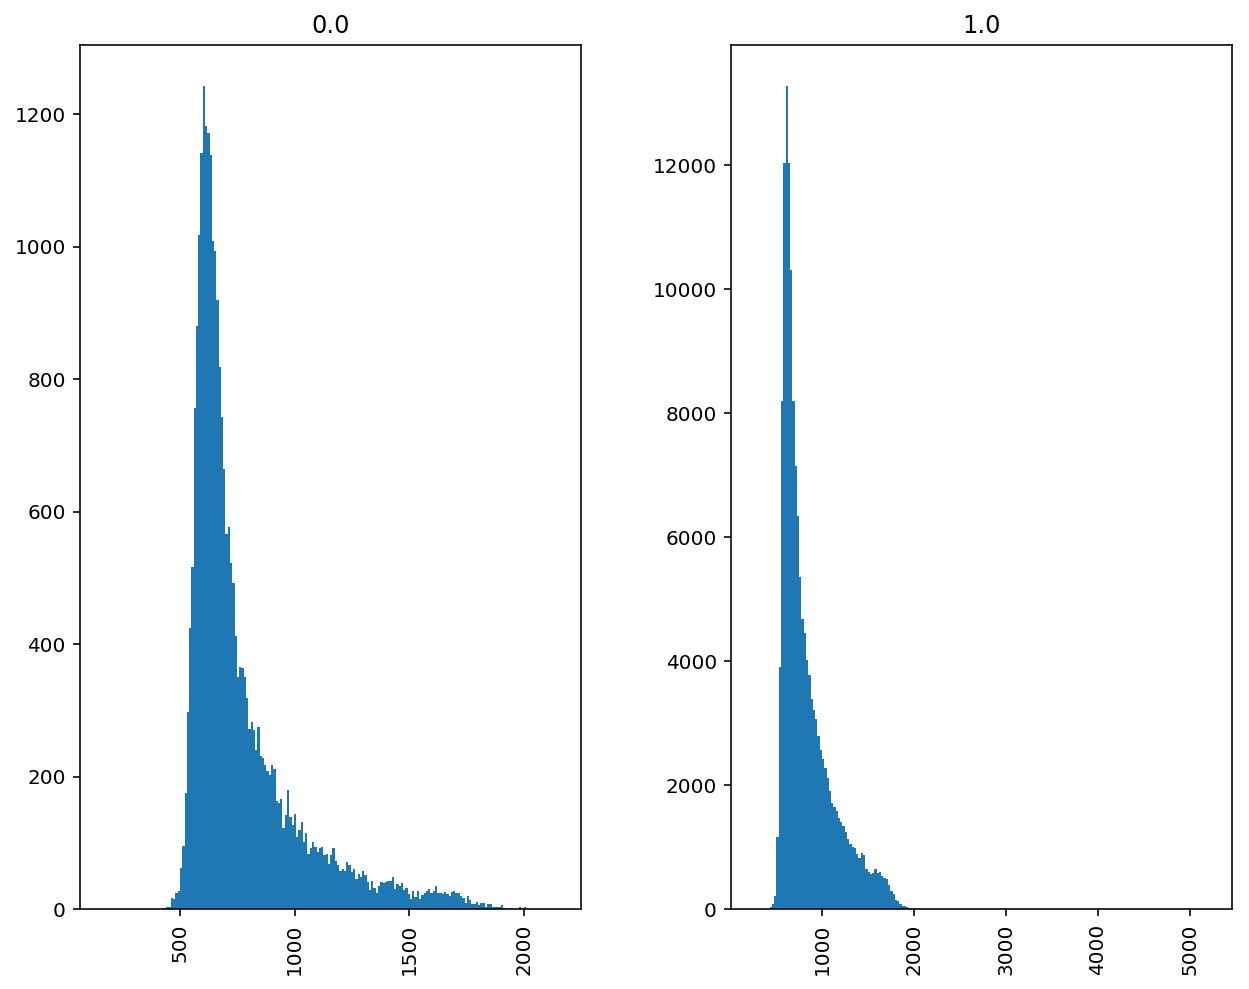

In [133]:
whole_df.hist(column='project_essay_3_4_len', by='project_is_approved', bins=200, figsize=(10,8))

## Below are Mark down for Future Progress (too long to run)
_______________________________________________________________________

In [134]:
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        if word.pos_ == 'NOUN':
            sent.append(word.lemma_)
    return " ".join(sent)

In [135]:
# whole_df.project_essay_1_2 = whole_df.project_essay_1_2.apply(lemmatizer)

In [136]:
# whole_df.project_essay_1_2[182197]

_______________________________________________________________________

In [137]:
stopping_words = stopwords.words('english')
print("Checking what words are contained in stopwords :\n",stopping_words)


Checking what words are contained in stopwords :
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'n

In [138]:
#stopping_words.extend(['student','need','students','require','needs','requires'])

### 5.7 Adding Project Resource Summary as features

In [139]:
whole_df.project_resource_summary[0]

"My students need 6 Ipod Nano's to create and differentiated and engaging way to practice sight words during a literacy station."

In [140]:
whole_df.project_resource_summary = whole_df.project_resource_summary.apply(cleaning_text)
#whole_df.project_resource_summary = whole_df.project_resource_summary.apply(lemmatizer)

In [141]:
#nlp_test = list(nlp.pipe(whole_df.project_resource_summary))

In [142]:
# for word in nlp_test[0]:
#     print(word, word.lemma_, word.pos_)

# print(nlp_test[2])
# print(' '.join([word.lemma_ for word in nlp_test[2] if word.is_oov]))

In [143]:
whole_df.project_resource_summary[0]

'My students need 6 Ipod Nanos to create and differentiated and engaging way to practice sight words during a literacy station'

In [144]:
# Since i didn't do lemmatizer yet, there are some repeated words like book and books. So best is not to use too low min_df
#re_sum_temp = text_feature_extraction("project_resource_summary", (3,4), 0.005)

In [145]:
#re_sum_temp.sum()

In [146]:
project_resource_summary_features = text_feature_extraction("project_resource_summary",
                                                            (2,2),0.001,0.95)
project_resource_summary_features.columns = [ 'proj_resource_sum_'+ x for x in project_resource_summary_features.columns]


# of features : 743


In [147]:
project_resource_summary_features.head()


proj_resource_sum_21st century  proj_resource_sum_3d printer  \
0                               0                             0   
1                               0                             0   
2                               0                             0   
3                               0                             0   
4                               0                             0   

   proj_resource_sum_60 minutes  proj_resource_sum_able access  \
0                             0                              0   
1                             0                              0   
2                             0                              0   
3                             0                              0   
4                             0                              0   

   proj_resource_sum_able learn  proj_resource_sum_able use  \
0                             0                           0   
1                             0                           0   
2                             0                           0   
3                             0                           0   
4                             0                           0   

   proj_resource_sum_able work  proj_resource_sum_access books  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   proj_resource_sum_access internet  proj_resource_sum_access online  \
0                                  0                                0   
1                                  0                                0   
2                                  0                                0   
3                                  0                                0   
4                                  0                                0   

              ...               proj_resource_sum_work independently  \
0             ...                                                  0   
1             ...                                                  0   
2             ...                                                  0   
3             ...                                                  0   
4             ...                                                  0   

   proj_resource_sum_work small  proj_resource_sum_work time  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   proj_resource_sum_write wipe  proj_resource_sum_writing center  \
0                             0                                 0   
1                             0                                 0   
2                             0                                 0   
3                             0                                 0   
4                             0                                 0   

   proj_resource_sum_writing math  proj_resource_sum_writing skills  \
0                               0                                 0   
1                               0                                 0   
2                               0                                 0   
3                               0                                 0   
4                               0                                 0   

   proj_resource_sum_yoga ball  proj_resource_sum_yoga balls  \
0                            0                             0   
1                            0                             0   
2                            0                             0   
3                            0                             0   
4       

In [148]:
project_resource_summary_features.sum().sort_values(ascending=False)

proj_resource_sum_flexible seating        8567
proj_resource_sum_need chromebooks        8064
proj_resource_sum_need ipad               6436
proj_resource_sum_need books              6385
proj_resource_sum_need new                5915
proj_resource_sum_seating options         5817
proj_resource_sum_wobble chairs           4751
proj_resource_sum_need flexible           4589
proj_resource_sum_need ipads              4550
proj_resource_sum_need variety            4101
proj_resource_sum_need classroom          3789
proj_resource_sum_21st century            3778
proj_resource_sum_need wobble             3671
proj_resource_sum_need materials          3618
proj_resource_sum_small group             3472
proj_resource_sum_need supplies           3444
proj_resource_sum_need access             3301
proj_resource_sum_classroom library       3294
proj_resource_sum_need hands              3113
proj_resource_sum_hokki stools            3093
proj_resource_sum_class set               3077
proj_resource

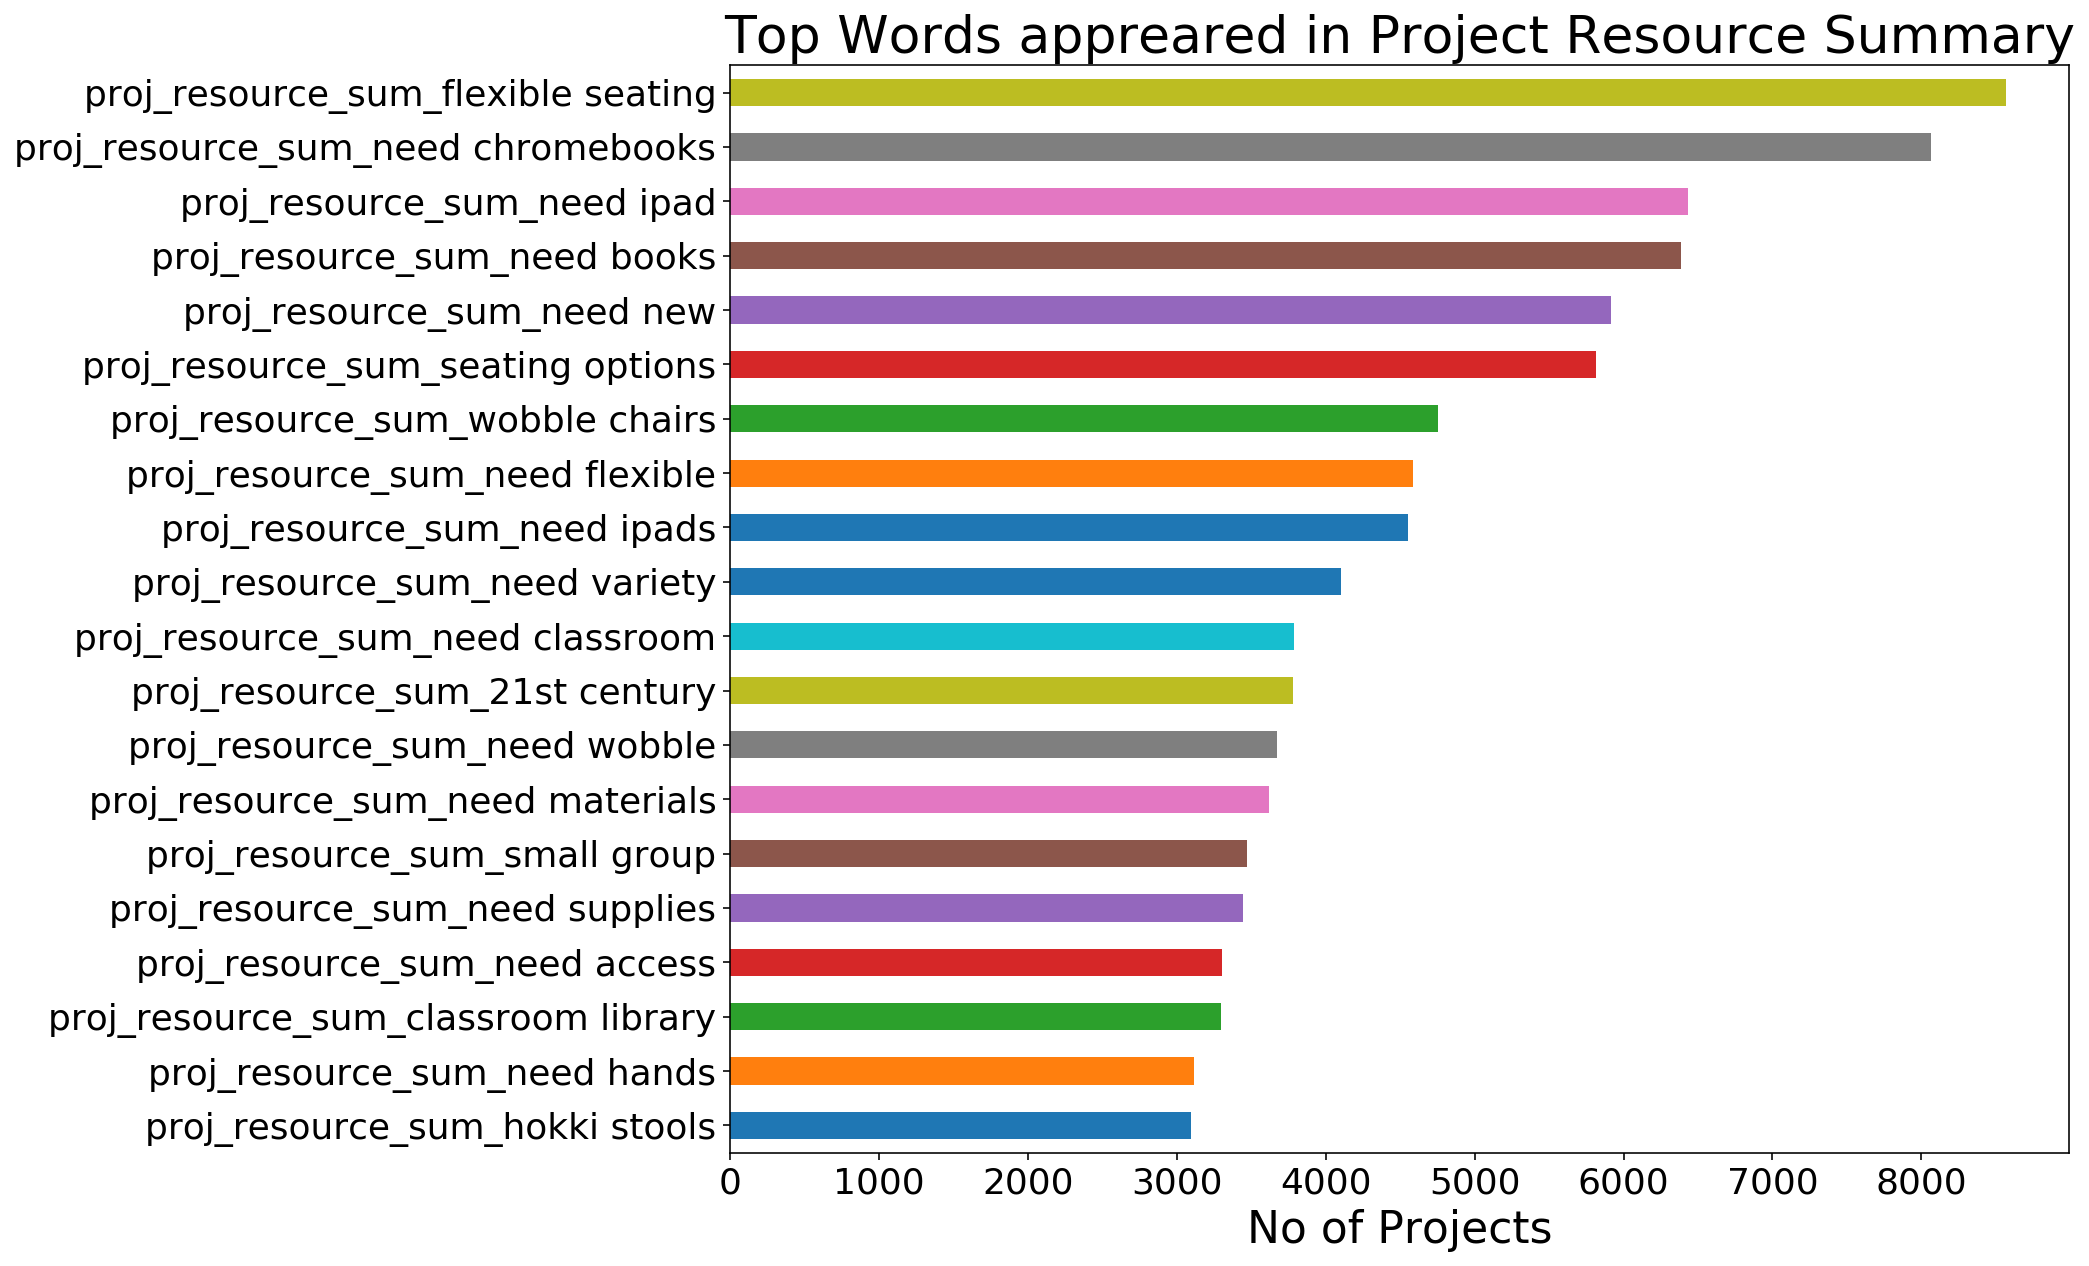

In [149]:
project_resource_summary_features.sum().sort_values(ascending=False) \
                                       .head(20).sort_values(ascending=True) \
                                       .plot(kind='barh', figsize=(12,10), fontsize=18)
plt.title('Top Words appreared in Project Resource Summary', fontsize=26)
plt.xlabel('No of Projects', fontsize=22)
plt.show()

([], <a list of 0 Text yticklabel objects>)

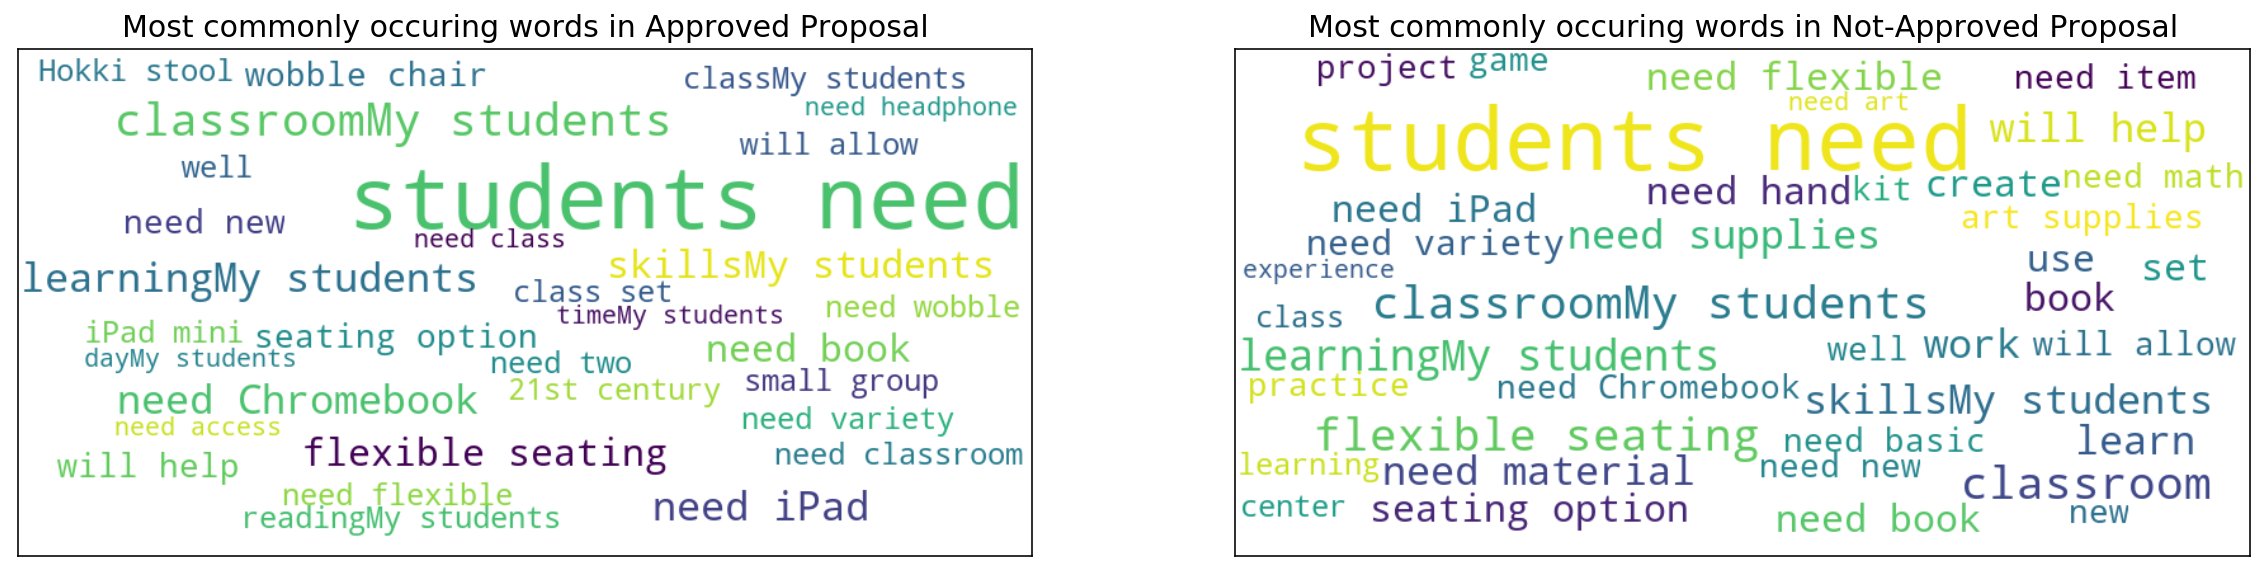

In [150]:
#Take a look at the most commonly occuring words in the Project resource summary

#Separate the text for approval and not approval
texthigh = ''.join(words for words in whole_df[whole_df['project_is_approved']==1.0]['project_resource_summary'])
textlow = ''.join(words for words in whole_df[whole_df['project_is_approved']==0.0]['project_resource_summary'])

#Generate the words clouds for higher and lower paying jobs
wordcloudhigh=WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(texthigh)
wordcloudlow= WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(textlow)

#Plot the wordclouds
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloudhigh,interpolation='bilinear')
plt.title('Most commonly occuring words in Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wordcloudlow,interpolation='bilinear')
plt.title('Most commonly occuring words in Not-Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

In [151]:
test_sent = whole_df.project_resource_summary.apply(text_sentiment)
project_resource_summary_sentiment_features = pd.DataFrame(list(test_sent.values))
project_resource_summary_sentiment_features.columns = ['proj_resource_sum_polarity','proj_resource_sum_subjectivity']

In [152]:
project_resource_summary_sentiment_features.head()

proj_resource_sum_polarity  proj_resource_sum_subjectivity
0                    0.400000                        0.700000
1                    0.000000                        0.000000
2                    1.000000                        0.300000
3                   -0.041667                        0.372619
4                    0.000000                        0.000000

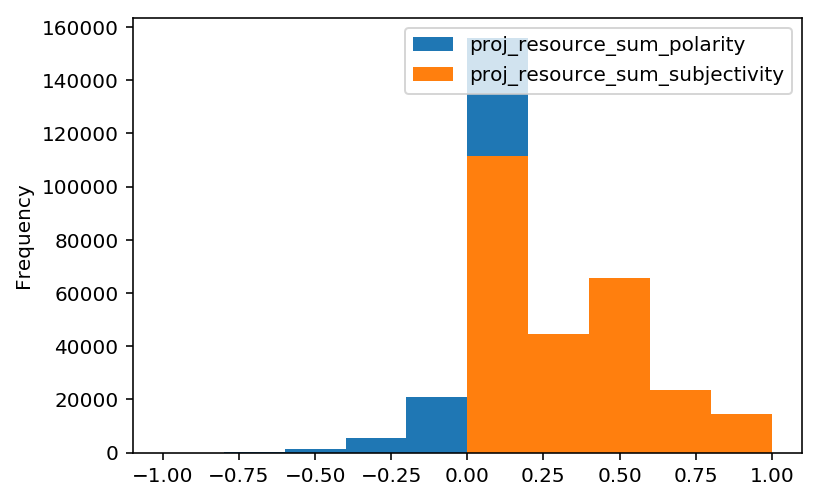

In [153]:
project_resource_summary_sentiment_features.plot.hist()

### Checking Project Resource Summary's Word counts effect in prediction

In [154]:
whole_df.project_resource_summary.describe()

count                                                260115
unique                                               255204
top       My students need electronic tablets to do all ...
freq                                                    121
Name: project_resource_summary, dtype: object

In [155]:
train_temp.groupby('project_is_approved')['project_resource_summary'].describe()

count  unique  \
project_is_approved                   
0                     27734   27693   
1                    154346  152281   

                                                                   top freq  
project_is_approved                                                          
0                    My students need electronic tablets to do all ...   11  
1                    My students need electronic tablets to do all ...   73

In [156]:
whole_df['project_resource_summary_len'] = whole_df.project_resource_summary.apply(len)

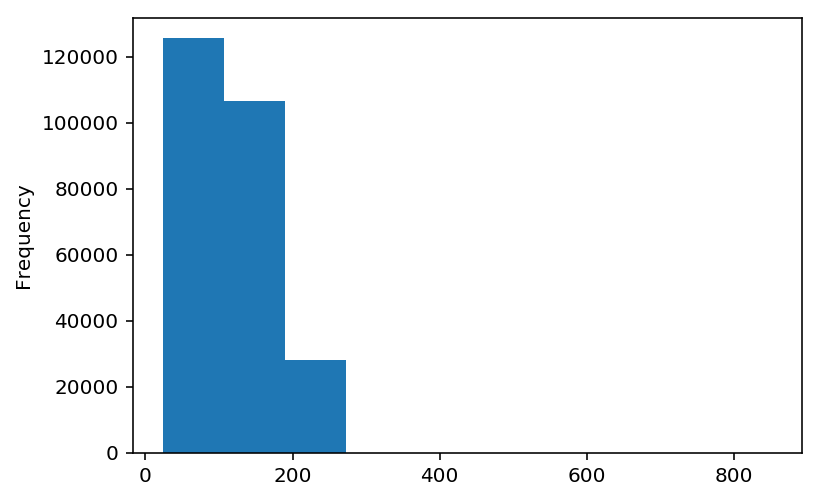

In [157]:
whole_df.project_resource_summary_len.plot.hist()

In [158]:
whole_df.project_resource_summary_len.describe()

count    260115.000000
mean        120.037387
std          46.093446
min          24.000000
25%          82.000000
50%         109.000000
75%         154.000000
max         851.000000
Name: project_resource_summary_len, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2c065b38>,
      dtype=object)

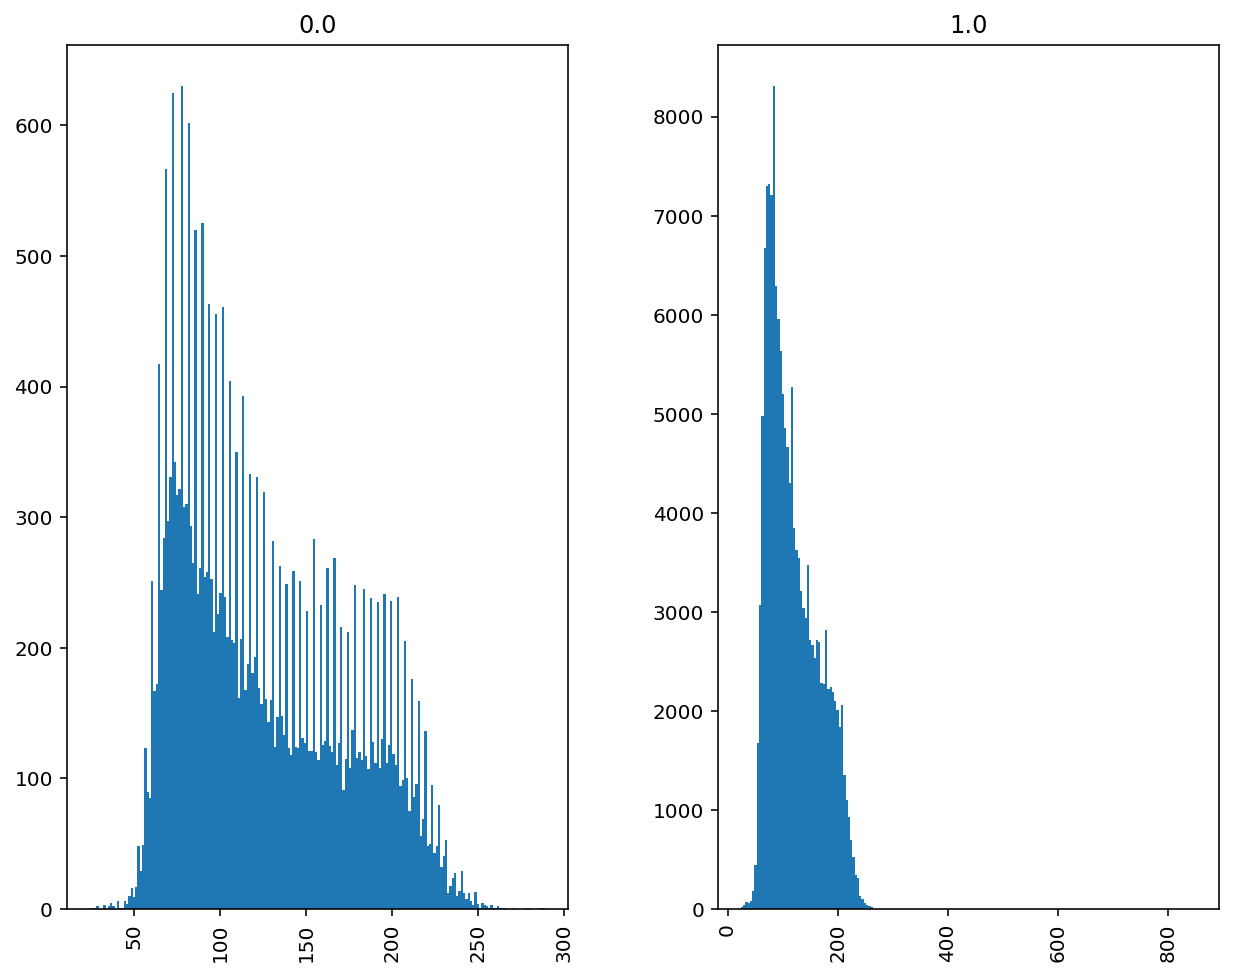

In [159]:
whole_df.hist(column='project_resource_summary_len', by='project_is_approved', bins=200, figsize=(10,8))

### 5.8 Adding Project Title as features

In [160]:
whole_df.project_title.head()

0                             Super Sight Word Centers
1                               Keep Calm and Dance On
2                                Lets 3Doodle to Learn
3    \"Kid Inspired\" Equipment to Increase Activit...
4     We need clean water for our culinary arts class!
Name: project_title, dtype: object

In [161]:
whole_df.project_title = whole_df.project_title.apply(cleaning_text)
#whole_df.project_title = whole_df.project_title.apply(lemmatizer)

In [162]:
whole_df.project_title.head()

0                             Super Sight Word Centers
1                               Keep Calm and Dance On
2                                Lets 3Doodle to Learn
3    Kid Inspired Equipment to Increase Activities ...
4      We need clean water for our culinary arts class
Name: project_title, dtype: object

In [163]:
project_title_features = text_feature_extraction("project_title",(2,2),100,0.95)
project_title_features.columns = ['proj_title_'+ x for x in project_title_features.columns]

# of features : 430


In [164]:
project_title_features.shape

(260115, 430)

In [165]:
project_title_features.head()

proj_title_1st grade  proj_title_1st graders  proj_title_21st century  \
0                     0                       0                        0   
1                     0                       0                        0   
2                     0                       0                        0   
3                     0                       0                        0   
4                     0                       0                        0   

   proj_title_2nd grade  proj_title_2nd graders  proj_title_3d printer  \
0                     0                       0                      0   
1                     0                       0                      0   
2                     0                       0                      0   
3                     0                       0                      0   
4                     0                       0                      0   

   proj_title_3d printing  proj_title_3rd grade  proj_title_3rd graders  \
0                       0                     0                       0   
1                       0                     0                       0   
2                       0                     0                       0   
3                       0                     0                       0   
4                       0                     0                       0   

   proj_title_4th grade            ...             proj_title_wobble learn  \
0                     0            ...                                   0   
1                     0            ...                                   0   
2                     0            ...                                   0   
3                     0            ...                                   0   
4                     0            ...                                   0   

   proj_title_wobble stools  proj_title_wobble wobble  proj_title_wobble work  \
0                         0                         0                       0   
1                         0                         0                       0   
2                         0                         0                       0   
3                         0                         0                       0   
4                         0                         0                       0   

   proj_title_world technology  proj_title_year new  proj_title_year right  \
0                            0                    0                      0   
1                            0                    0                      0   
2                            0                    0                      0   
3                            0                    0                      0   
4                            0                    0                      0   

   proj_title_young learners  proj_title_young minds  proj_title_young readers  
0                          0                       0                         0  
1                          0                       0                         0  
2                          0                       0                         0  
3                          0                       0                         0  
4                          0                       0                         0  

[5 rows x 430 columns]

In [166]:
project_title_features.sum().sort_values(ascending=False).head(20)

proj_title_flexible seating       6131
proj_title_21st century           2471
proj_title_wiggle work            1258
proj_title_students need          1137
proj_title_classroom library      1080
proj_title_help students           987
proj_title_alternative seating     974
proj_title_special needs           948
proj_title_love reading            906
proj_title_books books             833
proj_title_learning fun            754
proj_title_special education       724
proj_title_hands learning          691
proj_title_steam ahead             691
proj_title_second grade            613
proj_title_learning technology     602
proj_title_listening center        589
proj_title_school supplies         586
proj_title_middle school           571
proj_title_2nd grade               533
dtype: int64

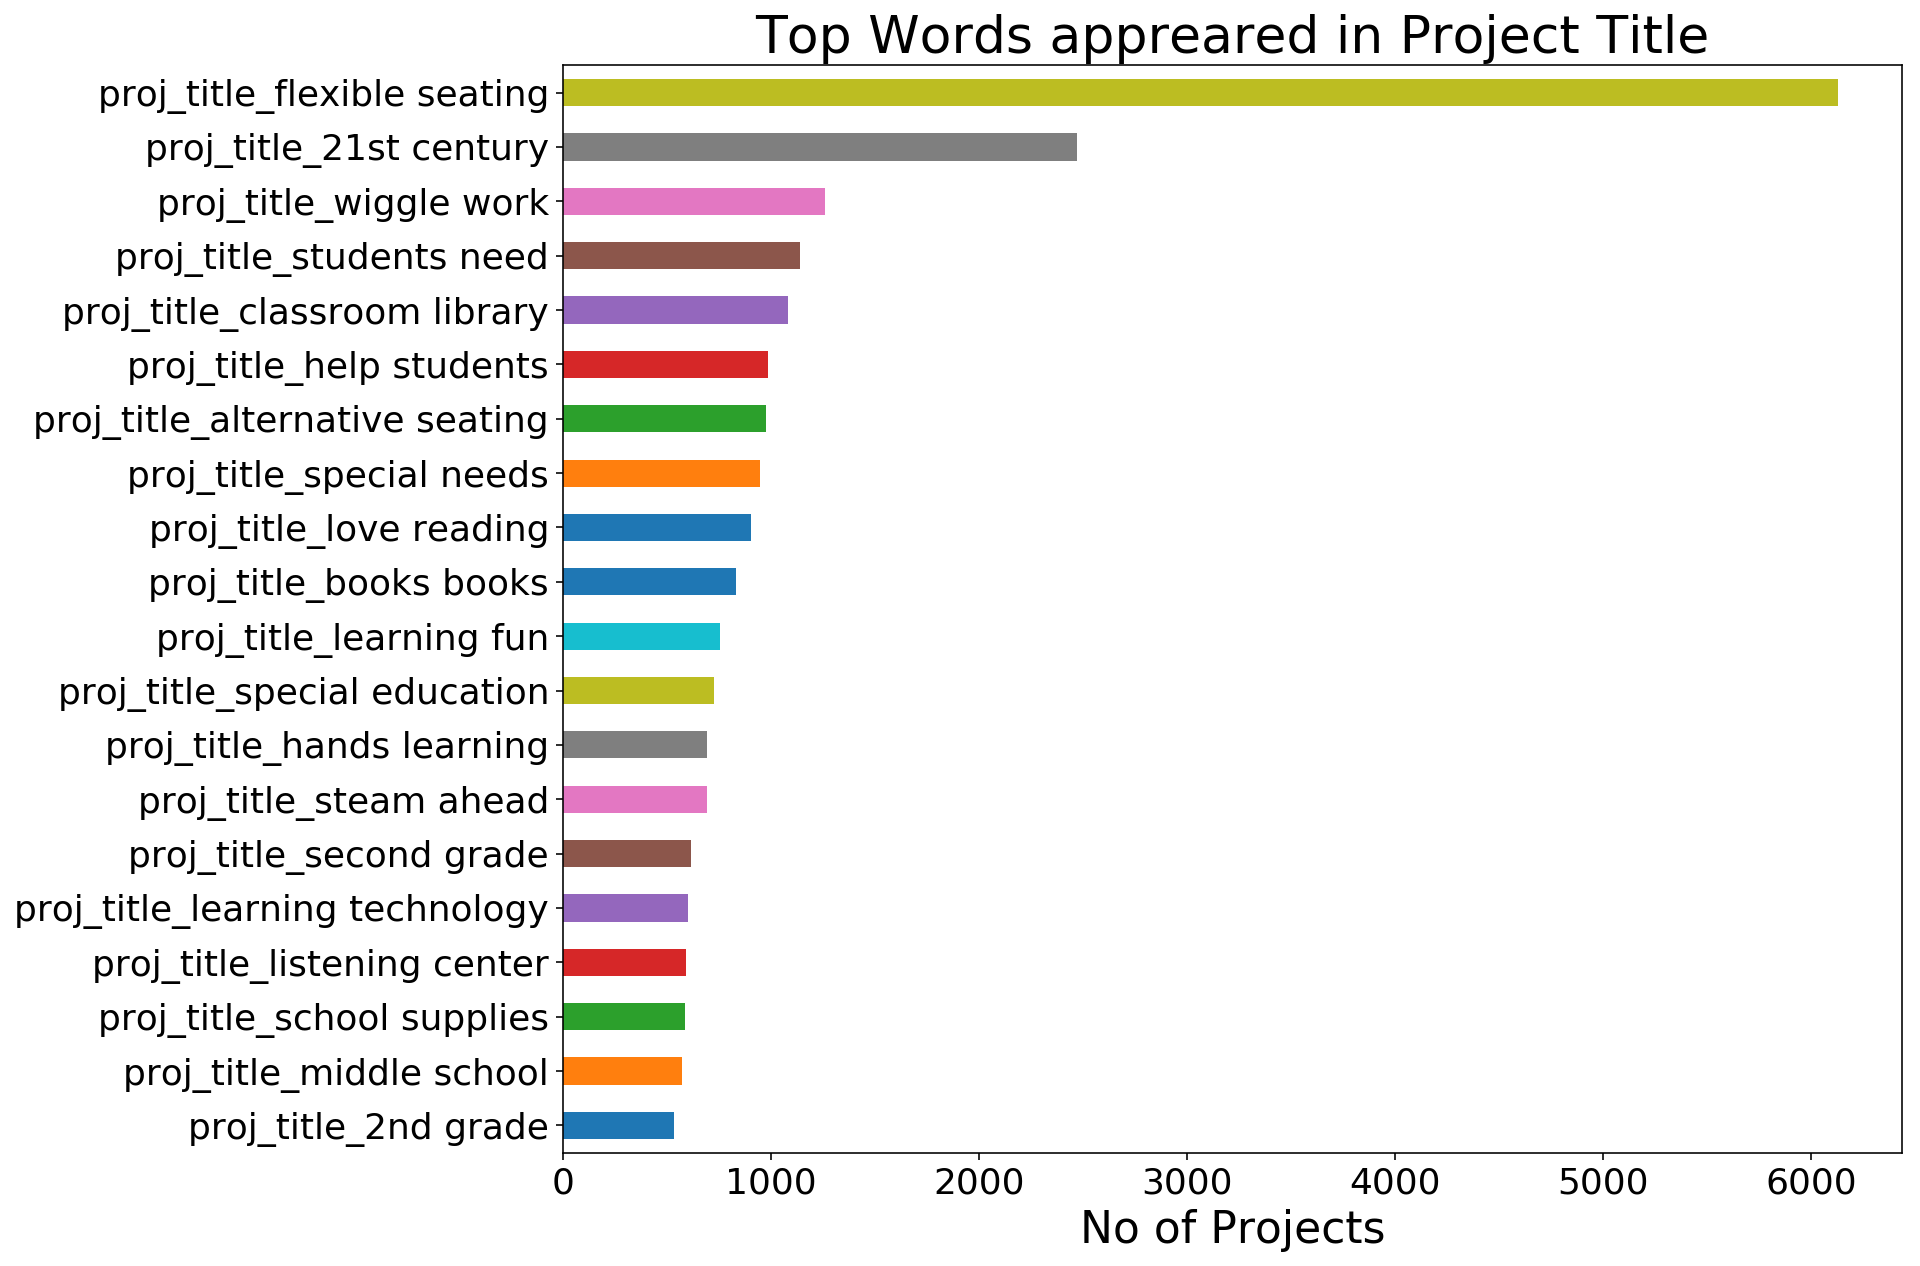

In [167]:
project_title_features.sum().sort_values(ascending=False) \
                                       .head(20).sort_values(ascending=True) \
                                       .plot(kind='barh', figsize=(12,10), fontsize=18)
plt.title('Top Words appreared in Project Title', fontsize=26)
plt.xlabel('No of Projects', fontsize=22)
plt.show()

([], <a list of 0 Text yticklabel objects>)

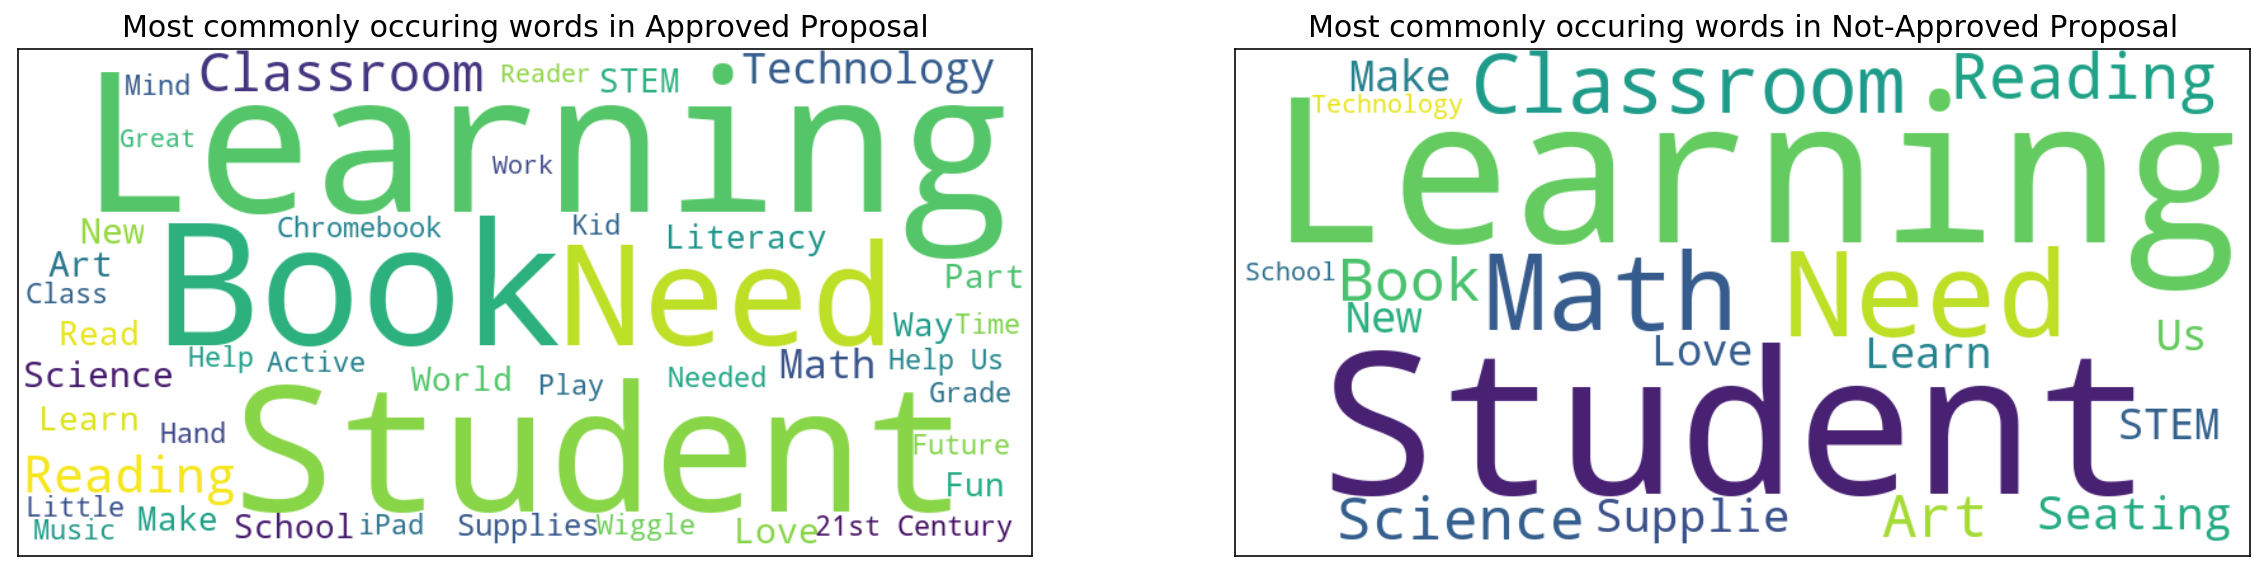

In [168]:
#Take a look at the most commonly occuring words in the Project resource summary

#Separate the text for approval and not approval
texthigh = ''.join(words for words in whole_df[whole_df['project_is_approved']==1.0]['project_title'])
textlow = ''.join(words for words in whole_df[whole_df['project_is_approved']==0.0]['project_title'])

#Generate the words clouds for higher and lower paying jobs
wordcloudhigh=WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(texthigh)
wordcloudlow= WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(textlow)

#Plot the wordclouds
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloudhigh,interpolation='bilinear')
plt.title('Most commonly occuring words in Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wordcloudlow,interpolation='bilinear')
plt.title('Most commonly occuring words in Not-Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

In [169]:
test_sent = whole_df.project_title.apply(text_sentiment)
project_title_sentiment_features = pd.DataFrame(list(test_sent.values))
project_title_sentiment_features.columns = ['project_title_polarity','project_title_subjectivity']
project_title_sentiment_features.head()

project_title_polarity  project_title_subjectivity
0                0.333333                    0.666667
1                0.300000                    0.750000
2                0.000000                    0.000000
3                0.500000                    0.500000
4                0.183333                    0.350000

In [170]:
project_title_sentiment_features.describe()

project_title_polarity  project_title_subjectivity
count           260115.000000               260115.000000
mean                 0.085841                    0.177351
std                  0.208841                    0.288435
min                 -1.000000                    0.000000
25%                  0.000000                    0.000000
50%                  0.000000                    0.000000
75%                  0.100000                    0.333333
max                  1.000000                    1.000000

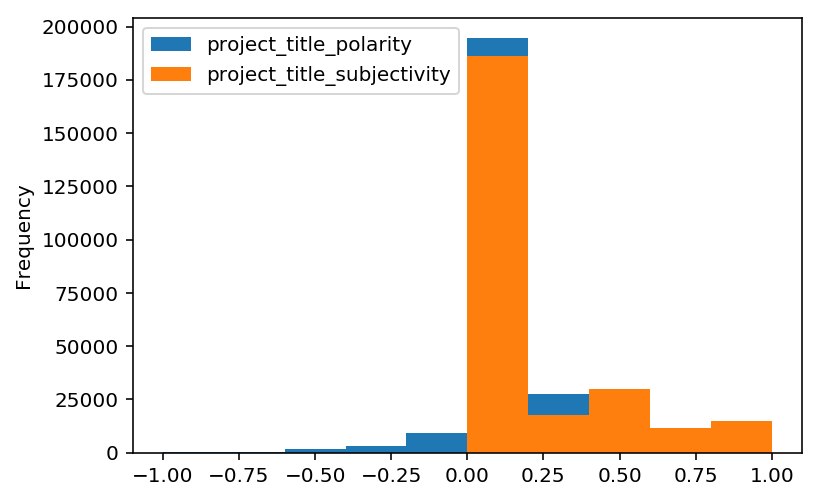

In [171]:
project_title_sentiment_features.plot.hist()

### Checking Project Title's Word counts effect in prediction

In [172]:
whole_df.project_title.describe()

count               260115
unique              221706
top       Flexible Seating
freq                   631
Name: project_title, dtype: object

In [173]:
train_temp.groupby('project_is_approved')['project_title'].describe()

count  unique               top freq
project_is_approved                                       
0                     27734   26598  Flexible Seating   79
1                    154346  139992  Flexible Seating  298

In [174]:
whole_df['project_title_len'] = whole_df.project_title.apply(len)

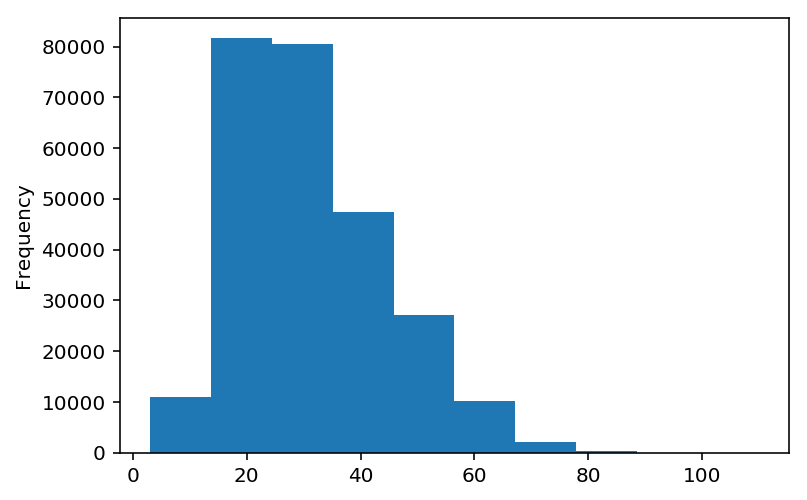

In [175]:
whole_df.project_title_len.plot.hist()

In [176]:
whole_df.project_title_len.describe()

count    260115.000000
mean         31.375984
std          13.091954
min           3.000000
25%          21.000000
50%          29.000000
75%          39.000000
max         110.000000
Name: project_title_len, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c5d621dd8>,
      dtype=object)

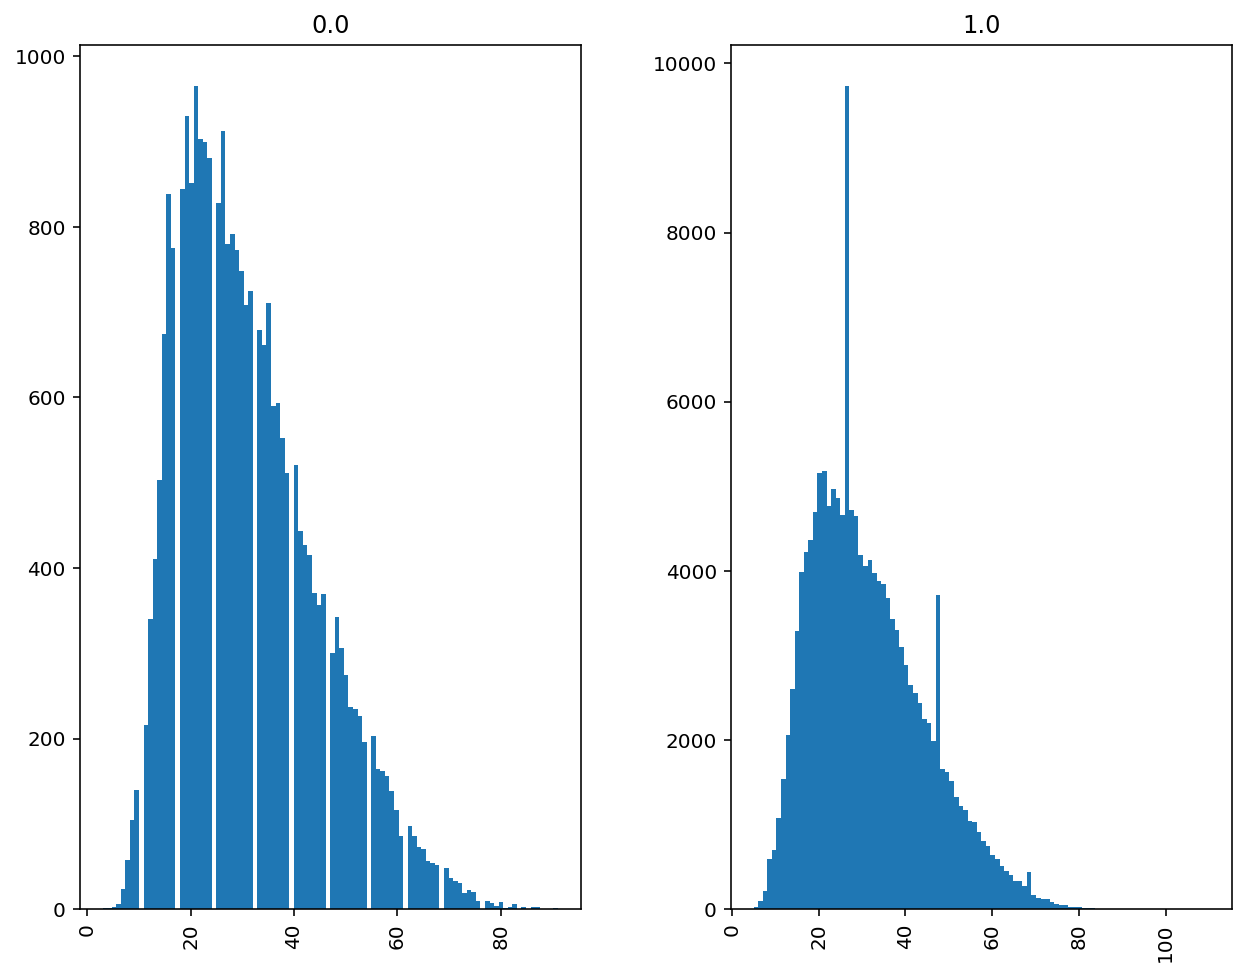

In [177]:
whole_df.hist(column='project_title_len', by='project_is_approved', bins=100, figsize=(10,8))

# 6. Selecting and Adding Features

In [178]:
whole_df.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title  \
0                                Literacy  Super Sight Word Centers   
1            Performing Arts, Team Sports    Keep Calm and Dance On   
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   

         ...          budget month day        date  \
0        ...          899.94    11  18  2016-11-18   
1        ...          400.00     4  26  2017-04-26   
2        ...          469.99     1   1  2017-01-01   

                                   project_essay_1_2  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  HelloMy name is Mrs Brotherton I teach 5th gra...   

                                   project_essay_3_4  project_essay_1_2_len  \
0  I currently have a differentiated sight word c...                    939   
1  We strive to provide our diverse population of...                    568   
2  We are looking to add some 3Doodler to our cla...                    735   

   project_essay_3_4_len  project_resource_summary_len  project_title_len  
0                    788                           125                 24  
1                    612                            80                 22  
2                    540                           183                 21  

[3 rows x 27 columns]

In [179]:
whole_df = pd.concat([whole_df,subcat_features,project_title_features,project_resource_summary_features,sch_state_features,
                      project_essay_1_2_features,project_essay_3_4_features,month_features, day_features],axis=1)
whole_df.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title   ...    \
0                                Literacy  Super Sight Word Centers   ...     
1            Performing Arts, Team Sports    Keep Calm and Dance On   ...     
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   ...     

  day_21 day_22 day_23 day_24 day_25  day_26  day_27  day_28  day_29  day_30  
0      0      0      0      0      0       0       0       0       0       0  
1      0      0      0      0      0       1       0       0       0       0  
2      0      0      0      0      0       0       0       0       0       0  

[3 rows x 3234 columns]

In [180]:
whole_df.shape

(260115, 3234)

# 7. Modelling

In [181]:
train = whole_df[(whole_df.project_is_approved == 1.0) | \
                 (whole_df.project_is_approved == 0.0)]
test = whole_df[(whole_df.project_is_approved != 1.0) & \
                 (whole_df.project_is_approved != 0.0)]

In [182]:
print(train.shape)
print(test.shape)


(182080, 3234)
(78035, 3234)


In [183]:
train.project_is_approved = train.project_is_approved.apply(lambda x : int(x))


In [184]:
print(whole_df.shape[1])
print("No of same features in train and test are not : ",\
      sum(train.columns == test.columns))
# Confirmed that all the features are same in train and test

3234
No of same features in train and test are not :  3234


In [185]:
# Calculating Baseline accuracy and it's imbalance class

baseline_accuracy = 1. - train.project_is_approved.mean()
baseline_accuracy

0.15231766256590507

In [186]:
non_features = ['id', 'teacher_id', 'teacher_prefix', 'gender', 'school_state', 
                'project_submitted_datetime', 'project_grade_category',
                'project_subject_categories', 'project_subject_subcategories',
                'project_title', 'project_essay_1', 'project_essay_2', 
                'project_essay_3', 'project_essay_4', 'project_resource_summary',
                'project_is_approved', 'date', 'project_essay_1_2','project_essay_3_4',
                'project_essay_1_2_len','project_essay_3_4_len','project_resource_summary_len',
                'project_title_len','month','day']


In [187]:
# Setting Features and target
X = train[train.columns.difference(non_features)]
y = train.project_is_approved

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=24)
print(X_train.shape)
print(X_test.shape)

(127456, 3209)
(54624, 3209)


In [188]:
whole_df.columns


Index(['id', 'teacher_id', 'teacher_prefix', 'gender', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title',
       ...
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'day_29', 'day_30'],
      dtype='object', length=3234)

In [189]:
X.columns

Index(['budget', 'day_1', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14',
       'day_15', 'day_16', 'day_17',
       ...
       'subcat_Special Needs', 'subcat_Special Needs, Team Sports',
       'subcat_Special Needs, Visual Arts',
       'subcat_Special Needs, Warmth, Care & Hunger', 'subcat_Team Sports',
       'subcat_Team Sports, Visual Arts', 'subcat_Visual Arts',
       'subcat_Visual Arts, Warmth, Care & Hunger',
       'subcat_Warmth, Care & Hunger',
       'teacher_number_of_previously_posted_projects'],
      dtype='object', length=3209)

In [190]:
feature_columns = list(X.columns)
feature_col_df = pd.DataFrame(index=[0],columns=feature_columns)
feature_col_df.loc[0] = 0
joblib.dump(feature_col_df, 'feature_columns.pkl')

['feature_columns.pkl']

In [191]:
def model_comparison(models, X_train, y_train, score_type, 
                     model1='Logistic Regression', model2='Random Forest', 
                     model3='LightGBM'):
    scores_dict = {}
    model_names = [model1, model2, model3]
    
    # Use the KFold class to add more options.
    kf_shuffle = KFold(n_splits=5,shuffle=True, random_state=42) 
    
    count=0
    for model in models:
        scores = cross_val_score(model, X_train, y_train, cv=kf_shuffle, 
                                 n_jobs=-1,scoring=score_type, verbose=5)
        scores_dict[model] = scores
        
        print("{} Avg Score: ".format(model_names[count]), \
                                      np.mean(scores_dict[models[count]]))
        print("{} Std Score: ".format(model_names[count]), \
                                      np.std(scores_dict[models[count]]))
        
        count += 1
        
#     print("{} Avg Score: ".format(model1),np.mean(scores_dict[models[0]]))
#     print("{} Std Score: ".format(model1),np.std(scores_dict[models[0]]))
#     print("{} Avg Score: ".format(model2),np.mean(scores_dict[models[1]]))
#     print("{} Std Score: ".format(model2),np.std(scores_dict[models[1]]))
        
    return pd.DataFrame(scores_dict)

In [192]:
def plot_models_compare_result(result,
                               model1='Logistic Regression',
                               model2='Random Forest', 
                               model3='LightGBM'):
    plt.figure(figsize=(8,6))
    result.boxplot()
    plt.xticks(np.arange(4),['',model1,model2,model3])
    plt.show()

In [193]:
def model_evaluation(y_pred,y_pred_pp,model):
    
    tp = np.sum((y_test == 1) & (y_pred == 1))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    tn = np.sum((y_test == 0) & (y_pred == 0))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    
    # Creating confusion_matrix dataframe
    confusion_matrix_df = pd.DataFrame([(tn,fp),(fn,tp)], 
                                     index=['Not Approved','Approved'],
                                     columns=['Prediced Not Approved',
                                              'Prediced Approved'])
    print(confusion_matrix_df)
    print("TN = {}, FP = {}".format(tn,fp))
    print("FN = {}, TP = {}".format(fn, tp))
    
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1score = 2 *((recall*precision)/(recall+precision))
    print('Sensitivity / Recall (true positive rate) :', recall)
    print('Precision (positive predictive value) :', precision)
    print('f1 score :', f1score)
        
    # Checking Accuracy
    accuracy = accuracy_score(y_test,y_pred)
    roc_auc = roc_auc_score(y_test,y_pred_pp[:,1])
    print("Accuracy : {}\n".format(accuracy))
    print("ROC AUC Score : {}\n".format(roc_auc))
    
    # Plotting Confusion Matrix with Heatmap
    confusion_matrix_df.index = [0,1]
    confusion_matrix_df.columns = [0,1]
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(confusion_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(classification_report(y_test,y_pred),'\n')
    
    y_pred_pp_df = pd.DataFrame(y_pred_pp, columns=['class_0_pp','class_1_pp'])
   
    # Plotting ROC curve

    # Finding the area under the curve for class 1 (High Salary : Salary > median) 
    fpr, tpr, _ = roc_curve(y_test, y_pred_pp_df.class_1_pp)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0,1], [0,1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver Operating Characteristic (ROC) for Approval Prediction - {}'.format(model), fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    
    return recall, precision, f1score, roc_auc, accuracy

### 6.1 Logistic, Random Forest, XGBoost and LightGBM

In [194]:
model_results = pd.DataFrame(columns = ['Recall','Precision','f1_score','ROC_AUC',
                                        'Accuracy'])

In [195]:
weights = ((y == 0).sum()) / (1.0 * (y == 1).sum())

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.12,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=130, n_jobs=-1, num_leaves=31,
        objective='

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Logistic Regression Avg Score:  0.6869652319124782
Logistic Regression Std Score:  0.003997139538083959


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Random Forest Avg Score:  0.6192969852130649
Random Forest Std Score:  0.0023441229377244867


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


LightGBM Avg Score:  0.7009388571048416
LightGBM Std Score:  0.0030140498581808744


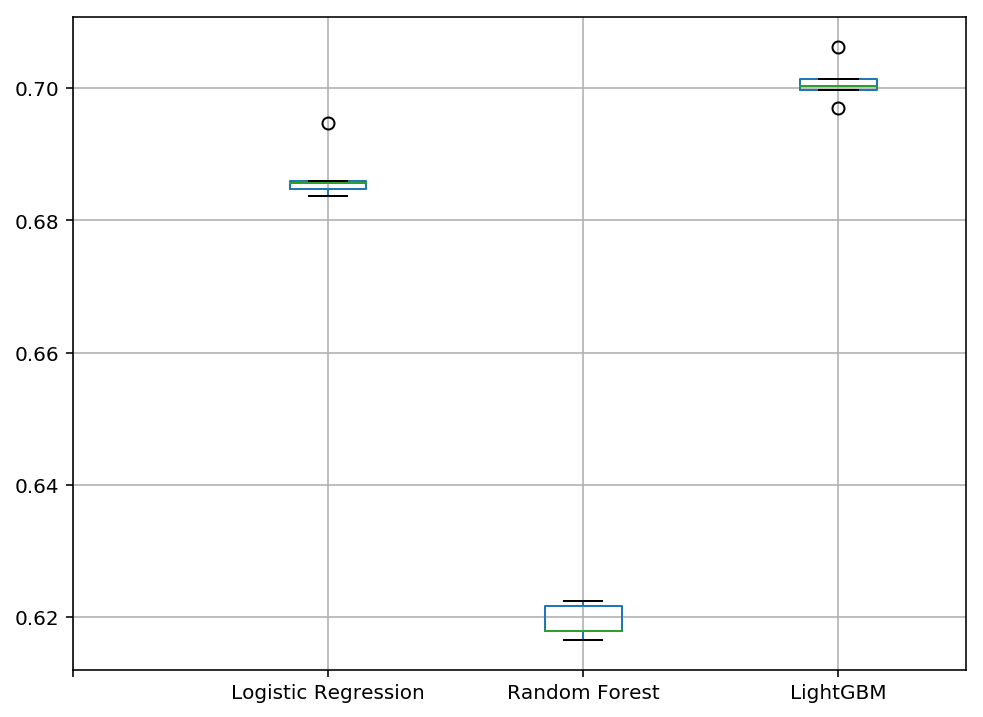

In [196]:
# logreg = LogisticRegression()
# rfc = RandomForestClassifier()
# xgb = XGBClassifier(scale_pos_weight=weights)
# bbc = BalancedBaggingClassifier(sampling_strategy='not majority', verbose=1)
logreg_balanced = LogisticRegression(class_weight='balanced')
rfc_balanced = RandomForestClassifier(class_weight='balanced')
lgbm = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', objective='binary', learning_rate=0.12, n_estimators=130, silent=False)

# print(logreg)
# print(rfc)
# print(xgb)
# print(bbc)
print(logreg_balanced)
print(rfc_balanced)
print(lgbm)

# checking model's ccross_val_score to compare and plot boxplot from the scores
models_compare_result = model_comparison([logreg_balanced,rfc_balanced,lgbm], X_train, y_train, 'roc_auc')
plot_models_compare_result(models_compare_result)

              Prediced Not Approved  Prediced Approved
Not Approved                   5280               3114
Approved                      15548              30682
TN = 5280, FP = 3114
FN = 15548, TP = 30682
Sensitivity / Recall (true positive rate) : 0.663681592039801
Precision (positive predictive value) : 0.9078589182151734
f1 score : 0.7668007897433334
Accuracy : 0.6583553016988869

ROC AUC Score : 0.6961647976256539

              precision    recall  f1-score   support

           0       0.25      0.63      0.36      8394
           1       0.91      0.66      0.77     46230

   micro avg       0.66      0.66      0.66     54624
   macro avg       0.58      0.65      0.56     54624
weighted avg       0.81      0.66      0.70     54624
 



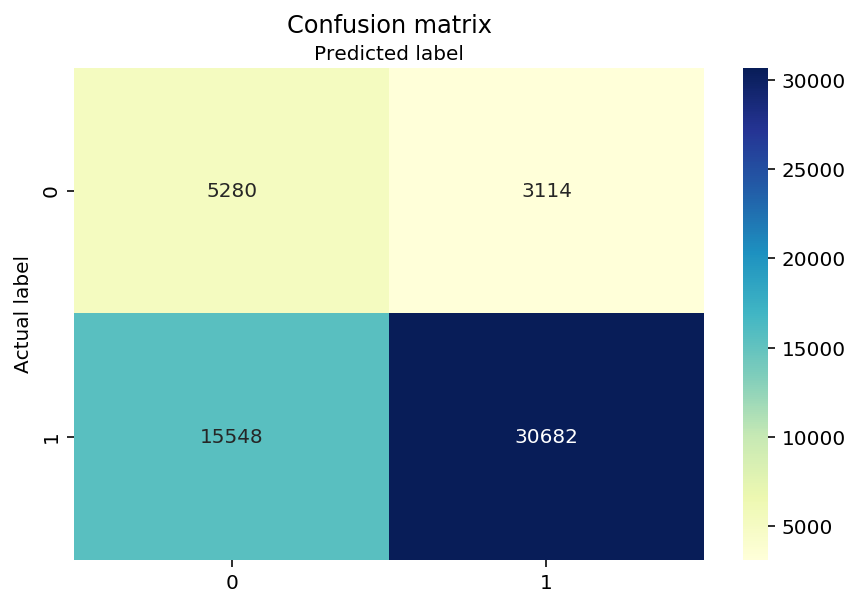

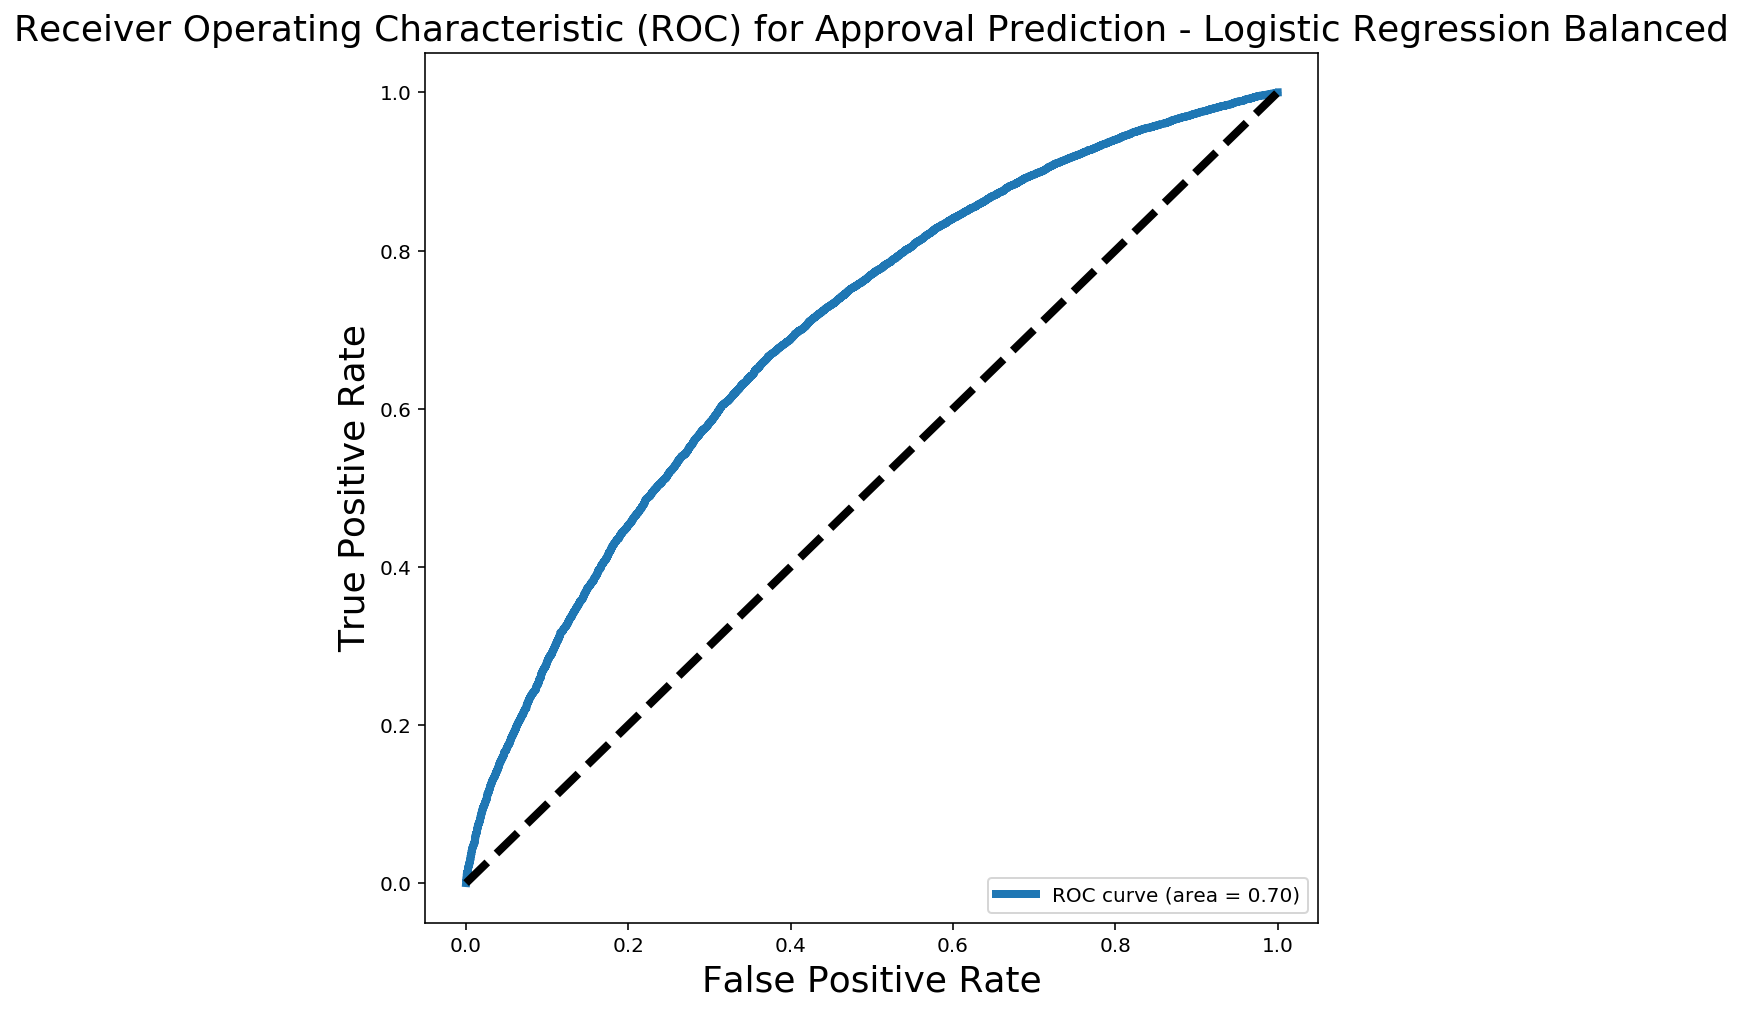

In [197]:
logreg_balanced.fit(X_train,y_train)

yhat = logreg_balanced.predict(X_test)
yhat_pp = logreg_balanced.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,yhat_pp,
                                                        "Logistic Regression Balanced")
model_results.loc['Logistic Regression Balanced'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]

              Prediced Not Approved  Prediced Approved
Not Approved                    898               7496
Approved                       1817              44413
TN = 898, FP = 7496
FN = 1817, TP = 44413
Sensitivity / Recall (true positive rate) : 0.9606965174129353
Precision (positive predictive value) : 0.8555934423703019
f1 score : 0.9051039851639002
Accuracy : 0.8295071763327475

ROC AUC Score : 0.6264747679076724

              precision    recall  f1-score   support

           0       0.33      0.11      0.16      8394
           1       0.86      0.96      0.91     46230

   micro avg       0.83      0.83      0.83     54624
   macro avg       0.59      0.53      0.53     54624
weighted avg       0.77      0.83      0.79     54624
 



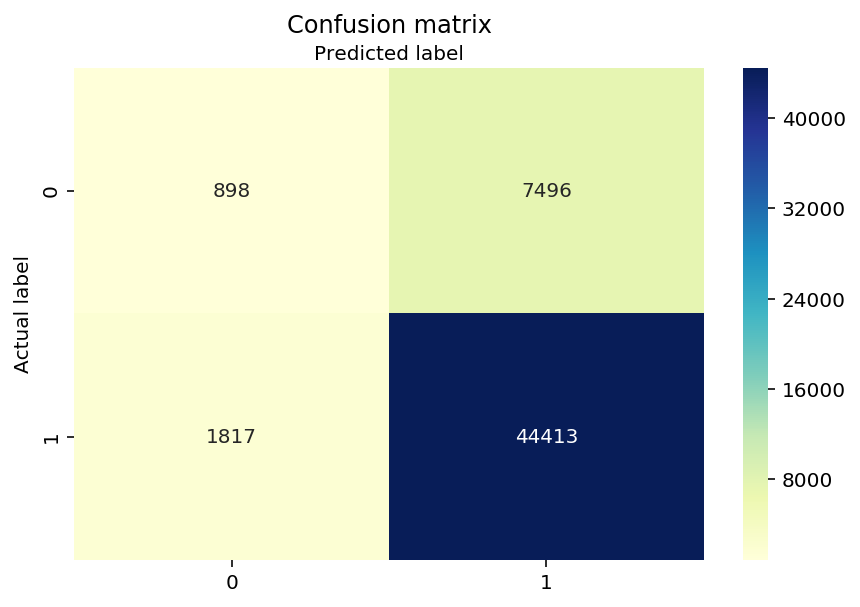

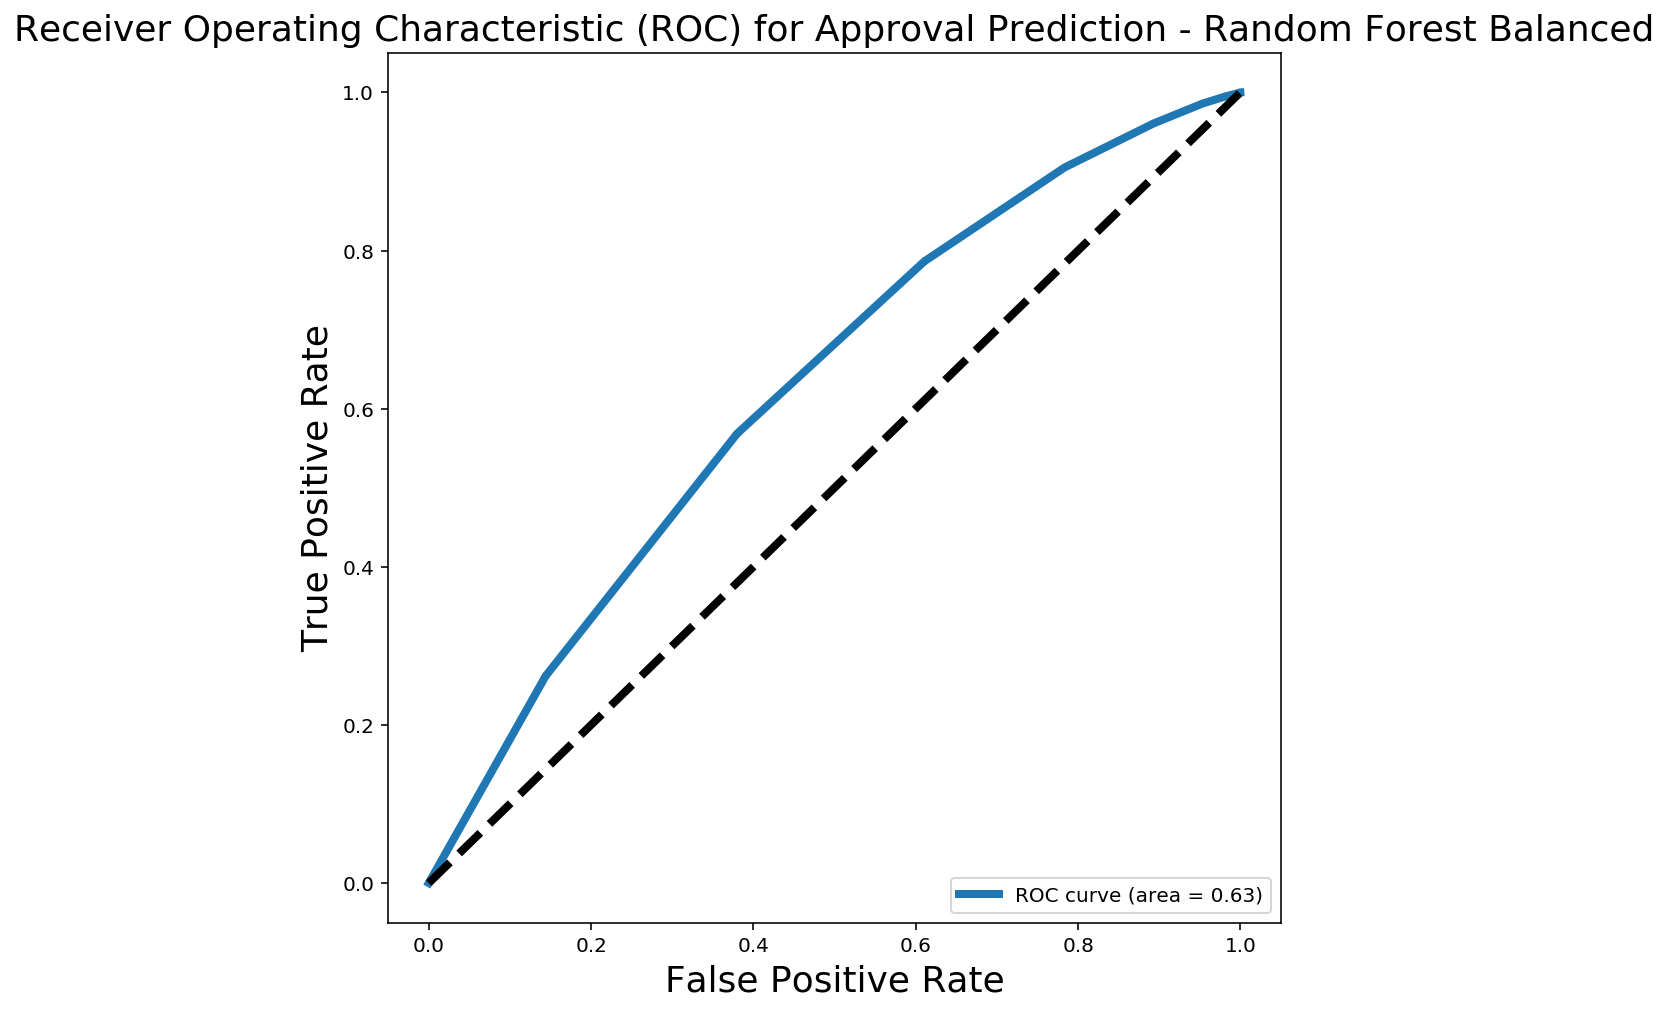

In [198]:
rfc_balanced.fit(X_train,y_train)

yhat = rfc_balanced.predict(X_test)
yhat_pp = rfc_balanced.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
                                                                  yhat_pp,
                                                                  'Random Forest Balanced')
model_results.loc['Random Forest Balanced'] = [recall, precision, f1_score, roc_auc, accuracy]

              Prediced Not Approved  Prediced Approved
Not Approved                   5265               3129
Approved                      14740              31490
TN = 5265, FP = 3129
FN = 14740, TP = 31490
Sensitivity / Recall (true positive rate) : 0.6811594202898551
Precision (positive predictive value) : 0.9096161067621826
f1 score : 0.7789830424618733
Accuracy : 0.6728727299355595

ROC AUC Score : 0.7094500047441775

              precision    recall  f1-score   support

           0       0.26      0.63      0.37      8394
           1       0.91      0.68      0.78     46230

   micro avg       0.67      0.67      0.67     54624
   macro avg       0.59      0.65      0.57     54624
weighted avg       0.81      0.67      0.72     54624
 



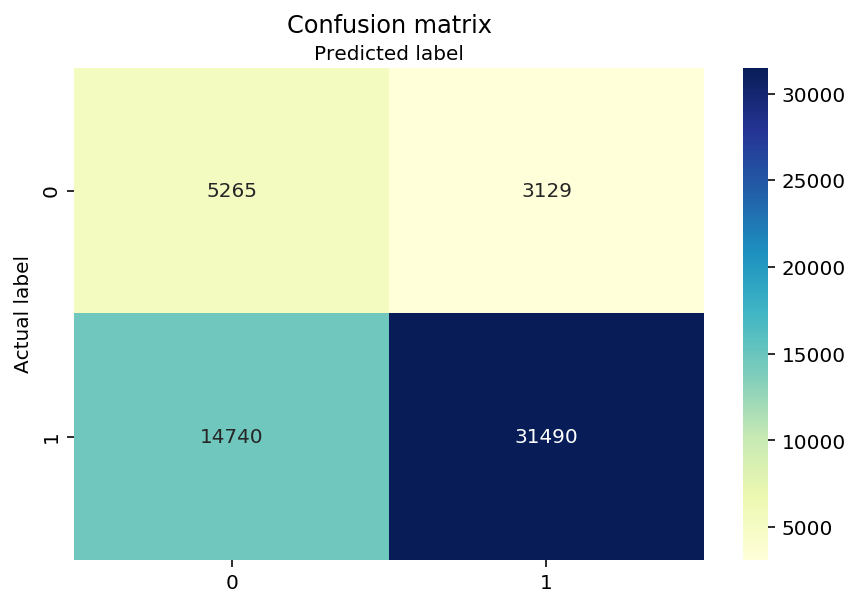

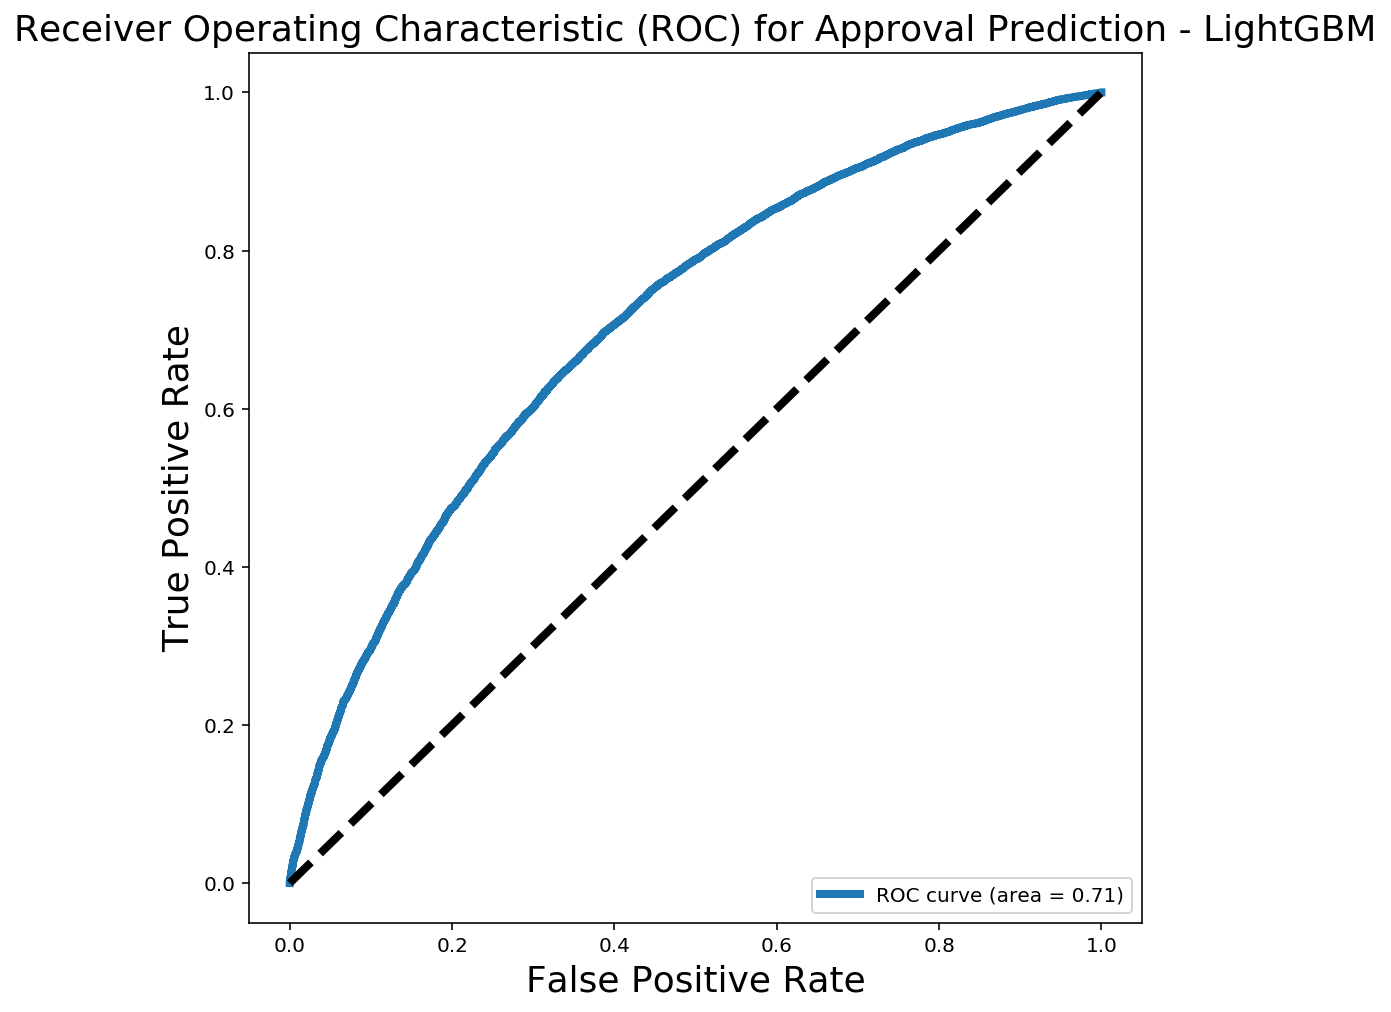

In [199]:
lgbm.fit(X_train.values,y_train)

yhat = lgbm.predict(X_test.values)
yhat_pp = lgbm.predict_proba(X_test.values)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,yhat_pp,
                                                        "LightGBM")
model_results.loc['LightGBM'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]

In [200]:
joblib.dump(lgbm, 'application_model.pkl')

['application_model.pkl']

In [201]:
test_df.head(1)

id                        teacher_id teacher_prefix school_state  \
0  p233245  5724a0c3ce11008366fff36dab4b943c            Ms.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-04-27 13:45:41          Grades PreK-2   

  project_subject_categories project_subject_subcategories  \
0           Music & The Arts                   Visual Arts   

              project_title  \
0  Art Will Make You Happy!   

                                     project_essay_1  \
0  My 2nd grade students are amazing!  They are v...   

                                     project_essay_2  \
0  My class is made up of 12 boys and 12 girls.  ...   

                                     project_essay_3  \
0  My second grade class will really benefit from...   

                                     project_essay_4  \
0  The genorous donations to my project will make...   

                            project_resource_summary  \
0  My students need a drying rack for their art p...   

   teacher_number_of_previously_posted_projects  
0                                             2

In [202]:
X_test.head(1)

budget  day_1  day_10  day_11  day_12  day_13  day_14  day_15  day_16  \
65841   209.3      0       0       0       0       0       0       0       0   

       day_17                      ...                       \
65841       0                      ...                        

       subcat_Special Needs  subcat_Special Needs, Team Sports  \
65841                     0                                  0   

       subcat_Special Needs, Visual Arts  \
65841                                  0   

       subcat_Special Needs, Warmth, Care & Hunger  subcat_Team Sports  \
65841                                            0                   0   

       subcat_Team Sports, Visual Arts  subcat_Visual Arts  \
65841                                0                   0   

       subcat_Visual Arts, Warmth, Care & Hunger  \
65841                                          0   

       subcat_Warmth, Care & Hunger  \
65841                             0   

       teacher_number_of_previously_posted_projects  
65841                                             4  

[1 rows x 3209 columns]

In [203]:
X_test.head(1).values

array([[209.3,   0. ,   0. , ...,   0. ,   0. ,   4. ]])

In [204]:
lgbm.predict(X_test.head(1).values)

array([0])

In [205]:
application_model = open('application_model.pkl','rb')
clf = joblib.load(application_model)

In [206]:
clf.predict(X_test.head(1).values)

array([0])

### Model Result Comparison

In [207]:
model_results.sort_values(by='ROC_AUC', ascending=False)

Recall  Precision  f1_score   ROC_AUC  \
LightGBM                      0.681159   0.909616  0.778983  0.709450   
Logistic Regression Balanced  0.663682   0.907859  0.766801  0.696165   
Random Forest Balanced        0.960697   0.855593  0.905104  0.626475   

                              Accuracy  
LightGBM                      0.672873  
Logistic Regression Balanced  0.658355  
Random Forest Balanced        0.829507

# 7. Getting Important Features From Selective Best Model

In [208]:
X_train.columns

Index(['budget', 'day_1', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14',
       'day_15', 'day_16', 'day_17',
       ...
       'subcat_Special Needs', 'subcat_Special Needs, Team Sports',
       'subcat_Special Needs, Visual Arts',
       'subcat_Special Needs, Warmth, Care & Hunger', 'subcat_Team Sports',
       'subcat_Team Sports, Visual Arts', 'subcat_Visual Arts',
       'subcat_Visual Arts, Warmth, Care & Hunger',
       'subcat_Warmth, Care & Hunger',
       'teacher_number_of_previously_posted_projects'],
      dtype='object', length=3209)

In [209]:
sum(X_train.columns == X_test.columns)

3209

In [210]:
features_importance_df = pd.DataFrame({'Features': X.columns,
                                       'feature_importances': lgbm.feature_importances_})
features_importance_df.head()

Features  feature_importances
0   budget                  174
1    day_1                   11
2   day_10                    7
3   day_11                    2
4   day_12                    2

In [211]:
features_importance_df.sort_values(by='feature_importances', ascending=False).head(20)

Features  feature_importances
0                                           budget                  174
3208  teacher_number_of_previously_posted_projects                  106
2647                project_essay_3_4_students use                   27
2533             project_essay_3_4_stability balls                   21
2384              project_essay_3_4_materials help                   21
561                proj_resource_sum_need supplies                   20
2176                   project_essay_3_4_dry erase                   20
2169             project_essay_3_4_document camera                   19
2717               project_essay_3_4_wobble chairs                   19
2065              project_essay_3_4_allow students                   19
2546               project_essay_3_4_students able                   19
2285                project_essay_3_4_hokki stools                   18
2718               project_essay_3_4_wobble stools                   18
2659               project_essay_3_4_supplies help                   17
2383             project_essay_3_4_materials allow                   16
1457              project_essay_1_2_grade students                   16
2100                project_essay_3_4_bouncy bands                   16
486                   proj_resource_sum_need items                   16
570                 proj_resource_sum_need variety                   15
504               proj_resource_sum_need materials                   15

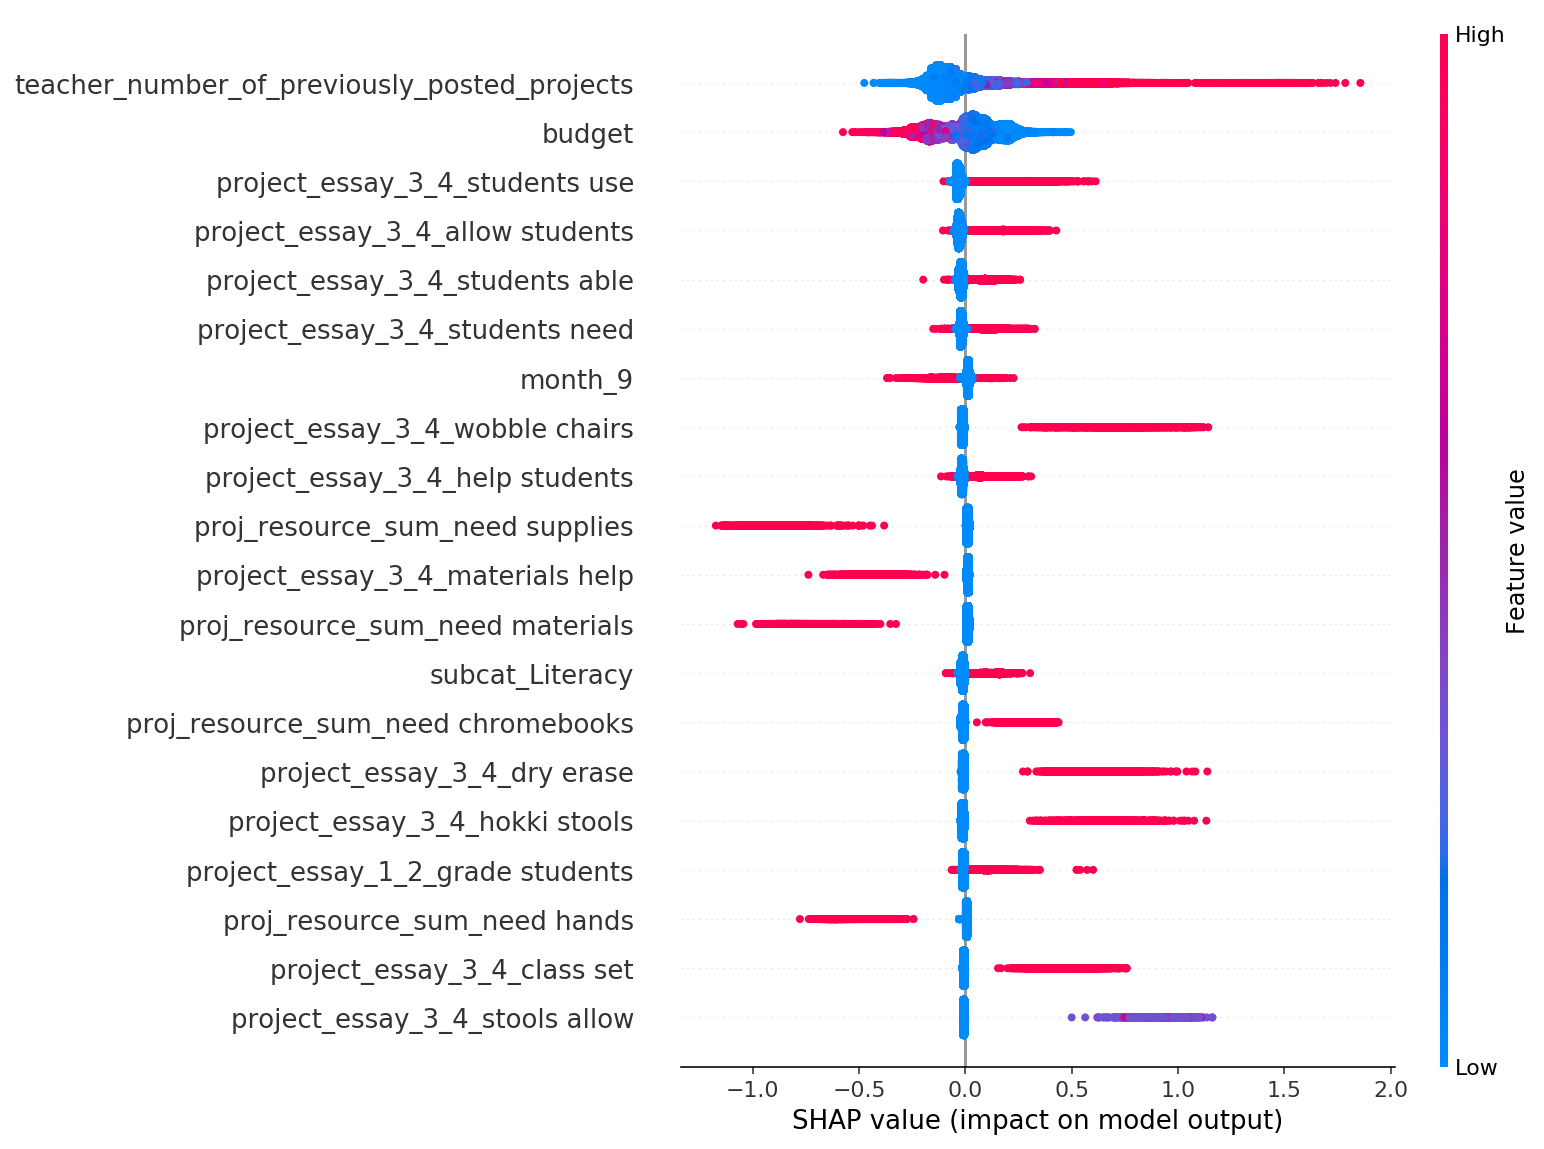

In [212]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# 8. Getting CSV out for Prediction of Test (For Kaggle Competition)

In [213]:
test.index = pd.RangeIndex(len(test.index))
test.head()

test_features = X.columns
test[test_features].head()

prediction = pd.DataFrame({'id': test["id"], 
                           'project_is_approved': lgbm.predict_proba(test[test_features].values)[:, 1]})
prediction.to_csv("LightGBM_prediction.csv",index=False)

In [214]:
ending_time = datetime.datetime.now()
print("Program ended at ", ending_time)
diff = ending_time - starting_time
print("Total running time is",int(diff.seconds/(60*60)),"hours",
      round((diff.seconds%(60*60))/60,2),"minutes")

Program ended at  2019-06-13 02:09:31.083231
Total running time is 0 hours 22.97 minutes


In [215]:
prediction = pd.DataFrame({'id': test["id"], 
                           'project_is_approved': lgbm.predict_proba(test[test_features])[:, 1]})
prediction.to_csv("lgbm_prediction.csv",index=False)


In [216]:
test_predict = lgbm.predict(test[test_features].values)
print(np.bincount(test_predict))

[28223 49812]
